In [1]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import isingmodellight
from isingmodellight import IsingModelLight
from scipy import stats
import time
import hcpdatautils as hcp
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [3]:
file_dir = 'E:\\Ising_model_results_daai'
other_file_dir = 'D:\\Ising_model_results_daai'

In [4]:
training_subject_start=0
training_subject_end = 670

In [5]:
plt.rcParams.update({'font.size': 20})

In [6]:
def depytorch(t:torch.Tensor):
    return t.detach().cpu().numpy()

In [7]:
def get_closest_match(values:torch.Tensor, target:float):
    return torch.argmin( torch.abs(values - target) )

In [8]:
def make_scatter_plot_with_regression_line_z(ax, feature:torch.Tensor, param:torch.Tensor, feature_name:str, param_name:str):
    # We assume both Tensors are 1D and the same size.
    
    feature_std, feature_mean = torch.std_mean(feature)
    feature_z = (feature - feature_mean)/feature_std

    feature_z_and_1 = torch.stack(  ( feature_z, torch.ones_like(feature_z) ), dim=-1  )
    param_col = param.unsqueeze(dim=-1)
    lst_sq_result = torch.linalg.lstsq(feature_z_and_1, param_col)
    param_pred = torch.matmul(feature_z_and_1, lst_sq_result.solution).flatten()
    param_mean = torch.mean(param)
    r_squared = 1 - torch.sum( torch.square(param - param_pred) )/torch.sum( torch.square(param - param_mean) )
    
    slope = lst_sq_result.solution[0].item()
    intercept = lst_sq_result.solution[1].item()
    print(f'{param_name}={slope:.3g}z({feature_name})+{intercept:.3g}, R^2={r_squared:.3g}')
    
    feature_z_np = depytorch(feature_z)
    param_np = depytorch(param)
    param_pred_np = depytorch(param_pred)
    ax.scatter(feature_z_np, param_np, color='blue')
    ax.plot(feature_z_np, param_pred_np, color='orange', linewidth=3)
    # ax.text( x=0.0, y=param_mean.item(), s=f'R^2={r_squared:.3g}, corr.={corr:.3g}' )
    ax.set_xlabel(f'{feature_name} (z-score)')
    ax.set_ylabel(f'{param_name}')

In [9]:
def make_scatter_plot_with_regression_line(ax, feature:torch.Tensor, param:torch.Tensor, feature_name:str, param_name:str):
    # We assume both Tensors are 1D and the same size.

    feature_and_1 = torch.stack(  ( feature, torch.ones_like(feature) ), dim=-1  )
    param_col = param.unsqueeze(dim=-1)
    lst_sq_result = torch.linalg.lstsq(feature_and_1, param_col)
    param_pred = torch.matmul(feature_and_1, lst_sq_result.solution).flatten()
    param_mean = torch.mean(param)
    r_squared = 1 - torch.sum( torch.square(param - param_pred) )/torch.sum( torch.square(param - param_mean) )
    
    slope = lst_sq_result.solution[0].item()
    intercept = lst_sq_result.solution[1].item()
    print(f'{param_name}={slope:.3g}{feature_name}+{intercept:.3g}, R^2={r_squared:.3g}')
    
    feature_np = depytorch(feature)
    param_np = depytorch(param)
    param_pred_np = depytorch(param_pred)
    ax.scatter(feature_np, param_np, color='blue')
    ax.plot(feature_np, param_pred_np, color='orange', linewidth=3)
    # ax.text( x=0.0, y=param_mean.item(), s=f'R^2={r_squared:.3g}, corr.={corr:.3g}' )
    ax.set_xlabel(f'{feature_name}')
    ax.set_ylabel(f'{param_name}')

In [10]:
def get_correlation_and_p(feature:torch.Tensor, param:torch.Tensor, feature_name:str, param_name:str, num_perms:int=1000000):
    # We assume both Tensors are 1D and the same size.
    
    corr = isingmodellight.get_pairwise_correlation(mat1=param, mat2=feature, dim=0)
    
    num_greater = 0
    num_values = feature.numel()
    corr_abs = corr.abs()
    for _ in range(num_perms):
        perm = torch.randperm( n=num_values, dtype=int_type, device=feature.device )
        perm_corr_abs = isingmodellight.get_pairwise_correlation(mat1=param, mat2=feature[perm], dim=0).abs()
        num_greater += (perm_corr_abs >= corr_abs)
    p_value = num_greater/num_perms
    
    print(f'{param_name} v. {feature_name} corr.={corr:.3g}, p-value={p_value:.3g}')
    return corr, p_value

In [11]:
median_col = 0
min_col = -2
max_col = -1

In [12]:
num_beta = 101
min_beta = 1e-10
max_beta = 0.05
num_threshold = 31
min_threshold = 0.0
max_threshold = 3.0
threshold = torch.linspace(start=min_threshold, end=3, steps=num_threshold, dtype=float_type, device=device)
beta = torch.linspace(start=min_beta, end=max_beta, steps=num_beta, dtype=float_type, device=device)
blue_thresh = get_closest_match(values=threshold, target=0.0)
green_thresh = get_closest_match(values=threshold, target=1.0)
red_thresh = get_closest_match(values=threshold, target=1.6)
data_string = f'thresholds_{num_threshold}_min_{min_threshold:.3g}_max_{max_threshold:.3g}'
param_string = f'light_group_{data_string}_betas_{num_beta}_min_{min_beta:.3g}_max_{max_beta}_steps_1200_lr_0.01_beta_updates_8_param_updates_40000'
# param_string = f'light_group_{data_string}_betas_{num_beta}_min_{min_beta:.3g}_max_{max_beta}_steps_1200_lr_0.01_beta_updates_8_param_updates_63000'

In [13]:
base_color_amplitude = 1.0
red_cval = [base_color_amplitude, 0.0, 0.0]
orange_cval = [base_color_amplitude, base_color_amplitude*0.5, 0.0]
green_cval = [0.0, base_color_amplitude, 0.0]
blue_cval = [0.0, 0.0, base_color_amplitude]
cyan_cval = [0.0, base_color_amplitude, base_color_amplitude]

In [14]:
def load_group_params():
    ising_model_file = os.path.join(other_file_dir, f'ising_model_{param_string}.pt')
    model = torch.load(ising_model_file, weights_only=False)
    print(f'loaded {ising_model_file}')
    print( 'h size', model.h.size() )
    print( 'J size', model.J.size() )
    h = model.h * model.beta.unsqueeze(dim=-1)
    J = model.J * model.beta.unsqueeze(dim=-1).unsqueeze(dim=-1)
    triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=J.size(dim=-1), device=J.device )
    return h, J[:,:,triu_rows,triu_cols], model.beta
group_h, group_J, group_beta = load_group_params()
print( 'h reduced to', group_h.size() )
print( 'J reduced to', group_J.size() )

loaded D:\Ising_model_results_daai\ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt
h size torch.Size([101, 31, 360])
J size torch.Size([101, 31, 360, 360])
h reduced to torch.Size([101, 31, 360])
J reduced to torch.Size([101, 31, 64620])


Text(0.5, 1.0, 'threshold=1.6')

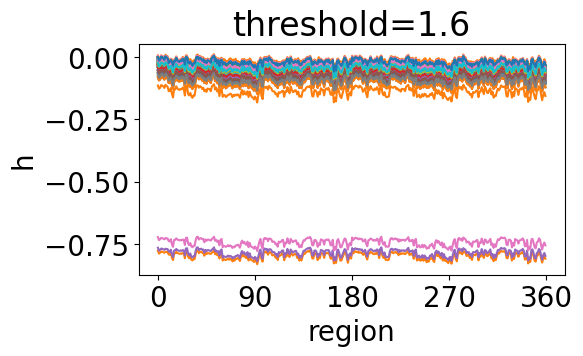

In [15]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5.5, 3) )
selected_thresh_index = get_closest_match(values=threshold, target=1.6)
selected_threshold = threshold[selected_thresh_index]
axs.plot(  depytorch( torch.transpose(group_h[:,selected_thresh_index,:], dim0=0, dim1=1) )  )
axs.set_xticks( np.arange(0, 361, 90) )
axs.set_xlabel('region')
axs.set_ylabel('h')
axs.set_title(f'threshold={selected_threshold:.3g}')

Text(0.5, 1.0, 'threshold=2')

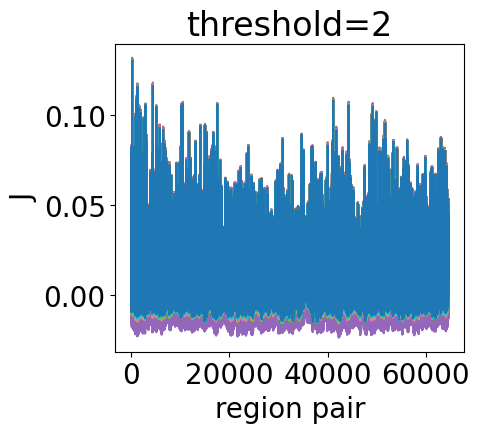

In [16]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4.5, 4) )
selected_thresh_index = get_closest_match(values=threshold, target=2.0)
selected_threshold = threshold[selected_thresh_index]
axs.plot(  depytorch( torch.transpose(group_J[:,selected_thresh_index,:], dim0=0, dim1=1) )  )
axs.set_xlabel('region pair')
axs.set_ylabel('J')
axs.set_title(f'threshold={selected_threshold:.3g}')

In [195]:
def plot_max_discrepancy_v_threshold(ax, params:torch.Tensor, param_name:str, cval:list):
    threshold_np = depytorch(threshold)
    param_min_over_reps, param_min_over_reps_index = params.min(dim=0)
    param_median_over_reps, param_median_over_reps_index = params.median(dim=0)
    param_max_over_reps, param_max_over_reps_index = params.max(dim=0)
    param_discrepancy = param_max_over_reps - param_min_over_reps
    param_discrepancy_max_over_thresh, param_discrepancy_max_over_thresh_index = param_discrepancy.max(dim=0)
    param_discrepancy_max_over_nodes, node_index = param_discrepancy_max_over_thresh.max(dim=0)
    param_min_at_node = param_min_over_reps[:,node_index]
    param_median_at_node = param_median_over_reps[:,node_index]
    param_max_at_node = param_max_over_reps[:,node_index]
    line_width = 3.0
    ax.fill_between( threshold_np, depytorch(param_min_at_node), depytorch(param_max_at_node), color=[0.9+0.1*c for c in cval] )
    ax.plot( threshold_np, depytorch(param_median_at_node), color=cval, linewidth=line_width, label=param_name )

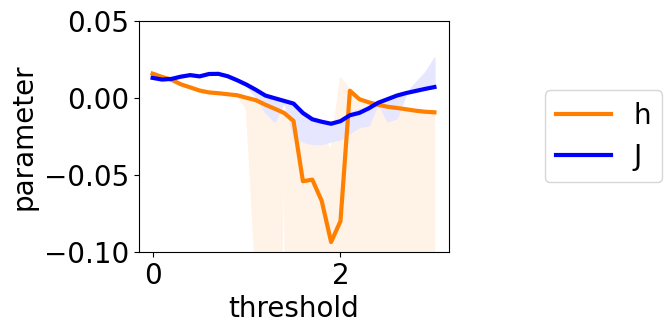

In [201]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 3) )
plot_max_discrepancy_v_threshold(axs, params=group_h, param_name='h', cval=orange_cval)
plot_max_discrepancy_v_threshold(axs, params=group_J, param_name='J', cval=blue_cval)
legend_loc = [1.5, 0.5, 0.0, 0.0]
axs.legend(loc='center', bbox_to_anchor=legend_loc)
# axs.set_xticks( np.arange(0, 2, 0.5) )
axs.set_xlabel('threshold')
axs.set_ylabel('parameter')
axs.set_ylim([-0.1, 0.05])
plt.show()

In [19]:
selected_thresh_index = get_closest_match(values=threshold, target=1.6)
selected_threshold = threshold[selected_thresh_index]
group_h_for_thresh = group_h[:,selected_thresh_index,:]
group_J_for_thresh = group_J[:,selected_thresh_index,:]
J_mean_over_nodes = group_J_for_thresh.mean(dim=-1)
min_replica_index = J_mean_over_nodes.argmin()
max_replica_index = J_mean_over_nodes.argmax()
min_replica_h = group_h_for_thresh[min_replica_index,:]
min_replica_J = group_J_for_thresh[min_replica_index,:]
max_replica_h = group_h_for_thresh[max_replica_index,:]
max_replica_J = group_J_for_thresh[max_replica_index,:]

Text(0.5, 1.0, 'threshold=1.6')

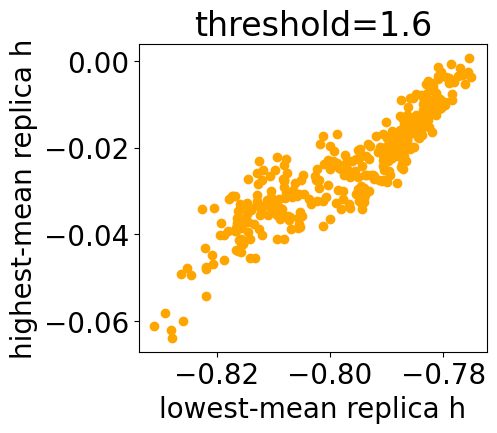

In [20]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4.5, 4) )
axs.scatter( depytorch(min_replica_h), depytorch(max_replica_h), color='orange', label=f'threshold={selected_threshold:.3g}' )
# axs.set_xticks([-0.09, -0.06, -0.03, 0.0])
axs.set_xlabel('lowest-mean replica h')
axs.set_ylabel('highest-mean replica h')
axs.set_title(f'threshold={selected_threshold:.3g}')

Text(0.5, 1.0, 'threshold=1.6')

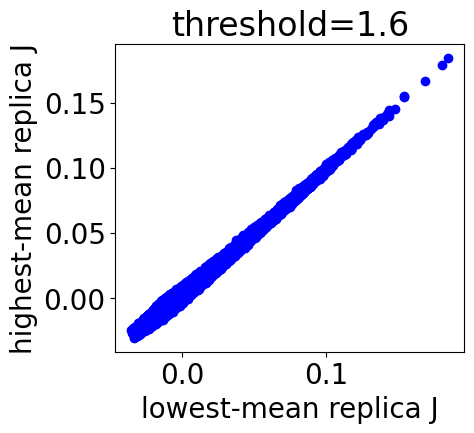

In [21]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4.5, 4) )
axs.scatter( depytorch(min_replica_J), depytorch(max_replica_J), color='blue', label=f'threshold={selected_threshold:.3g}' )
axs.set_xlabel('lowest-mean replica J')
axs.set_ylabel('highest-mean replica J')
axs.set_title(f'threshold={selected_threshold:.3g}')

In [22]:
def get_max_range_reps(param:torch.Tensor):
    min_over_reps, min_rep_index_for_each_node_and_threshold = torch.min(param, dim=0)
    max_over_reps, max_rep_index_for_each_node_and_threshold = torch.max(param, dim=0)
    range_over_reps = max_over_reps - min_over_reps
    max_range_for_each_threshold, max_range_for_each_threshold_node_index = range_over_reps.max(dim=-1)
    max_range, max_range_threshold_index = max_range_for_each_threshold.max(dim=-1)
    max_range_node_index = max_range_for_each_threshold_node_index[max_range_threshold_index]
    min_rep_index = min_rep_index_for_each_node_and_threshold[max_range_threshold_index, max_range_node_index]
    max_rep_index = max_rep_index_for_each_node_and_threshold[max_range_threshold_index, max_range_node_index]
    min_param = param[min_rep_index, max_range_threshold_index, max_range_node_index]
    max_param = param[max_rep_index, max_range_threshold_index, max_range_node_index]
    print(f'max range {max_range:.3g} between rep {min_rep_index} and {max_rep_index} at threshold {max_range_threshold_index} node {max_range_node_index}, min value {min_param:.3g}, max value {max_param:.3g}')
    return min_rep_index, max_rep_index, max_range_threshold_index, max_range_node_index

In [23]:
min_rep_index, max_rep_index, max_range_threshold_index, max_range_node_index = get_max_range_reps(group_J)
selected_thresh_index = max_range_threshold_index
selected_threshold = threshold[selected_thresh_index]
min_replica_h = group_h[min_rep_index,max_range_threshold_index,:]
min_replica_J = group_J[min_rep_index,max_range_threshold_index,:]
max_replica_h = group_h[max_rep_index,max_range_threshold_index,:]
max_replica_J = group_J[max_rep_index,max_range_threshold_index,:]

max range 0.0198 between rep 9 and 1 at threshold 30 node 61451, min value 0.00687, max value 0.0267


Text(0.5, 1.0, 'threshold=3')

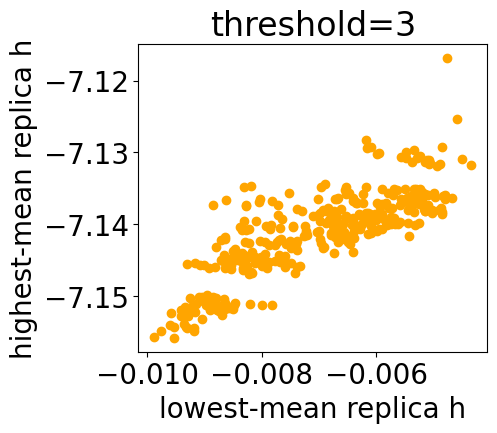

In [24]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4.5, 4) )
axs.scatter( depytorch(min_replica_h), depytorch(max_replica_h), color='orange', label=f'threshold={selected_threshold:.3g}' )
# axs.set_xticks([-0.09, -0.06, -0.03, 0.0])
axs.set_xlabel('lowest-mean replica h')
axs.set_ylabel('highest-mean replica h')
axs.set_title(f'threshold={selected_threshold:.3g}')

Text(0.5, 1.0, 'threshold=3')

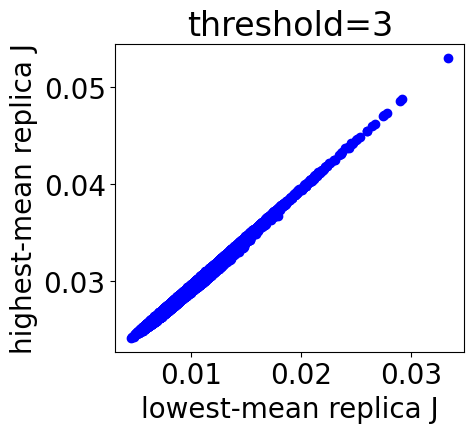

In [25]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4.5, 4) )
axs.scatter( depytorch(min_replica_J), depytorch(max_replica_J), color='blue', label=f'threshold={selected_threshold:.3g}' )
axs.set_xlabel('lowest-mean replica J')
axs.set_ylabel('highest-mean replica J')
axs.set_title(f'threshold={selected_threshold:.3g}')

In [26]:
def get_max_range_reps_at_threshold(param:torch.Tensor, threshold_index:int):
    param_at_threshold = param[:,threshold_index,:]
    min_over_reps, min_rep_index_for_each_node = torch.min(param_at_threshold, dim=0)
    max_over_reps, max_rep_index_for_each_node = torch.max(param_at_threshold, dim=0)
    range_over_reps = max_over_reps - min_over_reps
    max_range, max_range_node_index = range_over_reps.max(dim=-1)
    min_rep_index = min_rep_index_for_each_node[max_range_node_index]
    max_rep_index = max_rep_index_for_each_node[max_range_node_index]
    min_param = param[min_rep_index, threshold_index, max_range_node_index]
    max_param = param[max_rep_index, threshold_index, max_range_node_index]
    print(f'max range {max_range:.3g} between rep {min_rep_index} and {max_rep_index} at threshold {threshold_index} node {max_range_node_index}, min value {min_param:.3g}, max value {max_param:.3g}')
    return min_rep_index, max_rep_index, max_range_node_index

In [27]:
selected_thresh_index = get_closest_match(values=threshold, target=1.6)
selected_threshold = threshold[selected_thresh_index]
min_rep_index, max_rep_index, max_range_node_index = get_max_range_reps_at_threshold(param=group_h, threshold_index=selected_thresh_index)
selected_threshold = threshold[selected_thresh_index]
min_replica_h = group_h[min_rep_index,selected_thresh_index,:]
min_replica_J = group_J[min_rep_index,selected_thresh_index,:]
max_replica_h = group_h[max_rep_index,selected_thresh_index,:]
max_replica_J = group_J[max_rep_index,selected_thresh_index,:]

max range 0.806 between rep 1 and 41 at threshold 16 node 248, min value -0.813, max value -0.00608


Text(0.5, 1.0, 'threshold=1.6')

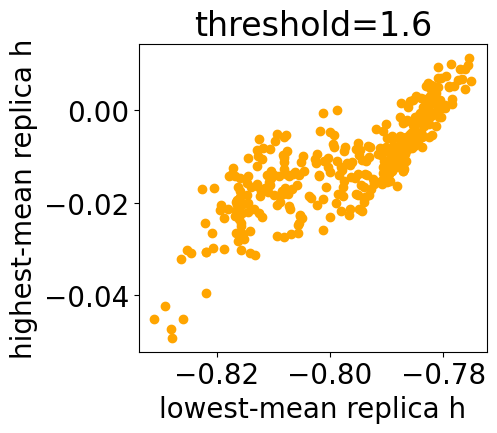

In [28]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4.5, 4) )
axs.scatter( depytorch(min_replica_h), depytorch(max_replica_h), color='orange', label=f'threshold={selected_threshold:.3g}' )
# axs.set_xticks([-0.09, -0.06, -0.03, 0.0])
axs.set_xlabel('lowest-mean replica h')
axs.set_ylabel('highest-mean replica h')
axs.set_title(f'threshold={selected_threshold:.3g}')

Text(0.5, 1.0, 'threshold=1.6')

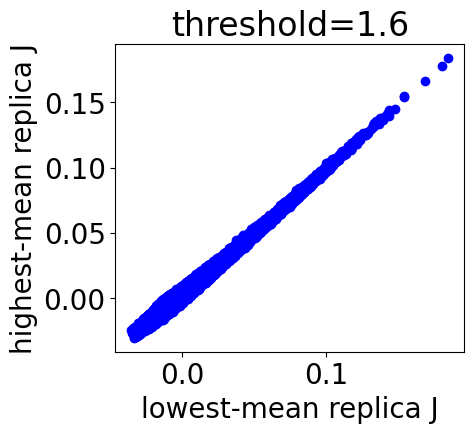

In [29]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4.5, 4) )
axs.scatter( depytorch(min_replica_J), depytorch(max_replica_J), color='blue', label=f'threshold={selected_threshold:.3g}' )
axs.set_xlabel('lowest-mean replica J')
axs.set_ylabel('highest-mean replica J')
axs.set_title(f'threshold={selected_threshold:.3g}')

In [30]:
print('correlations between replicas of J')
print(f'threshold\tmin\tmedian\tmax')
triu_rows_for_corr, triu_cols_for_corr = isingmodellight.get_triu_indices_for_products( num_nodes=group_J.size(dim=0), device=device )
for threshold_index in range(num_threshold):
    selected_threshold = threshold[threshold_index].item()
    J_rep_corr = torch.corrcoef(group_J[:,threshold_index,:])[triu_rows_for_corr,triu_cols_for_corr]
    # print( selected_threshold, J_rep_corr.min().item(), J_rep_corr.median().item(), J_rep_corr.max().item() )
    print( f'{selected_threshold:.3f}\t{J_rep_corr.min().item():.3f}\t{J_rep_corr.median().item():.3f}\t{J_rep_corr.max().item():.3f}' )

correlations between replicas of J
threshold	min	median	max
0.000	1.000	1.000	1.000
0.100	1.000	1.000	1.000
0.200	1.000	1.000	1.000
0.300	1.000	1.000	1.000
0.400	1.000	1.000	1.000
0.500	1.000	1.000	1.000
0.600	1.000	1.000	1.000
0.700	1.000	1.000	1.000
0.800	1.000	1.000	1.000
0.900	1.000	1.000	1.000
1.000	1.000	1.000	1.000
1.100	0.998	1.000	1.000
1.200	0.996	1.000	1.000
1.300	0.994	1.000	1.000
1.400	1.000	1.000	1.000
1.500	0.990	1.000	1.000
1.600	0.989	1.000	1.000
1.700	0.988	1.000	1.000
1.800	0.983	1.000	1.000
1.900	0.978	1.000	1.000
2.000	0.987	1.000	1.000
2.100	1.000	1.000	1.000
2.200	1.000	1.000	1.000
2.300	0.999	1.000	1.000
2.400	1.000	1.000	1.000
2.500	0.987	1.000	1.000
2.600	1.000	1.000	1.000
2.700	1.000	1.000	1.000
2.800	1.000	1.000	1.000
2.900	0.999	1.000	1.000
3.000	0.997	1.000	1.000


In [31]:
print( group_J.min().item(), group_J.mean().item(), group_J.max().item() )

-0.06424219161272049 0.005414997227489948 0.5870907306671143


In [32]:
print('correlations between replicas of h')
print(f'threshold\tmin\tmedian\tmax')
triu_rows_for_corr, triu_cols_for_corr = isingmodellight.get_triu_indices_for_products( num_nodes=group_h.size(dim=0), device=device )
for threshold_index in range(num_threshold):
    selected_threshold = threshold[threshold_index].item()
    h_rep_corr = torch.corrcoef(group_h[:,threshold_index,:])[triu_rows_for_corr,triu_cols_for_corr]
    # print( selected_threshold, h_rep_corr.min().item(), h_rep_corr.median().item(), h_rep_corr.max().item() )
    print( f'{selected_threshold:.3f}\t{h_rep_corr.min().item():.3f}\t{h_rep_corr.median().item():.3f}\t{h_rep_corr.max().item():.3f}' )

correlations between replicas of h
threshold	min	median	max
0.000	0.996	0.998	0.999
0.100	0.999	1.000	1.000
0.200	1.000	1.000	1.000
0.300	1.000	1.000	1.000
0.400	1.000	1.000	1.000
0.500	1.000	1.000	1.000
0.600	1.000	1.000	1.000
0.700	1.000	1.000	1.000
0.800	1.000	1.000	1.000
0.900	0.995	1.000	1.000
1.000	0.816	1.000	1.000
1.100	0.692	1.000	1.000
1.200	0.701	1.000	1.000
1.300	0.724	1.000	1.000
1.400	0.904	0.999	1.000
1.500	0.817	0.992	1.000
1.600	0.809	0.995	1.000
1.700	0.545	0.982	1.000
1.800	0.503	0.982	1.000
1.900	0.645	0.997	1.000
2.000	0.702	0.999	1.000
2.100	0.757	1.000	1.000
2.200	0.747	1.000	1.000
2.300	0.746	1.000	1.000
2.400	1.000	1.000	1.000
2.500	0.720	1.000	1.000
2.600	0.772	1.000	1.000
2.700	1.000	1.000	1.000
2.800	0.817	1.000	1.000
2.900	0.803	1.000	1.000
3.000	0.822	1.000	1.000


In [33]:
print( group_beta.size() )
group_beta_min = group_beta.min(dim=0).values
group_beta_median = group_beta.median(dim=0).values
group_beta_max = group_beta.max(dim=0).values

torch.Size([101, 31])


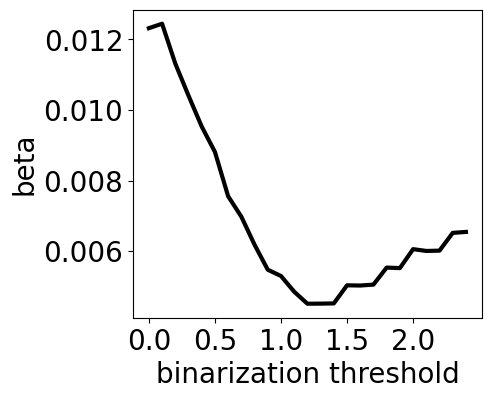

In [34]:
group_beta_min
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4.5, 4) )
target_end_thresh = 2.5
end_thresh = get_closest_match(values=threshold, target=target_end_thresh)
threshold_np = depytorch(threshold[:end_thresh])
line_width = 3.0

cval = [0.0, 0.0, 0.0]
axs.fill_between( threshold_np, depytorch(group_beta_min[:end_thresh]), depytorch(group_beta_max[:end_thresh]), color=[0.9+0.1*c for c in cval])
axs.plot( threshold_np, depytorch(group_beta_median[:end_thresh]), color=cval, linewidth=line_width, label=f'J' )

axs.set_xticks( np.arange(0, target_end_thresh, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('beta')
plt.show()

In [35]:
group_h_std_reps = torch.std(group_h, dim=0)

group_h_std_reps_min = group_h_std_reps.min(dim=-1).values
group_h_std_reps_median = group_h_std_reps.median(dim=-1).values
group_h_std_reps_max = group_h_std_reps.max(dim=-1).values

group_J_std_reps = torch.std(group_J, dim=0)

group_J_std_reps_min = group_J_std_reps.min(dim=-1).values
group_J_std_reps_median = group_J_std_reps.median(dim=-1).values
group_J_std_reps_max = group_J_std_reps.max(dim=-1).values

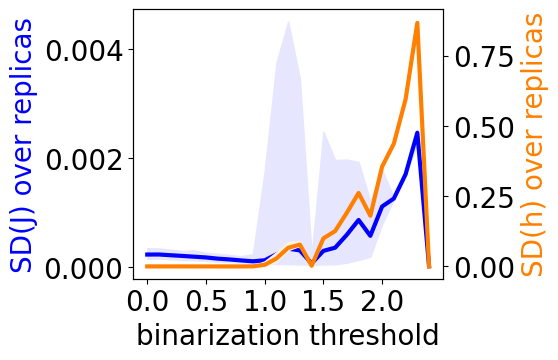

In [36]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 3.5) )
axs2 = axs.twinx()
target_end_thresh = 2.5
end_thresh = get_closest_match(values=threshold, target=target_end_thresh)
threshold_np = depytorch(threshold[:end_thresh])
line_width = 3.0

cval = blue_cval
axs.fill_between( threshold_np, depytorch(group_J_std_reps_min[:end_thresh]), depytorch(group_J_std_reps_max[:end_thresh]), color=[0.9+0.1*c for c in cval])
axs.plot( threshold_np, depytorch(group_J_std_reps_median[:end_thresh]), color=cval, linewidth=line_width, label=f'J' )

cval = orange_cval
axs2.fill_between( threshold_np, depytorch(group_h_std_reps_min[:end_thresh]), depytorch(group_h_std_reps_max[:end_thresh]), color=[0.9+0.1*c for c in cval])
axs2.plot( threshold_np, depytorch(group_h_std_reps_median[:end_thresh]), color=cval, linewidth=line_width, label=f'h' )

# axs.legend()
# axs2.legend()
axs.set_xticks( np.arange(0, target_end_thresh, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('SD(J) over replicas', color=blue_cval)
axs2.set_ylabel('SD(h) over replicas', color=orange_cval)
plt.show()

In [37]:
group_J_at_threshold = group_J[:,8,:]
group_J_at_threshold_std, group_J_at_threshold_mean = torch.std_mean(group_J_at_threshold, dim=0)
print( group_J_at_threshold_std.min().tolist(), group_J_at_threshold_std.median().tolist(), group_J_at_threshold_std.max().tolist(), group_J_at_threshold_std.mean().tolist(), group_J_at_threshold_std.std().tolist() )
print( group_J_at_threshold_mean.min().tolist(), group_J_at_threshold_mean.median().tolist(), group_J_at_threshold_mean.max().tolist(), group_J_at_threshold_mean.mean().tolist(), group_J_at_threshold_mean.std().tolist() )

7.74140571593307e-05 0.0001237075193785131 0.0002006200229516253 0.00012462137965485454 1.3284859960549511e-05
-0.055924393236637115 9.604727529222146e-05 0.3812144994735718 0.0043293144553899765 0.022145157679915428


In [38]:
group_h_at_threshold = group_h[:,8,:]
group_h_at_threshold_std, group_h_at_threshold_mean = torch.std_mean(group_h_at_threshold, dim=0)
print( group_h_at_threshold_std.min().tolist(), group_h_at_threshold_std.median().tolist(), group_h_at_threshold_std.max().tolist(), group_h_at_threshold_std.mean().tolist(), group_h_at_threshold_std.std().tolist() )
print( group_h_at_threshold_mean.min().tolist(), group_h_at_threshold_mean.median().tolist(), group_h_at_threshold_mean.max().tolist(), group_h_at_threshold_mean.mean().tolist(), group_h_at_threshold_mean.std().tolist() )

0.00011443175026215613 0.0001822400517994538 0.0003311494365334511 0.00018466389155946672 3.35417571477592e-05
-0.1272987574338913 -0.00629400135949254 0.04993196204304695 -0.007997957058250904 0.02663975954055786


In [39]:
group_beta_at_threshold = group_beta[:,15]
print( group_beta_at_threshold.min().tolist(), group_beta_at_threshold.median().tolist(), group_beta_at_threshold.max().tolist(), group_beta_at_threshold.mean().tolist(), group_beta_at_threshold.std().tolist() )

0.00503055052831769 0.00503055052831769 0.00503055052831769 0.00503055052831769 0.0


In [16]:
fc_corr_group = torch.load( os.path.join(file_dir,'fc_corr_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_test_length_120000.pt'), weights_only=False )
print( fc_corr_group.size() )

torch.Size([101, 31])


In [17]:
fc_corr_group_min = fc_corr_group.min(dim=0).values
fc_corr_group_median = fc_corr_group.median(dim=0).values
fc_corr_group_max = fc_corr_group.max(dim=0).values

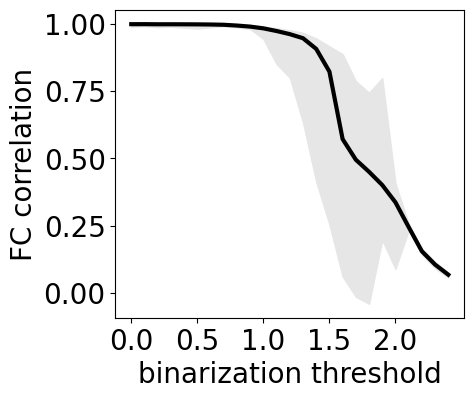

In [18]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4.5, 4) )
target_end_thresh = 2.5
end_thresh = get_closest_match(values=threshold, target=target_end_thresh)
threshold_np = depytorch(threshold[:end_thresh])
line_width = 3.0

cval = [0.0, 0.0, 0.0]
axs.fill_between( threshold_np, depytorch(fc_corr_group_min[:end_thresh]), depytorch(fc_corr_group_max[:end_thresh]), color=[0.9+0.1*c for c in cval])
axs.plot( threshold_np, depytorch(fc_corr_group_median[:end_thresh]), color=cval, linewidth=line_width, label=f'FC correlation' )

axs.set_xticks( np.arange(0, target_end_thresh, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('FC correlation')
plt.show()

In [43]:
thresh_index = 16
print( fc_corr_group_min[thresh_index].item(), fc_corr_group_median[thresh_index].item(), fc_corr_group_max[thresh_index].item(), fc_corr_group[:,thresh_index].mean().item(),  fc_corr_group[:,thresh_index].std().item() )

0.061844602227211 0.571467936038971 0.8866235017776489 0.6093233823776245 0.21458780765533447


In [44]:
fc_corr_group_max, fc_corr_group_max_index = fc_corr_group.max(dim=0)
best_group_h = torch.zeros_like(group_h[0,:,:])
best_group_J = torch.zeros_like(group_J[0,:,:])
for threshold_index in range( fc_corr_group_max_index.numel() ):
    best_rep_index = fc_corr_group_max_index[threshold_index]
    best_group_h[threshold_index,:] = group_h[best_rep_index, threshold_index, :]
    best_group_J[threshold_index,:] = group_J[best_rep_index, threshold_index, :]

In [45]:
dist_from_best_h = isingmodellight.get_pairwise_rmse( mat1=group_h, mat2=best_group_h.unsqueeze(dim=0), dim=-1 )
dist_from_best_J = isingmodellight.get_pairwise_rmse( mat1=group_J, mat2=best_group_J.unsqueeze(dim=0), dim=-1 )

FC correlation=-0.393distance from best h+0.627, R^2=0.0524
distance from best h (threshold=1.6) v. correlation with data FC corr.=-0.227, p-value=0.0211


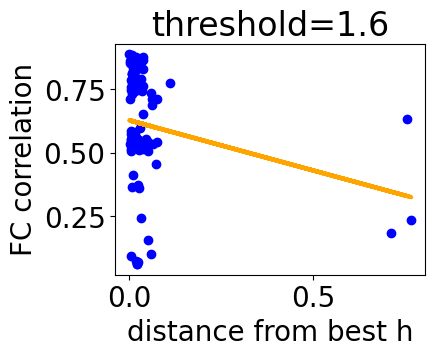

In [46]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 3) )
threshold_index = get_closest_match(values=threshold, target=1.6)
selected_threshold = threshold[threshold_index]
make_scatter_plot_with_regression_line(axs, feature=dist_from_best_h[:,threshold_index], param=fc_corr_group[:,threshold_index], feature_name='distance from best h', param_name='FC correlation')
get_correlation_and_p(feature=dist_from_best_h[:,threshold_index], param=fc_corr_group[:,threshold_index], feature_name='correlation with data FC', param_name=f'distance from best h (threshold={selected_threshold:.3g})', num_perms=10000)
axs.set_title(f'threshold={selected_threshold:.3g}')
plt.show()

FC correlation=-83.6distance from best J+0.635, R^2=0.0509
distance from best J (threshold=1.6) v. correlation with data FC corr.=-0.223, p-value=0.0205


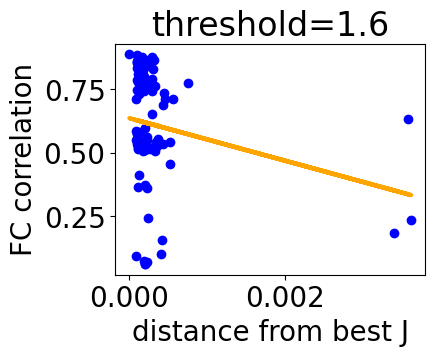

In [47]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 3) )
threshold_index = get_closest_match(values=threshold, target=1.6)
selected_threshold = threshold[threshold_index]
make_scatter_plot_with_regression_line(axs, feature=dist_from_best_J[:,threshold_index], param=fc_corr_group[:,threshold_index], feature_name='distance from best J', param_name='FC correlation')
get_correlation_and_p(feature=dist_from_best_J[:,threshold_index], param=fc_corr_group[:,threshold_index], feature_name='correlation with data FC', param_name=f'distance from best J (threshold={selected_threshold:.3g})', num_perms=10000)
axs.set_title(f'threshold={selected_threshold:.3g}')
plt.show()

In [48]:
corr_with_best_h = isingmodellight.get_pairwise_correlation( mat1=group_h, mat2=best_group_h.unsqueeze(dim=0), epsilon=0.0, dim=-1 )
corr_with_best_J = isingmodellight.get_pairwise_correlation( mat1=group_J, mat2=best_group_J.unsqueeze(dim=0), epsilon=0.0, dim=-1 )

In [49]:
best_group_h_std, best_group_h_mean = torch.std_mean(best_group_h, dim=-1)
best_group_J_std, best_group_J_mean = torch.std_mean(best_group_J, dim=-1)
print(  torch.stack( (threshold, best_group_h_mean, best_group_h_std, best_group_J_mean, best_group_J_std), dim=-1 )  )

tensor([[ 0.0000e+00,  2.1216e-04,  5.0242e-03,  4.1075e-03,  2.4557e-02],
        [ 1.0000e-01, -1.6410e-03,  1.0064e-02,  4.1168e-03,  2.4666e-02],
        [ 2.0000e-01, -3.5857e-03,  1.7275e-02,  4.1256e-03,  2.4431e-02],
        [ 3.0000e-01, -4.8465e-03,  2.3454e-02,  4.1490e-03,  2.4253e-02],
        [ 4.0000e-01, -6.2176e-03,  2.7818e-02,  4.1800e-03,  2.4046e-02],
        [ 5.0000e-01, -6.9378e-03,  3.0307e-02,  4.2142e-03,  2.3857e-02],
        [ 6.0000e-01, -7.6589e-03,  3.0040e-02,  4.2472e-03,  2.3209e-02],
        [ 7.0000e-01, -7.9306e-03,  2.9170e-02,  4.2945e-03,  2.2857e-02],
        [ 8.0000e-01, -7.9909e-03,  2.6617e-02,  4.3362e-03,  2.2144e-02],
        [ 9.0000e-01, -8.1796e-03,  2.4052e-02,  4.3712e-03,  2.1243e-02],
        [ 1.0000e+00, -7.9700e-03,  2.1048e-02,  4.4352e-03,  2.0790e-02],
        [ 1.1000e+00, -8.0682e-03,  1.8020e-02,  4.4966e-03,  1.9812e-02],
        [ 1.2000e+00, -8.2862e-03,  1.5560e-02,  4.5728e-03,  1.8903e-02],
        [ 1.3000e+00, -9.

In [50]:
print(  torch.stack( (threshold, group_h_std_reps_median, group_h_std_reps_max, group_J_std_reps_median, group_J_std_reps_max), dim=-1 )  )

tensor([[0.0000e+00, 2.5104e-04, 3.3350e-04, 2.3145e-04, 3.4797e-04],
        [1.0000e-01, 2.5301e-04, 3.3528e-04, 2.3239e-04, 3.4274e-04],
        [2.0000e-01, 2.4549e-04, 3.5181e-04, 2.1876e-04, 3.2157e-04],
        [3.0000e-01, 2.2027e-04, 2.9643e-04, 2.0597e-04, 2.9707e-04],
        [4.0000e-01, 2.1526e-04, 3.0232e-04, 1.9185e-04, 3.0905e-04],
        [5.0000e-01, 2.0073e-04, 2.8154e-04, 1.7833e-04, 2.6483e-04],
        [6.0000e-01, 1.8643e-04, 2.4816e-04, 1.5603e-04, 2.4570e-04],
        [7.0000e-01, 1.7270e-04, 2.3665e-04, 1.4172e-04, 2.2625e-04],
        [8.0000e-01, 1.8224e-04, 3.3115e-04, 1.2371e-04, 2.0062e-04],
        [9.0000e-01, 4.1404e-04, 1.9956e-03, 1.0724e-04, 2.3940e-04],
        [1.0000e+00, 5.8762e-03, 1.8385e-02, 1.2586e-04, 1.7607e-03],
        [1.1000e+00, 2.8410e-02, 5.0893e-02, 2.3424e-04, 3.7499e-03],
        [1.2000e+00, 6.6351e-02, 8.6948e-02, 3.3933e-04, 4.5048e-03],
        [1.3000e+00, 7.7822e-02, 9.0332e-02, 3.0721e-04, 3.4592e-03],
        [1.4000e+00,

In [51]:
print( torch.count_nonzero(group_h_std_reps[16,:] > 0.001) )

tensor(360, device='cuda:0')


FC correlation=2.6correlation with best h+-1.93, R^2=0.0626
correlation with best h (threshold=1.6) v. correlation with data FC corr.=0.248, p-value=0.0101


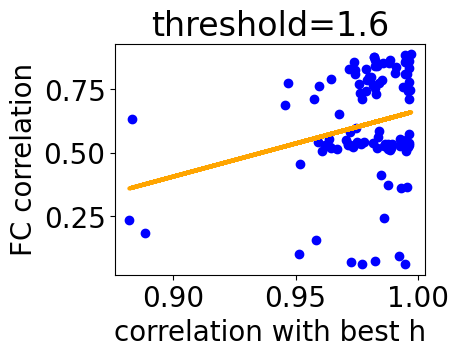

In [52]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 3) )
threshold_index = get_closest_match(values=threshold, target=1.6)
selected_threshold = threshold[threshold_index]
make_scatter_plot_with_regression_line(axs, feature=corr_with_best_h[:,threshold_index], param=fc_corr_group[:,threshold_index], feature_name='correlation with best h', param_name='FC correlation')
get_correlation_and_p(feature=corr_with_best_h[:,threshold_index], param=fc_corr_group[:,threshold_index], feature_name='correlation with data FC', param_name=f'correlation with best h (threshold={selected_threshold:.3g})', num_perms=10000)
axs.set_title(f'threshold={selected_threshold:.3g}')
plt.show()

FC correlation=28.2correlation with best J+-27.6, R^2=0.0457
correlation with best J (threshold=1.6) v. correlation with data FC corr.=0.211, p-value=0.0269


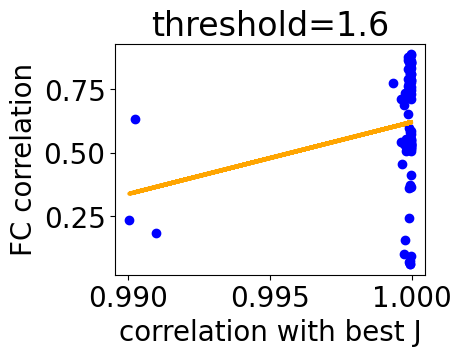

In [53]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 3) )
threshold_index = get_closest_match(values=threshold, target=1.6)
selected_threshold = threshold[threshold_index]
make_scatter_plot_with_regression_line(axs, feature=corr_with_best_J[:,threshold_index], param=fc_corr_group[:,threshold_index], feature_name='correlation with best J', param_name='FC correlation')
get_correlation_and_p(feature=corr_with_best_J[:,threshold_index], param=fc_corr_group[:,threshold_index], feature_name='correlation with data FC', param_name=f'correlation with best J (threshold={selected_threshold:.3g})', num_perms=10000)
axs.set_title(f'threshold={selected_threshold:.3g}')
plt.show()

In [67]:
min_corr_with_best_h = corr_with_best_h.min(dim=0).values
median_corr_with_best_h = corr_with_best_h.median(dim=0).values
max_corr_with_best_h = corr_with_best_h.max(dim=0).values
min_corr_with_best_J = corr_with_best_J.min(dim=0).values
median_corr_with_best_J = corr_with_best_J.median(dim=0).values
max_corr_with_best_J = corr_with_best_J.max(dim=0).values

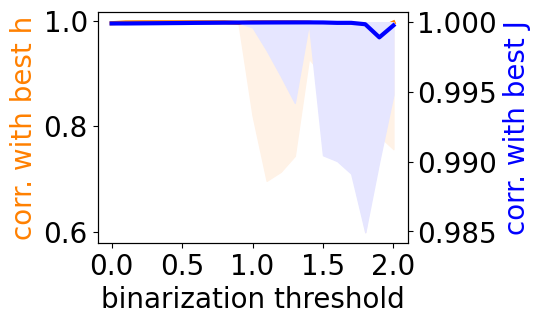

In [68]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 3) )
axs2 = axs.twinx()
target_end_thresh = 2.1
end_thresh = get_closest_match(values=threshold, target=target_end_thresh)
threshold_np = depytorch(threshold[:end_thresh])
line_width = 3.0

axs.fill_between( threshold_np, depytorch(min_corr_with_best_h[:end_thresh]), depytorch(max_corr_with_best_h[:end_thresh]), color=[0.9+0.1*c for c in orange_cval] )
axs.plot( threshold_np, depytorch(median_corr_with_best_h[:end_thresh]), color=orange_cval, linewidth=line_width, label=f'h' )
axs2.fill_between( threshold_np, depytorch(min_corr_with_best_J[:end_thresh]), depytorch(max_corr_with_best_J[:end_thresh]), color=[0.9+0.1*c for c in blue_cval] )
axs2.plot( threshold_np, depytorch(median_corr_with_best_J[:end_thresh]), color=blue_cval, linewidth=line_width, label=f'J' )

# axs.legend()
# axs2.legend()
axs.set_xticks( np.arange(0, target_end_thresh, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('corr. with best h', color=orange_cval)
axs2.set_ylabel('corr. with best J', color=blue_cval)
plt.show()

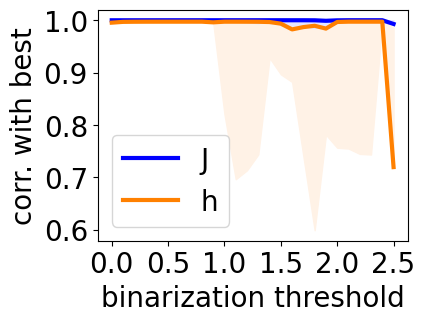

In [98]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 3) )
target_end_thresh = 2.6
end_thresh = get_closest_match(values=threshold, target=target_end_thresh)
threshold_np = depytorch(threshold[:end_thresh])
line_width = 3.0

axs.fill_between( threshold_np, depytorch(min_corr_with_best_h[:end_thresh]), depytorch(max_corr_with_best_h[:end_thresh]), color=[0.9+0.1*c for c in orange_cval] )
axs.fill_between( threshold_np, depytorch(min_corr_with_best_J[:end_thresh]), depytorch(max_corr_with_best_J[:end_thresh]), color=[0.9+0.1*c for c in blue_cval] )
axs.plot( threshold_np, depytorch(median_corr_with_best_J[:end_thresh]), color=blue_cval, linewidth=line_width, label=f'J' )
axs.plot( threshold_np, depytorch(median_corr_with_best_h[:end_thresh]), color=orange_cval, linewidth=line_width, label=f'h' )

axs.legend(loc='lower left')
axs.set_xticks( np.arange(0, target_end_thresh, 0.5) )
axs.set_yticks( np.arange(0.6, 1.01, 0.1) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('corr. with best')
plt.show()

In [104]:
print(  torch.stack( tensors=(threshold, min_corr_with_best_h, median_corr_with_best_h, min_corr_with_best_J), dim=-1 )  )

tensor([[0.0000, 0.9941, 0.9953, 0.9999],
        [0.1000, 0.9966, 0.9968, 0.9999],
        [0.2000, 0.9970, 0.9971, 0.9999],
        [0.3000, 0.9971, 0.9972, 0.9999],
        [0.4000, 0.9971, 0.9972, 0.9999],
        [0.5000, 0.9972, 0.9972, 0.9999],
        [0.6000, 0.9972, 0.9972, 0.9999],
        [0.7000, 0.9972, 0.9972, 0.9999],
        [0.8000, 0.9971, 0.9972, 1.0000],
        [0.9000, 0.9958, 0.9959, 1.0000],
        [1.0000, 0.8204, 0.9972, 0.9996],
        [1.1000, 0.6964, 0.9972, 0.9980],
        [1.2000, 0.7135, 0.9971, 0.9961],
        [1.3000, 0.7437, 0.9970, 0.9942],
        [1.4000, 0.9281, 0.9965, 0.9999],
        [1.5000, 0.8967, 0.9934, 0.9904],
        [1.6000, 0.8822, 0.9825, 0.9900],
        [1.7000, 0.7403, 0.9868, 0.9891],
        [1.8000, 0.5990, 0.9894, 0.9849],
        [1.9000, 0.7813, 0.9840, 0.9900],
        [2.0000, 0.7565, 0.9966, 0.9948],
        [2.1000, 0.7550, 0.9972, 1.0000],
        [2.2000, 0.7448, 0.9972, 1.0000],
        [2.3000, 0.7436, 0.9972, 0

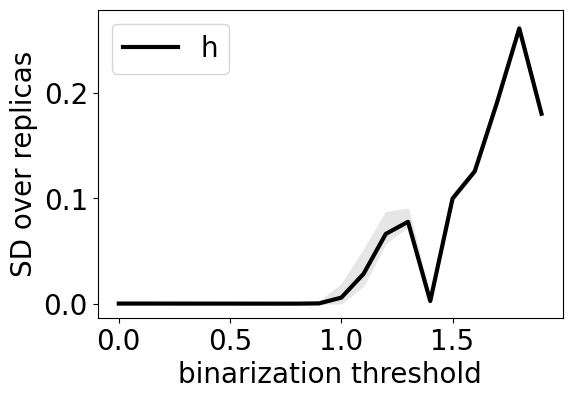

In [19]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 4) )
end_thresh = get_closest_match(values=threshold, target=2.0)
threshold_np = depytorch(threshold[:end_thresh])
line_width = 3.0

cval = [0.0, 0.0, 0.0]
axs.fill_between( threshold_np, depytorch(group_h_std_reps_min[:end_thresh]), depytorch(group_h_std_reps_max[:end_thresh]), color=[0.9+0.1*c for c in cval])
axs.plot( threshold_np, depytorch(group_h_std_reps_median[:end_thresh]), color=cval, linewidth=line_width, label=f'h' )

axs.legend()
axs.set_xlabel('binarization threshold')
axs.set_ylabel('SD over replicas')
plt.show()

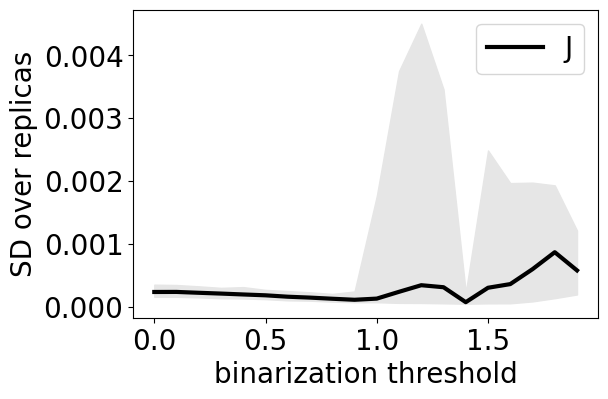

In [20]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 4) )
end_thresh = get_closest_match(values=threshold, target=2.0)
threshold_np = depytorch(threshold[:end_thresh])
line_width = 3.0

cval = [0.0, 0.0, 0.0]
axs.fill_between( threshold_np, depytorch(group_J_std_reps_min[:end_thresh]), depytorch(group_J_std_reps_max[:end_thresh]), color=[0.9+0.1*c for c in cval])
axs.plot( threshold_np, depytorch(group_J_std_reps_median[:end_thresh]), color=cval, linewidth=line_width, label=f'J' )

axs.legend()
axs.set_xlabel('binarization threshold')
axs.set_ylabel('SD over replicas')
plt.show()

In [21]:
group_h_std, group_h_mean = torch.std_mean(group_h, dim=-1)
group_J_std, group_J_mean = torch.std_mean(group_J, dim=-1)

group_h_std_min = group_h_std.min(dim=0).values
group_h_std_median = group_h_std.median(dim=0).values
group_h_std_max = group_h_std.max(dim=0).values

group_h_mean_min = group_h_mean.min(dim=0).values
group_h_mean_median = group_h_mean.median(dim=0).values
group_h_mean_max = group_h_mean.max(dim=0).values

group_J_std_min = group_J_std.min(dim=0).values
group_J_std_median = group_J_std.median(dim=0).values
group_J_std_max = group_J_std.max(dim=0).values

group_J_mean_min = group_J_mean.min(dim=0).values
group_J_mean_median = group_J_mean.median(dim=0).values
group_J_mean_max = group_J_mean.max(dim=0).values

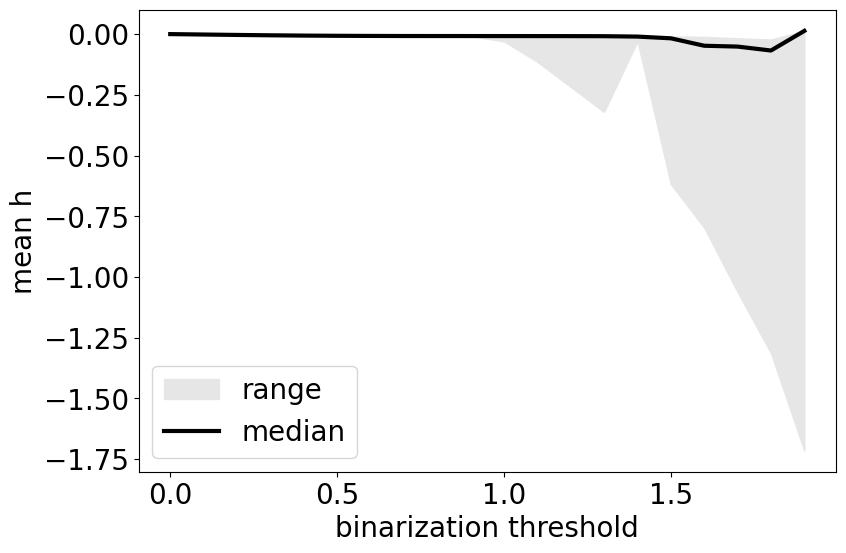

In [22]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
max_threshold_index = get_closest_match(values=threshold, target=2.0)
threshold_np = depytorch(threshold[:max_threshold_index])
line_width = 3.0

cval = [0.0, 0.0, 0.0]
axs.fill_between( threshold_np, depytorch(group_h_mean_min[:max_threshold_index]), depytorch(group_h_mean_max[:max_threshold_index]), color=[0.9+0.1*c for c in cval], label=f'range')
# axs.plot( threshold_np, state_mean_rmse_min_np, color=cval, linestyle='--', linewidth=line_width )
# axs.plot( threshold_np, state_mean_rmse_max_np, color=cval, linestyle='--', linewidth=line_width )
axs.plot( threshold_np, depytorch(group_h_mean_median[:max_threshold_index]), color=cval, linewidth=line_width, label=f'median' )

axs.legend()
axs.set_xlabel('binarization threshold')
axs.set_ylabel('mean h')
plt.show()

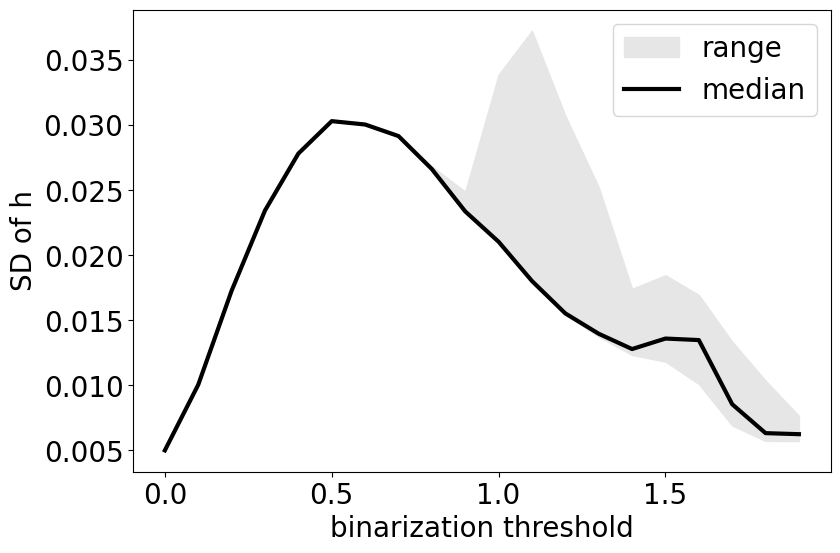

In [23]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
max_threshold_index = get_closest_match(values=threshold, target=2.0)
threshold_np = depytorch(threshold[:max_threshold_index])
line_width = 3.0

cval = [0.0, 0.0, 0.0]
axs.fill_between( threshold_np, depytorch(group_h_std_min[:max_threshold_index]), depytorch(group_h_std_max[:max_threshold_index]), color=[0.9+0.1*c for c in cval], label=f'range')
# axs.plot( threshold_np, state_mean_rmse_min_np, color=cval, linestyle='--', linewidth=line_width )
# axs.plot( threshold_np, state_mean_rmse_max_np, color=cval, linestyle='--', linewidth=line_width )
axs.plot( threshold_np, depytorch(group_h_std_median[:max_threshold_index]), color=cval, linewidth=line_width, label=f'median' )

axs.legend()
axs.set_xlabel('binarization threshold')
axs.set_ylabel('SD of h')
plt.show()

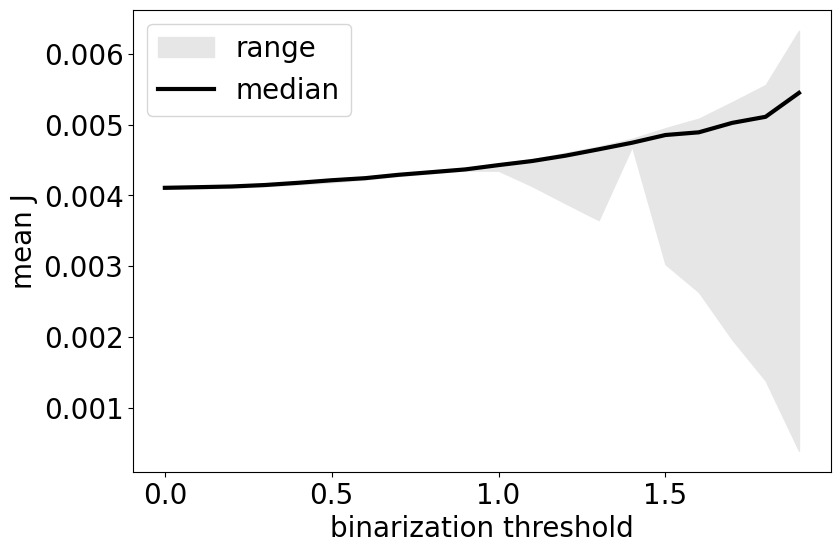

In [24]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
max_threshold_index = get_closest_match(values=threshold, target=2.0)
threshold_np = depytorch(threshold[:max_threshold_index])
line_width = 3.0

cval = [0.0, 0.0, 0.0]
axs.fill_between( threshold_np, depytorch(group_J_mean_min[:max_threshold_index]), depytorch(group_J_mean_max[:max_threshold_index]), color=[0.9+0.1*c for c in cval], label=f'range')
# axs.plot( threshold_np, state_mean_rmse_min_np, color=cval, linestyle='--', linewidth=line_width )
# axs.plot( threshold_np, state_mean_rmse_max_np, color=cval, linestyle='--', linewidth=line_width )
axs.plot( threshold_np, depytorch(group_J_mean_median[:max_threshold_index]), color=cval, linewidth=line_width, label=f'median' )

axs.legend()
axs.set_xlabel('binarization threshold')
axs.set_ylabel('mean J')
plt.show()

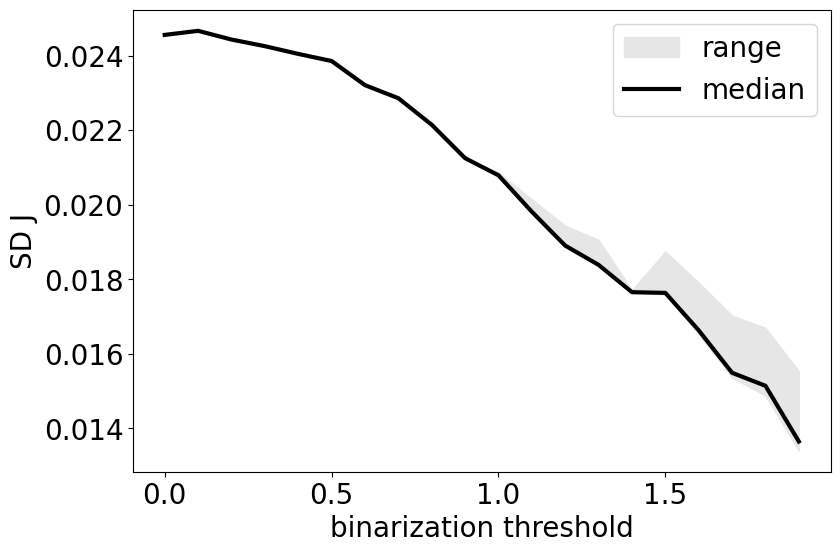

In [25]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
max_threshold_index = get_closest_match(values=threshold, target=2.0)
threshold_np = depytorch(threshold[:max_threshold_index])
line_width = 3.0

cval = [0.0, 0.0, 0.0]
axs.fill_between( threshold_np, depytorch(group_J_std_min[:max_threshold_index]), depytorch(group_J_std_max[:max_threshold_index]), color=[0.9+0.1*c for c in cval], label=f'range')
# axs.plot( threshold_np, state_mean_rmse_min_np, color=cval, linestyle='--', linewidth=line_width )
# axs.plot( threshold_np, state_mean_rmse_max_np, color=cval, linestyle='--', linewidth=line_width )
axs.plot( threshold_np, depytorch(group_J_std_median[:max_threshold_index]), color=cval, linewidth=line_width, label=f'median' )

axs.legend()
axs.set_xlabel('binarization threshold')
axs.set_ylabel('SD J')
plt.show()

In [26]:
group_h_rep_mean = group_h.mean(dim=0)
group_h_corr_with_0 = isingmodellight.get_pairwise_correlation( mat1=group_h_rep_mean, mat2=group_h_rep_mean[0,:].unsqueeze(dim=0), epsilon=0.0, dim=-1 )

In [27]:
group_J_rep_mean = group_J.mean(dim=0)
group_J_corr_with_0 = isingmodellight.get_pairwise_correlation( mat1=group_J_rep_mean, mat2=group_J_rep_mean[0,:].unsqueeze(dim=0), epsilon=0.0, dim=-1 )

In [28]:
group_h_min = group_h_rep_mean.min(dim=-1).values
group_h_median = group_h_rep_mean.median(dim=-1).values
group_h_max = group_h_rep_mean.max(dim=-1).values

group_J_min = group_J_rep_mean.min(dim=-1).values
group_J_median = group_J_rep_mean.median(dim=-1).values
group_J_max = group_J_rep_mean.max(dim=-1).values

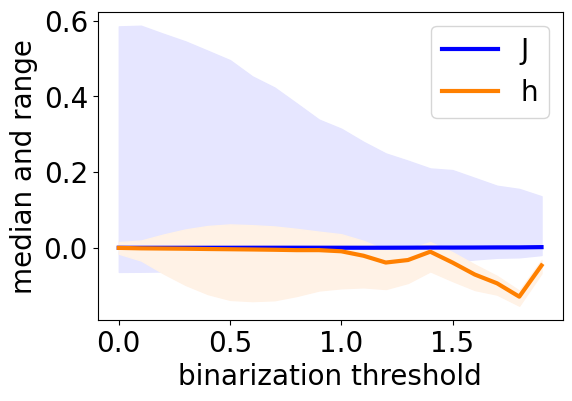

In [29]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 4) )
end_thresh = get_closest_match(values=threshold, target=2.0)
threshold_np = depytorch(threshold[:end_thresh])
line_width = 3.0

cval = blue_cval
axs.fill_between( threshold_np, depytorch(group_J_min[:end_thresh]), depytorch(group_J_max[:end_thresh]), color=[0.9+0.1*c for c in cval])
axs.plot( threshold_np, depytorch(group_J_median[:end_thresh]), color=cval, linewidth=line_width, label=f'J' )

cval = orange_cval
axs.fill_between( threshold_np, depytorch(group_h_min[:end_thresh]), depytorch(group_h_max[:end_thresh]), color=[0.9+0.1*c for c in cval])
axs.plot( threshold_np, depytorch(group_h_median[:end_thresh]), color=cval, linewidth=line_width, label=f'h' )

axs.legend()
axs.set_xlabel('binarization threshold')
axs.set_ylabel('median and range')
plt.show()

In [30]:
group_h_std, group_h_mean = torch.std_mean(group_h_rep_mean, dim=-1)
group_h_below_std = group_h_mean - group_h_std
group_h_above_std = group_h_mean + group_h_std
group_J_std, group_J_mean = torch.std_mean(group_J_rep_mean, dim=-1)
group_J_below_std = group_J_mean - group_J_std
group_J_above_std = group_J_mean + group_J_std

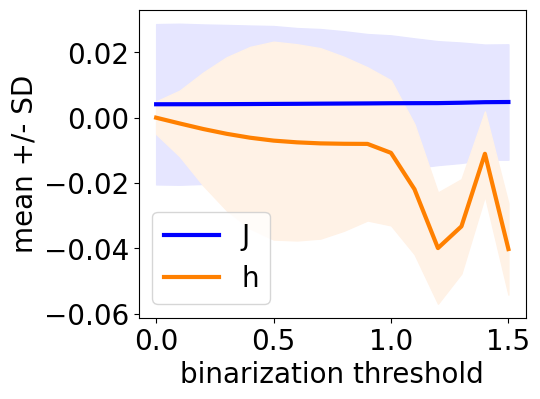

In [50]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
end_thresh = get_closest_match(values=threshold, target=1.6)
threshold_np = depytorch(threshold[:end_thresh])
line_width = 3.0

cval = blue_cval
axs.fill_between( threshold_np, depytorch(group_J_below_std[:end_thresh]), depytorch(group_J_above_std[:end_thresh]), color=[0.9+0.1*c for c in cval])
axs.plot( threshold_np, depytorch(group_J_mean[:end_thresh]), color=cval, linewidth=line_width, label=f'J' )

cval = orange_cval
axs.fill_between( threshold_np, depytorch(group_h_below_std[:end_thresh]), depytorch(group_h_above_std[:end_thresh]), color=[0.9+0.1*c for c in cval])
axs.plot( threshold_np, depytorch(group_h_mean[:end_thresh]), color=cval, linewidth=line_width, label=f'h' )

axs.legend()
axs.set_xticks( np.arange(0, 2, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('mean +/- SD')
plt.show()

In [51]:
print( group_J_mean[:end_thresh].min().item(), group_J_mean[:end_thresh].max().item() )

0.00410739379003644 0.004797894507646561


In [52]:
print( group_J_std[:end_thresh].min().item(), group_J_std[:end_thresh].max().item() )

0.01765507459640503 0.024663666263222694


In [41]:
mean_state_group = torch.load( os.path.join(file_dir, 'mean_state_thresholds_31_min_0_max_3.pt'), weights_only=False )
print( mean_state_group.size() )

torch.Size([31, 360])


In [45]:
mean_state_product_group = torch.load( os.path.join(file_dir, 'mean_state_product_thresholds_31_min_0_max_3.pt'), weights_only=False )
print( mean_state_product_group.size() )

torch.Size([31, 360, 360])


In [68]:
mean_state_product_group_at_threshold = mean_state_product_group[14,:,:]
print( mean_state_product_group_at_threshold.min().item(), mean_state_product_group_at_threshold.median().item(), mean_state_product_group_at_threshold.max().item(), mean_state_product_group_at_threshold.mean().item(), mean_state_product_group_at_threshold.std().item() )

0.7119938135147095 0.7663594484329224 1.0 0.7717591524124146 0.02734774723649025


In [72]:
mean_state_group_at_threshold = mean_state_group[14,:]
print( mean_state_group_at_threshold.min().item(), mean_state_group_at_threshold.median().item(), mean_state_group_at_threshold.max().item(), mean_state_group_at_threshold.mean().item(), mean_state_group_at_threshold.std().item() )

-0.855956494808197 -0.8450193405151367 -0.8363651037216187 -0.8452410697937012 0.004197354428470135


In [49]:
mean_state_product_group_std, mean_state_product_group_mean = torch.std_mean( mean_state_product_group, dim=(1,2) )
mean_state_product_group_below_std = mean_state_product_group_mean - mean_state_product_group_std
mean_state_product_group_above_std = mean_state_product_group_mean + mean_state_product_group_std

In [54]:
update_start = 0
update_end = 63000
update_step = 1000
stat_series_string = f'min_median_max_mean_std_ising_model_light_group_thresholds_{num_threshold}_min_{min_threshold:.3g}_max_{max_threshold:.3g}_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_updates_min_{update_start}_max_{update_end}_increment_{update_step}'
updates = torch.arange(start=update_start, end=update_end+1, step=update_step, dtype=int_type, device=device)
h_stats_series = torch.load( os.path.join(file_dir, f'h_{stat_series_string}.pt'), weights_only=False )
print( h_stats_series.size() )
J_stats_series = torch.load( os.path.join(file_dir, f'J_{stat_series_string}.pt'), weights_only=False )
print( J_stats_series.size() )

torch.Size([64, 31, 360, 5])
torch.Size([64, 31, 64620, 5])


In [55]:
h_std_series = h_stats_series[:,:,:,-1]
h_std_min_series = torch.min(input=h_std_series, dim=-1).values
h_std_median_series = torch.median(input=h_std_series, dim=-1).values
h_std_max_series = torch.max(input=h_std_series, dim=-1).values

In [56]:
J_std_series = J_stats_series[:,:,:,-1]
J_std_min_series = torch.min(input=J_std_series, dim=-1).values
J_std_median_series = torch.median(input=J_std_series, dim=-1).values
J_std_max_series = torch.max(input=J_std_series, dim=-1).values

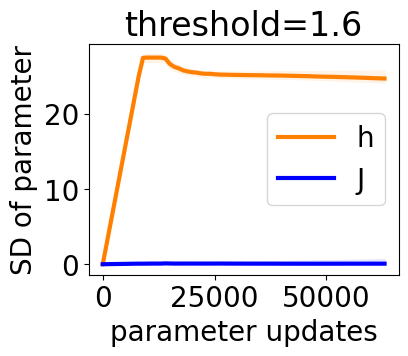

In [57]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 3) )
updates_np = depytorch(updates)
selected_thresh_index = get_closest_match(values=threshold, target=1.6)
selected_threshold = threshold[selected_thresh_index]
h_std_min_series_at_thresh = h_std_min_series[:,selected_thresh_index]
h_std_median_series_at_thresh = h_std_median_series[:,selected_thresh_index]
h_std_max_series_at_thresh = h_std_max_series[:,selected_thresh_index]
J_std_min_series_at_thresh = J_std_min_series[:,selected_thresh_index]
J_std_median_series_at_thresh = J_std_median_series[:,selected_thresh_index]
J_std_max_series_at_thresh = J_std_max_series[:,selected_thresh_index]
line_width = 3.0

cval = orange_cval
axs.fill_between( updates_np, depytorch(h_std_min_series_at_thresh), depytorch(h_std_max_series_at_thresh), color=[0.9+0.1*c for c in cval] )
axs.plot( updates_np, depytorch(h_std_median_series_at_thresh), color=cval, linewidth=line_width, label=f'h' )

cval = blue_cval
axs.fill_between( updates_np, depytorch(J_std_min_series_at_thresh), depytorch(J_std_max_series_at_thresh), color=[0.9+0.1*c for c in cval] )
axs.plot( updates_np, depytorch(J_std_median_series_at_thresh), color=cval, linewidth=line_width, label=f'J' )

axs.legend()
# axs.set_xticks( np.arange(0, 2, 0.5) )
axs.set_xlabel('parameter updates')
axs.set_ylabel('SD of parameter')
axs.set_title(f'threshold={selected_threshold:.3g}')
plt.show()

In [58]:
print( group_beta.size() )
beta_once = group_beta[0,:].unsqueeze(dim=0).unsqueeze(dim=-1)
print( h_std_series.size() )
h_std_series_rescaled = beta_once * h_std_series
print( J_std_series.size() )
J_std_series_rescaled = beta_once * J_std_series

torch.Size([101, 31])
torch.Size([64, 31, 360])
torch.Size([64, 31, 64620])


In [59]:
h_std_min_series = torch.min(input=h_std_series_rescaled, dim=-1).values
h_std_median_series = torch.median(input=h_std_series_rescaled, dim=-1).values
h_std_max_series = torch.max(input=h_std_series_rescaled, dim=-1).values
J_std_min_series = torch.min(input=J_std_series_rescaled, dim=-1).values
J_std_median_series = torch.median(input=J_std_series_rescaled, dim=-1).values
J_std_max_series = torch.max(input=J_std_series_rescaled, dim=-1).values

In [76]:
thresh_to_plot = [0.6, 0.4, 0.2, 0.0]
color_to_plot = [red_cval, orange_cval, green_cval, blue_cval]
legend_loc = [1.5, 0.5, 0.0, 0.0]

In [72]:
thresh_to_plot = [1.4, 1.2, 1.0, 0.8]
color_to_plot = [red_cval, orange_cval, green_cval, blue_cval]
legend_loc = [1.5, 0.5, 0.0, 0.0]

In [75]:
thresh_to_plot = [2.2, 2.0, 1.8, 1.6]
color_to_plot = [red_cval, orange_cval, green_cval, blue_cval]
legend_loc = [1.5, 0.5, 0.0, 0.0]

In [60]:
thresh_to_plot = [1.6, 1.4, 1.0, 0.0]
color_to_plot = [red_cval, orange_cval, green_cval, blue_cval]
legend_loc = [1.5, 0.5, 0.0, 0.0]

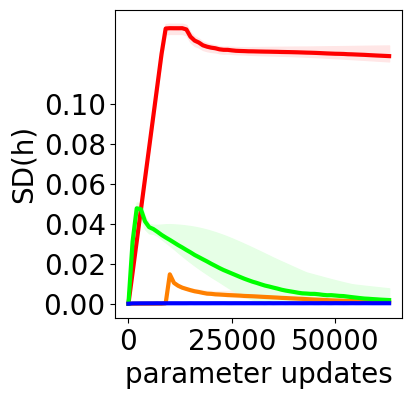

In [61]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(3.7, 4) )
updates_np = depytorch(updates)
line_width = 3.0
for target_thresh, cval in zip(thresh_to_plot, color_to_plot):
    selected_thresh_index = get_closest_match(values=threshold, target=target_thresh)
    selected_threshold = threshold[selected_thresh_index]
    h_std_min_series_at_thresh = h_std_min_series[:,selected_thresh_index]
    h_std_median_series_at_thresh = h_std_median_series[:,selected_thresh_index]
    h_std_max_series_at_thresh = h_std_max_series[:,selected_thresh_index]
    axs.fill_between( updates_np, depytorch(h_std_min_series_at_thresh), depytorch(h_std_max_series_at_thresh), color=[0.9+0.1*c for c in cval] )
    axs.plot( updates_np, depytorch(h_std_median_series_at_thresh), color=cval, linewidth=line_width, label=f'threshold={selected_threshold:.3g}' )
# axs.legend(loc='center', bbox_to_anchor=legend_loc)
axs.set_yticks( np.arange(0.0, 0.11, 0.02) )
axs.set_xlabel('parameter updates')
axs.set_ylabel('SD(h)')
plt.show()

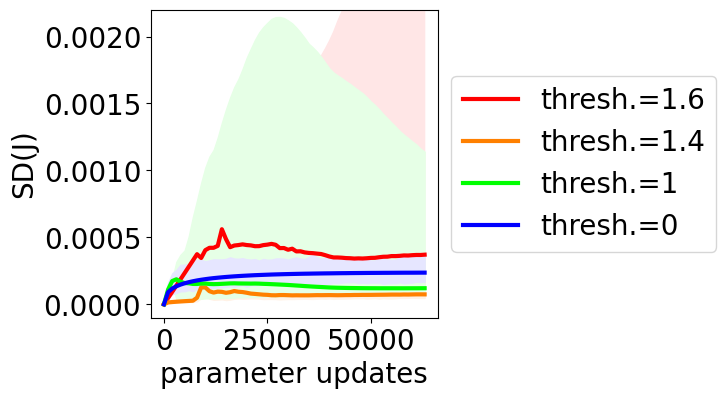

In [63]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(3.7, 4) )
updates_np = depytorch(updates)
line_width = 3.0
for target_thresh, cval in zip(thresh_to_plot, color_to_plot):
    selected_thresh_index = get_closest_match(values=threshold, target=target_thresh)
    selected_threshold = threshold[selected_thresh_index]
    J_std_min_series_at_thresh = J_std_min_series[:,selected_thresh_index]
    J_std_median_series_at_thresh = J_std_median_series[:,selected_thresh_index]
    J_std_max_series_at_thresh = J_std_max_series[:,selected_thresh_index]
    axs.fill_between( updates_np, depytorch(J_std_min_series_at_thresh), depytorch(J_std_max_series_at_thresh), color=[0.9+0.1*c for c in cval] )
    axs.plot( updates_np, depytorch(J_std_median_series_at_thresh), color=cval, linewidth=line_width, label=f'thresh.={selected_threshold:.3g}' )
legend_loc = [1.51, 0.5, 0.0, 0.0]
axs.legend(loc='center', bbox_to_anchor=legend_loc)
axs.set_ylim([-0.0001, 0.0022])
# axs.set_xticks( np.arange(0, 2, 0.5) )
axs.set_xlabel('parameter updates')
axs.set_ylabel('SD(J)')
plt.show()

In [ ]:
thresh_to_plot = [1.5, 1.4, 1.0, 0.0]
color_to_plot = [red_cval, orange_cval, green_cval, blue_cval]
legend_loc = [1.5, 0.5, 0.0, 0.0]

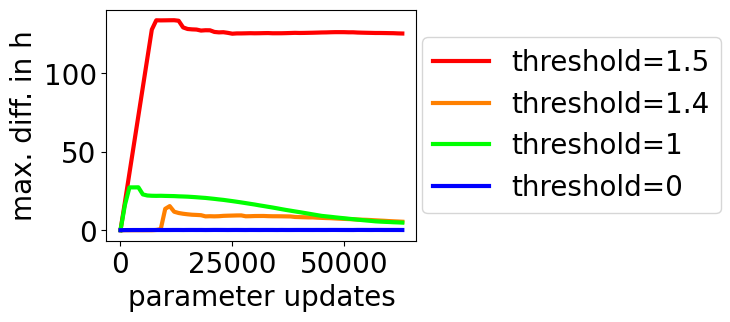

In [178]:
h_min_series = h_stats_series[:,:,:,0]
h_median_series = h_stats_series[:,:,:,1]
h_max_series = h_stats_series[:,:,:,2]
h_discrepancy = h_max_series - h_min_series
h_max_discrepancy_over_nodes, h_max_discrepancy_node_index_all = torch.max(h_discrepancy, dim=-1)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 3) )
updates_np = depytorch(updates)
line_width = 3.0
for target_thresh, cval in zip(thresh_to_plot, color_to_plot):
    selected_thresh_index = get_closest_match(values=threshold, target=target_thresh)
    selected_threshold = threshold[selected_thresh_index]
    # axs.fill_between( updates_np, depytorch(J_std_min_series_at_thresh), depytorch(J_std_max_series_at_thresh), color=[0.9+0.1*c for c in cval] )
    axs.plot( updates_np, depytorch(h_max_discrepancy_over_nodes[:,selected_thresh_index]), color=cval, linewidth=line_width, label=f'threshold={selected_threshold:.3g}' )
axs.legend(loc='center', bbox_to_anchor=legend_loc)
# axs.set_xticks( np.arange(0, 2, 0.5) )
axs.set_xlabel('parameter updates')
axs.set_ylabel('max. diff. in h')
plt.show()

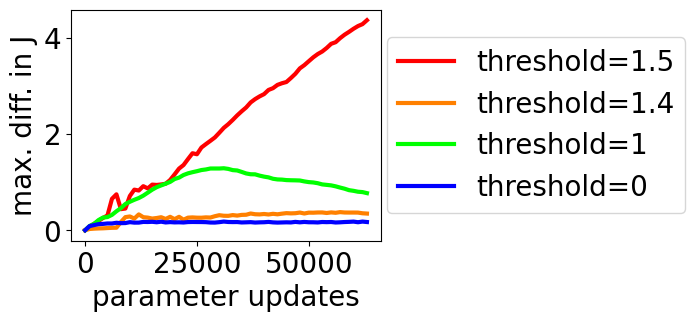

In [179]:
J_min_series = J_stats_series[:,:,:,0]
J_median_series = J_stats_series[:,:,:,1]
J_max_series = J_stats_series[:,:,:,2]
J_discrepancy = J_max_series - J_min_series
J_max_discrepancy_over_nodes, J_max_discrepancy_node_index_all = torch.max(J_discrepancy, dim=-1)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 3) )
updates_np = depytorch(updates)
line_width = 3.0
for target_thresh, cval in zip(thresh_to_plot, color_to_plot):
    selected_thresh_index = get_closest_match(values=threshold, target=target_thresh)
    selected_threshold = threshold[selected_thresh_index]
    # axs.fill_between( updates_np, depytorch(J_std_min_series_at_thresh), depytorch(J_std_max_series_at_thresh), color=[0.9+0.1*c for c in cval] )
    axs.plot( updates_np, depytorch(J_max_discrepancy_over_nodes[:,selected_thresh_index]), color=cval, linewidth=line_width, label=f'threshold={selected_threshold:.3g}' )
axs.legend(loc='center', bbox_to_anchor=legend_loc)
# axs.set_xticks( np.arange(0, 2, 0.5) )
axs.set_xlabel('parameter updates')
axs.set_ylabel('max. diff. in J')
plt.show()

In [185]:
thresh_to_plot = [1.5, 1.0, 0.0]
color_to_plot = [red_cval, green_cval, blue_cval]
legend_loc = [1.5, 0.5, 0.0, 0.0]

In [181]:
def plot_param_range(param_stats_series:torch.Tensor, param_name:str):
    h_min_series = param_stats_series[:,:,:,0]
    h_median_series = param_stats_series[:,:,:,1]
    h_max_series = param_stats_series[:,:,:,2]
    h_discrepancy = h_max_series - h_min_series
    h_max_discrepancy_over_updates, h_max_discrepancy_update_index_all = torch.max(h_discrepancy, dim=0)
    h_max_discrepancy_over_nodes, h_max_discrepancy_node_index_all = torch.max(h_max_discrepancy_over_updates, dim=-1)
    fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 3) )
    updates_np = depytorch(updates)
    line_width = 3.0
    for target_thresh, cval in zip(thresh_to_plot, color_to_plot):
        selected_thresh_index = get_closest_match(values=threshold, target=target_thresh)
        selected_threshold = threshold[selected_thresh_index]
        selected_node_index = h_max_discrepancy_node_index_all[selected_thresh_index]
        selected_h_min = h_min_series[:,selected_thresh_index,selected_node_index]
        selected_h_median = h_median_series[:,selected_thresh_index,selected_node_index]
        selected_h_max = h_max_series[:,selected_thresh_index,selected_node_index]
        axs.fill_between( updates_np, depytorch(selected_h_min), depytorch(selected_h_max), color=[0.9+0.1*c for c in cval] )
        axs.plot( updates_np, depytorch(selected_h_median), color=cval, linewidth=line_width, label=f'threshold={selected_threshold:.3g}' )
    axs.legend(loc='center', bbox_to_anchor=legend_loc)
    # axs.set_xticks( np.arange(0, 2, 0.5) )
    axs.set_xlabel('parameter updates')
    axs.set_ylabel(param_name)
    plt.show()

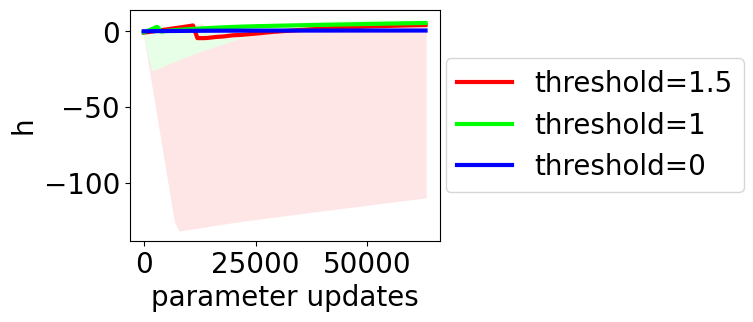

In [186]:
plot_param_range(param_stats_series=h_stats_series, param_name='h')

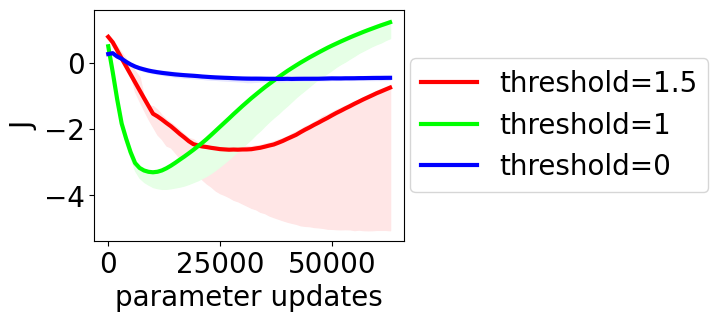

In [187]:
plot_param_range(param_stats_series=J_stats_series, param_name='J')

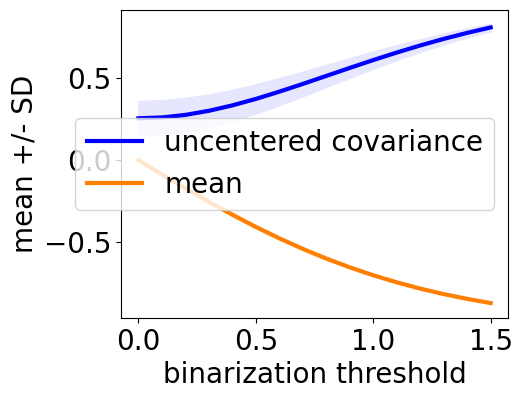

In [51]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
end_thresh = get_closest_match(values=threshold, target=1.6)
threshold_np = depytorch(threshold[:end_thresh])
line_width = 3.0

cval = blue_cval
axs.fill_between( threshold_np, depytorch(mean_state_product_group_below_std[:end_thresh]), depytorch(mean_state_product_group_above_std[:end_thresh]), color=[0.9+0.1*c for c in cval])
axs.plot( threshold_np, depytorch(mean_state_product_group_mean[:end_thresh]), color=cval, linewidth=line_width, label=f'uncentered covariance' )

cval = orange_cval
axs.fill_between( threshold_np, depytorch(mean_state_group_below_std[:end_thresh]), depytorch(mean_state_group_above_std[:end_thresh]), color=[0.9+0.1*c for c in cval])
axs.plot( threshold_np, depytorch(mean_state_group_mean[:end_thresh]), color=cval, linewidth=line_width, label=f'mean' )

axs.legend()
axs.set_xticks( np.arange(0, 2, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('mean +/- SD')
plt.show()

In [50]:
mean_state_group_std, mean_state_group_mean = torch.std_mean( mean_state_group, dim=1 )
mean_state_group_below_std = mean_state_group_mean - mean_state_group_std
mean_state_group_above_std = mean_state_group_mean + mean_state_group_std

In [53]:
max_sd_h, max_sd_h_index = torch.max(group_h_std, dim=-1)
max_sd_h_thresh = threshold[max_sd_h_index]
print(f'The largest SD of group model h is {max_sd_h:.3g}, occurs at threshold {max_sd_h_thresh:.3g}.')

The largest SD of group model h is 0.0303, occurs at threshold 0.5.


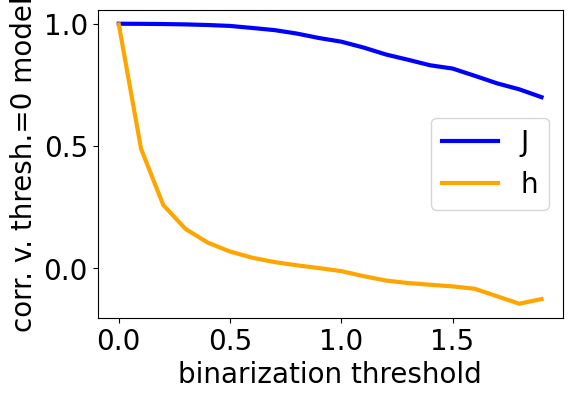

In [34]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 4) )
end_thresh = get_closest_match(values=threshold, target=2.0)
threshold_np = depytorch(threshold[:end_thresh])
line_width = 3.0

axs.plot( threshold_np, depytorch(group_J_corr_with_0[:end_thresh]), color='blue', linewidth=line_width, label=f'J' )
axs.plot( threshold_np, depytorch(group_h_corr_with_0[:end_thresh]), color='orange', linewidth=line_width, label=f'h' )

axs.legend()
axs.set_xlabel('binarization threshold')
axs.set_ylabel('corr. v. thresh.=0 model')
plt.show()

In [54]:
index_of_one = get_closest_match(values=threshold, target=1.0)

In [55]:
group_h_corr_with_1 = isingmodellight.get_pairwise_correlation( mat1=group_h_rep_mean, mat2=group_h_rep_mean[index_of_one,:].unsqueeze(dim=0), epsilon=0.0, dim=-1 )

In [56]:
group_J_corr_with_1 = isingmodellight.get_pairwise_correlation( mat1=group_J_rep_mean, mat2=group_J_rep_mean[index_of_one,:].unsqueeze(dim=0), epsilon=0.0, dim=-1 )

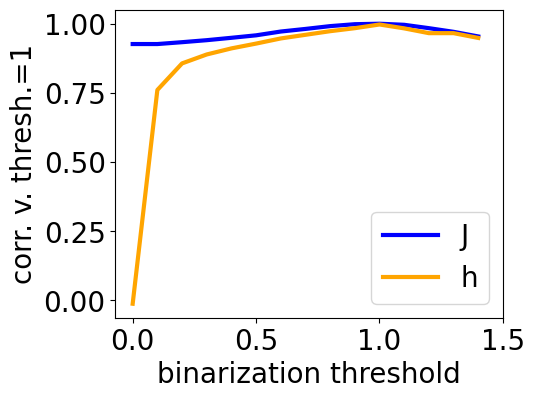

In [57]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
end_thresh = get_closest_match(values=threshold, target=1.5)
threshold_np = depytorch(threshold[:end_thresh])
line_width = 3.0

axs.plot( threshold_np, depytorch(group_J_corr_with_1[:end_thresh]), color='blue', linewidth=line_width, label=f'J' )
axs.plot( threshold_np, depytorch(group_h_corr_with_1[:end_thresh]), color='orange', linewidth=line_width, label=f'h' )

axs.legend()
axs.set_xticks( np.arange(0, 2, 0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('corr. v. thresh.=1')
plt.show()

In [58]:
print( group_J_corr_with_1[:end_thresh].min().item(), group_h_corr_with_1[0:end_thresh].min().item() )

0.9265413880348206 -0.01177183911204338


In [94]:
index_of_two = get_closest_match(values=threshold, target=2.0)

In [95]:
group_h_corr_with_2 = isingmodellight.get_pairwise_correlation( mat1=group_h_rep_mean, mat2=group_h_rep_mean[index_of_two,:].unsqueeze(dim=0), epsilon=0.0, dim=-1 )

In [96]:
group_J_corr_with_2 = isingmodellight.get_pairwise_correlation( mat1=group_J_rep_mean, mat2=group_J_rep_mean[index_of_two,:].unsqueeze(dim=0), epsilon=0.0, dim=-1 )

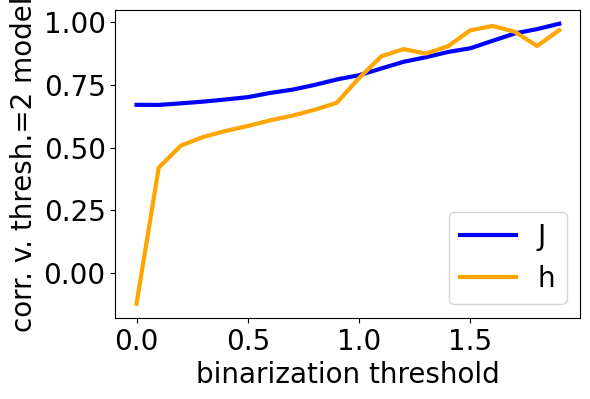

In [97]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 4) )
end_thresh = get_closest_match(values=threshold, target=2.0)
threshold_np = depytorch(threshold[:end_thresh])
line_width = 3.0

axs.plot( threshold_np, depytorch(group_J_corr_with_2[:end_thresh]), color='blue', linewidth=line_width, label=f'J' )
axs.plot( threshold_np, depytorch(group_h_corr_with_2[:end_thresh]), color='orange', linewidth=line_width, label=f'h' )

axs.legend()
axs.set_xlabel('binarization threshold')
axs.set_ylabel('corr. v. thresh.=2 model')
plt.show()

group h, threshold=1=-0.0524group h, threshold=0+-0.0108, R^2=0.000139


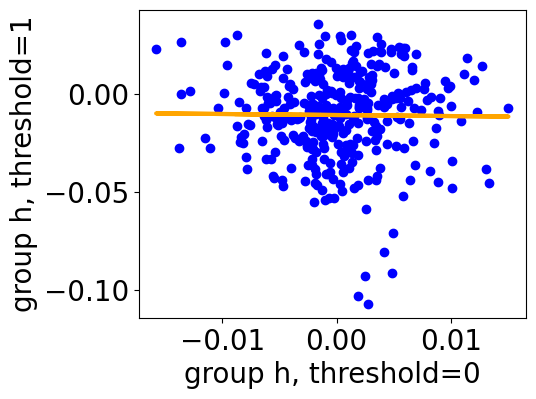

In [55]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line( ax, feature=group_h_rep_mean[0,:], param=group_h_rep_mean[index_of_one,:], feature_name='group h, threshold=0', param_name='group h, threshold=1' )

In [120]:
get_correlation_and_p( feature=group_h_rep_mean[0,:], param=group_h_rep_mean[index_of_one,:], feature_name='group h, threshold=0', param_name='group h, threshold=1', num_perms=1000000 )

group h, threshold=1 v. group h, threshold=0 corr.=-0.0118, p-value=0.823


(tensor(-0.0118, device='cuda:0'), tensor(0.8230, device='cuda:0'))

group J, threshold=1=0.785group J, threshold=0+0.0012, R^2=0.859


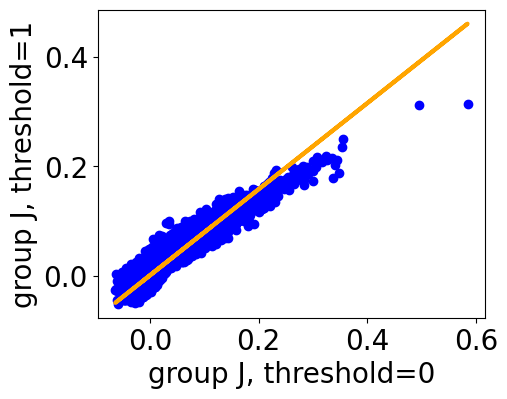

In [57]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line( ax, feature=group_J_rep_mean[0,:], param=group_J_rep_mean[index_of_one,:], feature_name='group J, threshold=0', param_name='group J, threshold=1' )

In [119]:
get_correlation_and_p( feature=group_J_rep_mean[0,:], param=group_J_rep_mean[index_of_one,:], feature_name='group J, threshold=0', param_name='group J, threshold=1', num_perms=1000000 )

group J, threshold=1 v. group J, threshold=0 corr.=0.927, p-value=0


(tensor(0.9266, device='cuda:0'), tensor(0., device='cuda:0'))

In [61]:
def find_proportions_of_rep_variance(A:torch.Tensor):
    A = torch.transpose(A, dim0=0, dim1=1)# transpose so that replicas are observations and subjects/thresholds are batches
    num_targets, num_reps, num_nodes = A.size()
    rank = min(num_reps, num_nodes)
    var_A, _ = A.var(dim=1).sort(descending=True)
    total_var_A = var_A.sum(dim=-1, keepdim=True)
    proportion_of_var_A = torch.cumsum(var_A, dim=-1)/total_var_A
    (U, S, V) = torch.pca_lowrank(A, q=rank, center=True, niter=100)
    var_pc, _ = ( S.square()/(num_reps-1) ).sort(descending=True)
    proportion_of_var_pc = torch.cumsum(var_pc, dim=-1)/total_var_A
    return proportion_of_var_A, proportion_of_var_pc

In [62]:
proportion_of_var_group_h, proportion_of_var_pc_group_h = find_proportions_of_rep_variance(group_h)

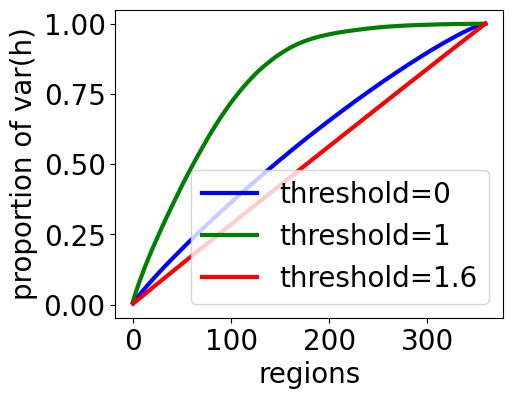

In [116]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
node_ranks_np = depytorch(  torch.arange( proportion_of_var_group_h.size(dim=-1), dtype=float_type, device=device )  )
line_width = 3.0

for target_thresh, thresh_color in zip([0.0, 1.0, 1.6],['blue', 'green', 'red']):
    selected_thresh = get_closest_match(values=threshold, target=target_thresh)
    axs.plot( node_ranks_np, depytorch(proportion_of_var_group_h[selected_thresh,:]), color=thresh_color, linewidth=line_width, label=f'threshold={target_thresh:.3g}' )

axs.legend()
axs.set_xlabel('regions')
axs.set_ylabel('proportion of var(h)')
plt.show()

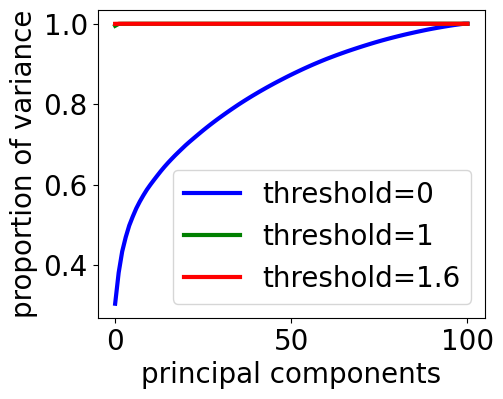

In [115]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
pc_ranks_np = depytorch(  torch.arange( proportion_of_var_pc_group_h.size(dim=-1), dtype=float_type, device=device )  )
line_width = 3.0

for target_thresh, thresh_color in zip([0.0, 1.0, 1.6],['blue', 'green', 'red']):
    selected_thresh = get_closest_match(values=threshold, target=target_thresh)
    axs.plot( pc_ranks_np, depytorch(proportion_of_var_pc_group_h[selected_thresh,:]), color=thresh_color, linewidth=line_width, label=f'threshold={target_thresh:.3g}' )

axs.legend()
axs.set_xlabel('principal components')
axs.set_ylabel('proportion of variance')
plt.show()

In [66]:
proportion_of_var_group_J, proportion_of_var_pc_group_J = find_proportions_of_rep_variance(group_J)

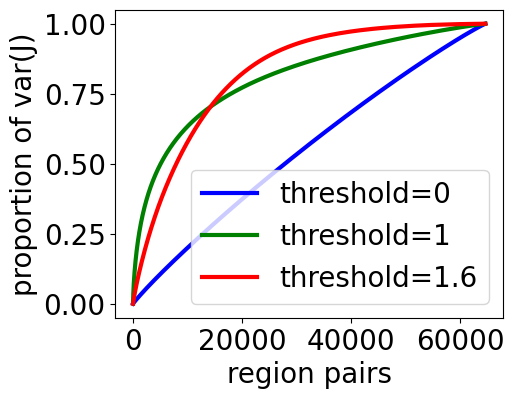

In [117]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
edge_ranks_np = depytorch(  torch.arange( proportion_of_var_group_J.size(dim=-1), dtype=float_type, device=device )  )
line_width = 3.0

for target_thresh, thresh_color in zip([0.0, 1.0, 1.6],['blue', 'green', 'red']):
    selected_thresh = get_closest_match(values=threshold, target=target_thresh)
    axs.plot( edge_ranks_np, depytorch(proportion_of_var_group_J[selected_thresh,:]), color=thresh_color, linewidth=line_width, label=f'threshold={target_thresh:.3g}' )

axs.legend()
axs.set_xlabel('region pairs')
axs.set_ylabel('proportion of var(J)')
plt.show()

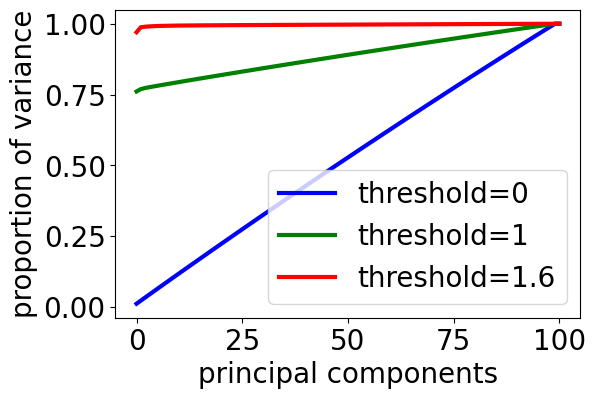

In [83]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 4) )
pc_ranks_np = depytorch(  torch.arange( proportion_of_var_pc_group_J.size(dim=-1), dtype=float_type, device=device )  )
line_width = 3.0

for target_thresh, thresh_color in zip([0.0, 1.0, 1.6],['blue', 'green', 'red']):
    selected_thresh = get_closest_match(values=threshold, target=target_thresh)
    axs.plot( pc_ranks_np, depytorch(proportion_of_var_pc_group_J[selected_thresh,:]), color=thresh_color, linewidth=line_width, label=f'threshold={target_thresh:.3g}' )

axs.legend()
axs.set_xlabel('principal components')
axs.set_ylabel('proportion of variance')
plt.show()

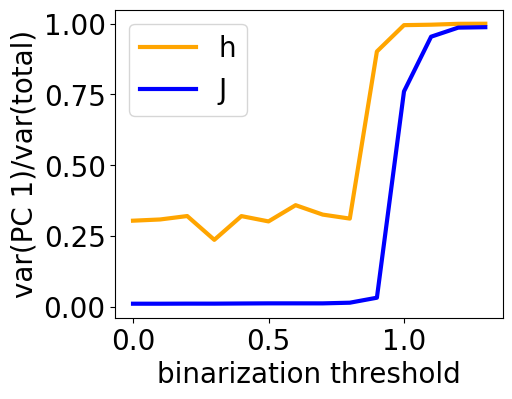

In [73]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
end_thresh_target = 1.4
end_thresh = get_closest_match(values=threshold, target=end_thresh_target)
threshold_np = depytorch(threshold[:end_thresh])
line_width = 3.0

axs.plot( threshold_np, depytorch(proportion_of_var_pc_group_h[:end_thresh,0]), color='orange', linewidth=line_width, label=f'h' )
axs.plot( threshold_np, depytorch(proportion_of_var_pc_group_J[:end_thresh,0]), color='blue', linewidth=line_width, label=f'J' )

axs.legend()
axs.set_xticks( np.arange(0,end_thresh_target,0.5) )
axs.set_xlabel('binarization threshold')
axs.set_ylabel('var(PC 1)/var(total)')
plt.show()

torch.Size([31, 101])


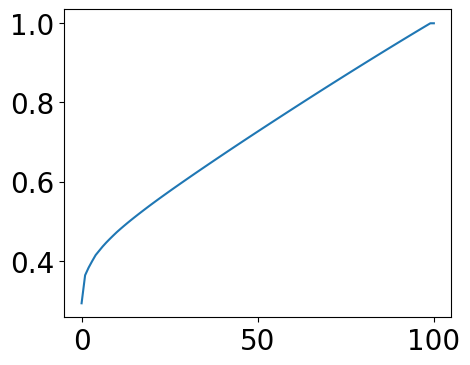

In [72]:
print( proportion_of_var_pc_group_J.size() )
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
axs.plot( depytorch(proportion_of_var_pc_group_J[14,:]) )

In [23]:
num_beta = 101
min_beta = 1e-10
max_beta = 0.05
num_threshold = 31
min_threshold = 0.0
max_threshold = 3.0
min_updates = 0
max_updates = 40000
update_increment = 1000
threshold = torch.linspace(start=min_threshold, end=3, steps=num_threshold, dtype=float_type, device=device)
blue_thresh = get_closest_match(values=threshold, target=0.0)
green_thresh = get_closest_match(values=threshold, target=1.0)
orange_thresh = get_closest_match(values=threshold, target=1.5)
# red_thresh = get_closest_match(values=threshold, target=2.4)
red_thresh = get_closest_match(values=threshold, target=1.6)
base_color_amplitude = 1.0
red_cval = [base_color_amplitude, 0.0, 0.0]
orange_cval = [base_color_amplitude, base_color_amplitude*0.5, 0.0]
green_cval = [0.0, base_color_amplitude, 0.0]
blue_cval = [0.0, 0.0, base_color_amplitude]
data_string = f'thresholds_{num_threshold}_min_{min_threshold:.3g}_max_{max_threshold:.3g}'
param_string = f'light_group_{data_string}_betas_{num_beta}_min_{min_beta:.3g}_max_{max_beta}_steps_1200_lr_0.01_beta_updates_8'
param_string_final = f'{param_string}_param_updates_{max_updates}'
test_string_final = f'{param_string}_param_updates_{max_updates}_test_length_120000'

In [16]:
ising_model_file = os.path.join(other_file_dir, f'ising_model_{param_string}.pt')
model = torch.load(ising_model_file, weights_only=False)
print( 'h size', model.h.size() )
print( 'J size', model.J.size() )

h size torch.Size([101, 31, 360])
J size torch.Size([101, 31, 360, 360])


In [21]:
test_beta_min = 1e-09
test_beta_max = 0.025
num_test_beta = num_beta
fc_corr_beta_test_file = os.path.join(other_file_dir, f'fc_corr_{param_string}_test_beta_min_{test_beta_min:.3g}_max_{test_beta_max:.3g}_sim_steps_120000.pt')
fc_corr_beta_test = torch.load(fc_corr_beta_test_file, weights_only=False)
print( fc_corr_beta_test.size() )
test_beta = torch.linspace(start=test_beta_min, end=test_beta_max, steps=num_test_beta, dtype=fc_corr_beta_test.dtype, device=fc_corr_beta_test.device)

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Ising_model_results_daai\\fc_corr_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_test_beta_min_1e-09_max_0.025_sim_steps_120000.pt'

In [24]:
fc_corr_summary_file = os.path.join(file_dir, f'summary_fc_corr_all_ising_model_{param_string}_param_updates_updates_min_{min_updates}_max_{max_updates}_increment_{update_increment}.pt')
fc_corr_summary = torch.load(fc_corr_summary_file, weights_only=False)
print( fc_corr_summary.size() )
num_updates = (max_updates - min_updates)//update_increment + 1
update_count = torch.linspace(start=min_updates, end=max_updates, steps=num_updates, dtype=fc_corr_summary.dtype, device=fc_corr_summary.device)

torch.Size([41, 31, 5])


In [25]:
fc_corr_final_file = os.path.join(file_dir, f'fc_corr_ising_model_{test_string_final}.pt')
fc_corr_final = torch.load(fc_corr_final_file, weights_only=False)
print( fc_corr_final.size() )

torch.Size([101, 31])


In [26]:
threshold_in_range = threshold <= 1.0
fc_corr_final_in_range = fc_corr_final[:,threshold_in_range]
worst_median_fc_corr = torch.min( torch.median(fc_corr_final_in_range, dim=0).values )
print(f'worst median FC correlation {worst_median_fc_corr:.3g}')
print(f'range of FC correlations {fc_corr_final_in_range.min():.3g}, {fc_corr_final_in_range.max():.3g}')

worst median FC correlation 0.982
range of FC correlations 0.943, 0.999


In [27]:
fc_corr_final_min = fc_corr_final.min(dim=0).values
fc_corr_final_median = fc_corr_final.median(dim=0).values
fc_corr_final_max = fc_corr_final.min(dim=0).values
fc_corr_is_acceptable = fc_corr_final_median >= 0.75
acceptable_threshold = threshold[fc_corr_is_acceptable]
print( f'last threshold that produces good enough FC correlation {acceptable_threshold[-1]:.3g}' )

last threshold that produces good enough FC correlation 1.5


In [28]:
fc_corr_homogenized_h_file = os.path.join(file_dir, f'fc_corr_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000h_mean_area_test_length_120000.pt')
fc_corr_homogenized_h = torch.load(fc_corr_homogenized_h_file, weights_only=False)
print( fc_corr_homogenized_h.size() )

torch.Size([101, 31])


In [29]:
fc_corr_v_as_is_file = os.path.join(file_dir, f'fc_corr_group_thresholds_31_min_0_max_3_as_is_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_test_length_120000.pt')
fc_corr_v_as_is = torch.load(fc_corr_v_as_is_file, weights_only=False)
print( fc_corr_v_as_is.size() )

torch.Size([101, 31])


In [30]:
selected_indices = [blue_thresh, green_thresh, red_thresh]
selected_colors = [blue_cval, green_cval, red_cval]

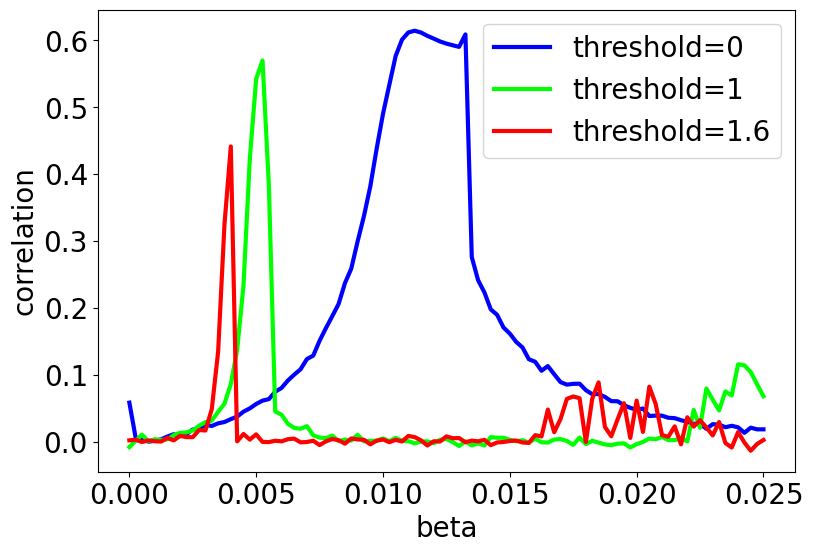

In [23]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
test_beta_np = depytorch(test_beta)
fc_corr_beta_test_np = depytorch(fc_corr_beta_test)
line_width = 3.0
max_beta_index = num_beta
# max_beta_index = torch.argmin( torch.abs(test_beta - 0.02) )
for threshold_index, cval in zip(selected_indices,selected_colors):
    axs.plot( test_beta_np[:max_beta_index], fc_corr_beta_test_np[:max_beta_index,threshold_index], color=cval, linewidth=line_width, label=f'threshold={threshold[threshold_index]:.3g}' )
axs.set_xlabel('beta')
axs.set_ylabel('correlation')
axs.legend()
plt.show()

In [31]:
test_beta_min = 1e-09
test_beta_max = 0.025
num_test_beta = num_beta
fc_corr_beta_test_aal_file = os.path.join(other_file_dir, f'fc_corr_{param_string}_test_beta_min_{test_beta_min:.3g}_max_{test_beta_max:.3g}_sim_steps_120000.pt')
fc_corr_beta_test_aal = torch.load(fc_corr_beta_test_aal_file, weights_only=False)
print( fc_corr_beta_test_aal.size() )
test_beta = torch.linspace(start=test_beta_min, end=test_beta_max, steps=num_test_beta, dtype=fc_corr_beta_test.dtype, device=fc_corr_beta_test.device)

torch.Size([101, 31])


NameError: name 'fc_corr_beta_test' is not defined

In [24]:
fc_corr_is_nan = torch.isnan(fc_corr_beta_test)
fc_corr_is_inf = torch.isinf(fc_corr_beta_test)
fc_corr_is_bad = torch.logical_or(fc_corr_is_nan, fc_corr_is_inf)
fc_corr_beta_test[fc_corr_is_bad] = -float('inf')
max_fc_corr, max_fc_corr_index = torch.max(fc_corr_beta_test[1:,:], dim=0)
max_fc_corr_index = max_fc_corr_index+1
max_fc_corr_beta = test_beta[max_fc_corr_index]
for threshold_index in selected_indices:
    print(f'For threshold {threshold[threshold_index]:.3g}, maximum FC correlation {max_fc_corr[threshold_index]:.3g} occurs at beta {max_fc_corr_beta[threshold_index]:.3g}.')

For threshold 0, maximum FC correlation 0.614 occurs at beta 0.0113.
For threshold 1, maximum FC correlation 0.57 occurs at beta 0.00525.
For threshold 1.6, maximum FC correlation 0.441 occurs at beta 0.004.


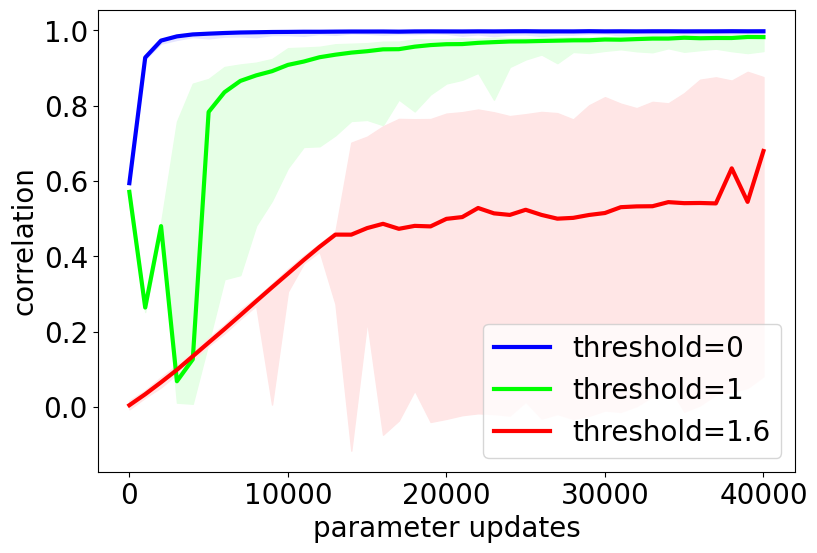

In [27]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
update_count_np = depytorch(update_count)
fc_corr_min_np = depytorch(fc_corr_summary[:,:,min_col])
fc_corr_median_np = depytorch(fc_corr_summary[:,:,median_col])
fc_corr_max_np = depytorch(fc_corr_summary[:,:,max_col])
line_width = 3.0
for threshold_index, cval in zip(selected_indices,selected_colors):
    fc_corr_min_for_thresh = fc_corr_min_np[:,threshold_index]
    fc_corr_max_for_thresh = fc_corr_max_np[:,threshold_index]
    selected_threshold = threshold[threshold_index]
    if (fc_corr_max_for_thresh - fc_corr_min_for_thresh).max() > 0.001:
        axs.fill_between( update_count_np, fc_corr_min_for_thresh, fc_corr_max_for_thresh, color=[0.9+0.1*c for c in cval])# , label=f'thresh.={selected_threshold:.3g} range'
        # axs.plot( update_count_np, fc_corr_min_for_thresh, color=cval, linestyle='--', linewidth=line_width )
        # axs.plot( update_count_np, fc_corr_max_for_thresh, color=cval, linestyle='--', linewidth=line_width )
    axs.plot( update_count_np, fc_corr_median_np[:,threshold_index], color=cval, linewidth=line_width, label=f'threshold={selected_threshold:.3g}' )# , label=f'thresh.={selected_threshold:.3g} median'
axs.legend( loc='lower right' )# , bbox_to_anchor=(1.46, 0.5)
axs.set_xlabel('parameter updates')
axs.set_ylabel('correlation')
plt.show()

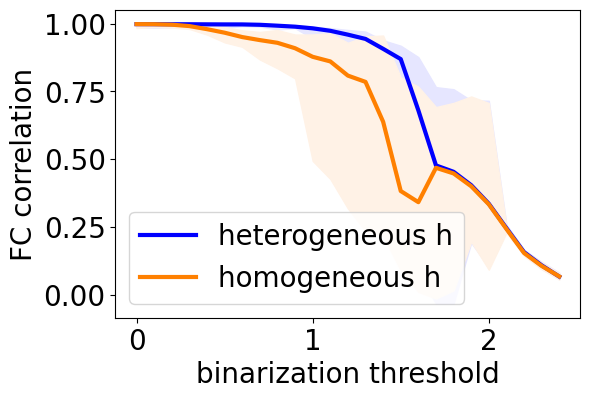

In [33]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 4) )
end_thresh = get_closest_match(values=threshold, target=2.5)
threshold_np = depytorch(threshold[:end_thresh])
line_width = 3.0

fc_corr_min_final = depytorch(fc_corr_summary[-1,:end_thresh,min_col])
fc_corr_max_final = depytorch(fc_corr_summary[-1,:end_thresh,max_col])
fc_corr_median_final = depytorch(fc_corr_summary[-1,:end_thresh,median_col])

cval = blue_cval
axs.fill_between( threshold_np, fc_corr_min_final, fc_corr_max_final, color=[0.9+0.1*c for c in cval])
# axs.plot( threshold_np, fc_corr_min_final, color=cval, linestyle='--', linewidth=line_width )
# axs.plot( threshold_np, fc_corr_max_final, color=cval, linestyle='--', linewidth=line_width )
axs.plot( threshold_np, fc_corr_median_final, color=cval, linewidth=line_width, label=f'heterogeneous h' )

fc_corr_hom_h_min_final = depytorch( fc_corr_homogenized_h[:,:end_thresh].min(dim=0).values )
fc_corr_hom_h_max_final = depytorch( fc_corr_homogenized_h[:,:end_thresh].max(dim=0).values )
fc_corr_hom_h_median_final = depytorch( fc_corr_homogenized_h[:,:end_thresh].median(dim=0).values )

cval = orange_cval
axs.fill_between( threshold_np, fc_corr_hom_h_min_final, fc_corr_hom_h_max_final, color=[0.9+0.1*c for c in cval])
# axs.plot( threshold_np, fc_corr_min_final, color=cval, linestyle='--', linewidth=line_width )
# axs.plot( threshold_np, fc_corr_max_final, color=cval, linestyle='--', linewidth=line_width )
axs.plot( threshold_np, fc_corr_hom_h_median_final, color=cval, linewidth=line_width, label=f'homogeneous h' )

axs.legend()
axs.set_xlabel('binarization threshold')
axs.set_ylabel('FC correlation')
plt.show()

In [38]:
model_param_string_aal = 'group_init_means_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_1_steps_1200_lr_0.01_beta_updates_8_v2_param_updates_40000'
fc_corr_aal = torch.load( os.path.join(file_dir, f'fc_corr_ising_model_light_{model_param_string_aal}_test_length_120000.pt'), weights_only=False )
print( fc_corr_aal.size() )
fc_corr_aal_mean_h = torch.load( os.path.join(file_dir, f'fc_corr_{model_param_string_aal}h_mean_area_test_length_120000.pt'), weights_only=False )
print( fc_corr_aal_mean_h.size() )

torch.Size([101, 31])
torch.Size([101, 31])


In [14]:
def get_mean_state_corr(dir_str:str, data_name_part, sim_name_part:str, mean_scans:bool):
    data_mean_state = torch.load( os.path.join(dir_str, f'mean_state_{data_name_part}.pt'), weights_only=False )
    print( 'loaded data_mean_state', data_mean_state.size() )
    if mean_scans:
        data_mean_state = torch.mean(data_mean_state, dim=0, keepdim=True)
    else:
        data_mean_state = torch.unsqueeze(data_mean_state, dim=0)
    print( 'resized to', data_mean_state.size() )
    sim_mean_state = torch.load( os.path.join(dir_str, f'sim_state_mean_{sim_name_part}.pt'), weights_only=False )
    print( 'loaded sim_mean_state', sim_mean_state.size() )
    mean_state_corr = isingmodellight.get_pairwise_correlation(mat1=data_mean_state, mat2=sim_mean_state, epsilon=0.0, dim=-1)
    print( 'computed mean_state_corr', mean_state_corr.size() )
    return mean_state_corr

In [15]:
def get_mean_state_product_corr(dir_str:str, data_name_part, sim_name_part:str, mean_scans:bool):
    data_mean_state_product = torch.load( os.path.join(dir_str, f'mean_state_product_{data_name_part}.pt'), weights_only=False )
    print( 'loaded data_mean_state_product', data_mean_state_product.size() )
    if mean_scans:
        data_mean_state_product = torch.mean(data_mean_state_product, dim=0, keepdim=True)
    else:
        data_mean_state_product = torch.unsqueeze(data_mean_state_product, dim=0)
    triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=data_mean_state_product.size(dim=-1), device=data_mean_state_product.device )
    data_mean_state_product = data_mean_state_product[:,:,triu_rows,triu_cols]
    print( 'resized to', data_mean_state_product.size() )
    sim_mean_state_product = torch.load( os.path.join(dir_str, f'sim_state_product_mean_{sim_name_part}.pt'), weights_only=False )
    print( 'loaded sim_mean_state_product', sim_mean_state_product.size() )
    sim_mean_state_product = sim_mean_state_product[:,:,triu_rows,triu_cols]
    print( 'resized to', sim_mean_state_product.size() )
    mean_state_product_corr = isingmodellight.get_pairwise_correlation(mat1=data_mean_state_product, mat2=sim_mean_state_product, epsilon=0.0, dim=-1)
    print( 'computed mean_state_product_corr', mean_state_product_corr.size() )
    return mean_state_product_corr

In [16]:
group_dir_str = file_dir
group_data_name_part = 'thresholds_31_min_0_max_3'
group_sim_name_part = 'group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_test_length_120000'
mean_scans_group = False
group_mean_state_corr = get_mean_state_corr(dir_str=group_dir_str, data_name_part=group_data_name_part, sim_name_part=group_sim_name_part, mean_scans=mean_scans_group)
group_mean_state_product_corr = get_mean_state_product_corr(dir_str=group_dir_str, data_name_part=group_data_name_part, sim_name_part=group_sim_name_part, mean_scans=mean_scans_group)

loaded data_mean_state torch.Size([31, 360])
resized to torch.Size([1, 31, 360])
loaded sim_mean_state torch.Size([101, 31, 360])
computed mean_state_corr torch.Size([101, 31])
loaded data_mean_state_product torch.Size([31, 360, 360])
resized to torch.Size([1, 31, 64620])
loaded sim_mean_state_product torch.Size([101, 31, 360, 360])
resized to torch.Size([101, 31, 64620])
computed mean_state_product_corr torch.Size([101, 31])


In [18]:
individual_0_dir_str = other_file_dir
individual_0_data_name_part = 'all_mean_std_0'
individual_0_sim_name_part = 'group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_test_length_120000'
mean_scans_individual_0 = True
individual_0_mean_state_corr = get_mean_state_corr(dir_str=individual_0_dir_str, data_name_part=individual_0_data_name_part, sim_name_part=individual_0_sim_name_part, mean_scans=mean_scans_individual_0)
individual_0_mean_state_product_corr = get_mean_state_product_corr(dir_str=individual_0_dir_str, data_name_part=individual_0_data_name_part, sim_name_part=individual_0_sim_name_part, mean_scans=mean_scans_individual_0)

loaded data_mean_state torch.Size([4, 837, 360])
resized to torch.Size([1, 837, 360])
loaded sim_mean_state torch.Size([5, 837, 360])
computed mean_state_corr torch.Size([5, 837])
loaded data_mean_state_product torch.Size([4, 837, 360, 360])
resized to torch.Size([1, 837, 64620])
loaded sim_mean_state_product torch.Size([5, 837, 360, 360])
resized to torch.Size([5, 837, 64620])
computed mean_state_product_corr torch.Size([5, 837])


In [19]:
individual_1_dir_str = other_file_dir
individual_1_data_name_part = 'all_mean_std_1'
individual_1_sim_name_part = 'group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_test_length_120000'
mean_scans_individual_1 = True
individual_1_mean_state_corr = get_mean_state_corr(dir_str=individual_1_dir_str, data_name_part=individual_1_data_name_part, sim_name_part=individual_1_sim_name_part, mean_scans=mean_scans_individual_1)
individual_1_mean_state_product_corr = get_mean_state_product_corr(dir_str=individual_1_dir_str, data_name_part=individual_1_data_name_part, sim_name_part=individual_1_sim_name_part, mean_scans=mean_scans_individual_1)

loaded data_mean_state torch.Size([4, 837, 360])
resized to torch.Size([1, 837, 360])
loaded sim_mean_state torch.Size([5, 837, 360])
computed mean_state_corr torch.Size([5, 837])
loaded data_mean_state_product torch.Size([4, 837, 360, 360])
resized to torch.Size([1, 837, 64620])
loaded sim_mean_state_product torch.Size([5, 837, 360, 360])
resized to torch.Size([5, 837, 64620])
computed mean_state_product_corr torch.Size([5, 837])


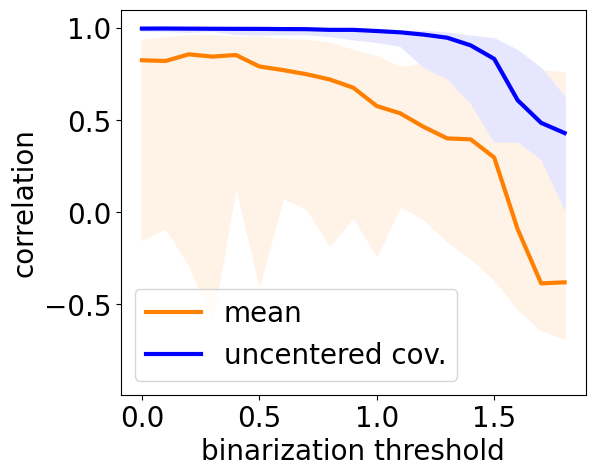

In [37]:
end_thresh_index = get_closest_match(values=threshold, target=1.9)
threshold_np = depytorch(threshold[:end_thresh_index])
group_mean_state_corr_min = depytorch( group_mean_state_corr.min(dim=0).values[:end_thresh_index] )
group_mean_state_corr_median = depytorch( group_mean_state_corr.median(dim=0).values[:end_thresh_index] )
group_mean_state_corr_max = depytorch( group_mean_state_corr.max(dim=0).values[:end_thresh_index] )
group_mean_state_product_corr_min = depytorch( group_mean_state_product_corr.min(dim=0).values[:end_thresh_index] )
group_mean_state_product_corr_median = depytorch( group_mean_state_product_corr.median(dim=0).values[:end_thresh_index] )
group_mean_state_product_corr_max = depytorch( group_mean_state_product_corr.max(dim=0).values[:end_thresh_index] )

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 5) )
line_width = 3.0

cval = orange_cval
axs.fill_between( threshold_np, group_mean_state_corr_min, group_mean_state_corr_max, color=[0.9+0.1*c for c in cval])
axs.plot(threshold_np, group_mean_state_corr_median, color=cval, linewidth=line_width, label=f'mean')

cval = blue_cval
axs.fill_between( threshold_np, group_mean_state_product_corr_min, group_mean_state_product_corr_max, color=[0.9+0.1*c for c in cval])
axs.plot(threshold_np, group_mean_state_product_corr_median, color=cval, linewidth=line_width, label=f'uncentered cov.')

axs.set_ylim([-0.99, 1.1])

axs.legend()
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
plt.show()

In [39]:
group_mean_state_corr_min = group_mean_state_corr.min(dim=0).values
group_mean_state_corr_median = group_mean_state_corr.median(dim=0).values
group_mean_state_corr_max = group_mean_state_corr.max(dim=0).values
print( torch.stack( (threshold, group_mean_state_corr_min, group_mean_state_corr_median, group_mean_state_corr_max ), dim=-1 ) )

tensor([[ 0.0000, -0.1485,  0.8258,  0.9353],
        [ 0.1000, -0.0849,  0.8217,  0.9495],
        [ 0.2000, -0.2838,  0.8580,  0.9597],
        [ 0.3000, -0.5869,  0.8454,  0.9604],
        [ 0.4000,  0.1473,  0.8542,  0.9526],
        [ 0.5000, -0.3958,  0.7920,  0.9532],
        [ 0.6000,  0.0776,  0.7725,  0.9414],
        [ 0.7000,  0.0210,  0.7501,  0.9365],
        [ 0.8000, -0.1788,  0.7213,  0.9198],
        [ 0.9000, -0.0279,  0.6767,  0.8808],
        [ 1.0000, -0.2328,  0.5772,  0.8471],
        [ 1.1000,  0.0330,  0.5375,  0.7869],
        [ 1.2000, -0.0373,  0.4638,  0.8071],
        [ 1.3000, -0.1567,  0.4015,  0.7832],
        [ 1.4000, -0.2506,  0.3962,  0.8103],
        [ 1.5000, -0.3640,  0.2979,  0.8042],
        [ 1.6000, -0.5233, -0.0918,  0.8060],
        [ 1.7000, -0.6404, -0.3855,  0.7698],
        [ 1.8000, -0.6824, -0.3798,  0.7602],
        [ 1.9000, -0.6540, -0.1781,  0.8177],
        [ 2.0000, -0.7789,  0.1291,  0.8463],
        [ 2.1000,  0.3511,  0.4133

In [40]:
group_mean_state_product_corr_min = group_mean_state_product_corr.min(dim=0).values
group_mean_state_product_corr_median = group_mean_state_product_corr.median(dim=0).values
group_mean_state_product_corr_max = group_mean_state_product_corr.max(dim=0).values
print( torch.stack( (threshold, group_mean_state_product_corr_min, group_mean_state_product_corr_median, group_mean_state_product_corr_max ), dim=-1 ) )

tensor([[0.0000e+00, 9.8698e-01, 9.9756e-01, 9.9910e-01],
        [1.0000e-01, 9.8580e-01, 9.9794e-01, 9.9924e-01],
        [2.0000e-01, 9.8083e-01, 9.9723e-01, 9.9900e-01],
        [3.0000e-01, 9.8632e-01, 9.9665e-01, 9.9904e-01],
        [4.0000e-01, 9.6874e-01, 9.9618e-01, 9.9868e-01],
        [5.0000e-01, 9.6631e-01, 9.9593e-01, 9.9887e-01],
        [6.0000e-01, 9.6774e-01, 9.9498e-01, 9.9835e-01],
        [7.0000e-01, 9.6784e-01, 9.9447e-01, 9.9789e-01],
        [8.0000e-01, 9.5731e-01, 9.9069e-01, 9.9656e-01],
        [9.0000e-01, 9.4031e-01, 9.9073e-01, 9.9531e-01],
        [1.0000e+00, 9.2594e-01, 9.8436e-01, 9.9348e-01],
        [1.1000e+00, 9.0453e-01, 9.7725e-01, 9.8801e-01],
        [1.2000e+00, 7.8914e-01, 9.6479e-01, 9.8417e-01],
        [1.3000e+00, 7.2874e-01, 9.4804e-01, 9.7509e-01],
        [1.4000e+00, 5.9433e-01, 9.0650e-01, 9.5833e-01],
        [1.5000e+00, 3.8406e-01, 8.3337e-01, 9.4446e-01],
        [1.6000e+00, 3.8514e-01, 6.0855e-01, 8.7921e-01],
        [1.700

In [45]:
def get_mean_state_rmse(dir_str:str, data_name_part, sim_name_part:str, mean_scans:bool):
    data_mean_state = torch.load( os.path.join(dir_str, f'mean_state_{data_name_part}.pt'), weights_only=False )
    print( 'loaded data_mean_state', data_mean_state.size() )
    if mean_scans:
        data_mean_state = torch.mean(data_mean_state, dim=0, keepdim=True)
    else:
        data_mean_state = torch.unsqueeze(data_mean_state, dim=0)
    print( 'resized to', data_mean_state.size() )
    sim_mean_state = torch.load( os.path.join(dir_str, f'sim_state_mean_{sim_name_part}.pt'), weights_only=False )
    print( 'loaded sim_mean_state', sim_mean_state.size() )
    mean_state_rmse = isingmodellight.get_pairwise_rmse(mat1=data_mean_state, mat2=sim_mean_state, dim=-1)
    print( 'computed mean_state_rmse', mean_state_rmse.size() )
    return mean_state_rmse

In [46]:
def get_mean_state_product_rmse(dir_str:str, data_name_part, sim_name_part:str, mean_scans:bool):
    data_mean_state_product = torch.load( os.path.join(dir_str, f'mean_state_product_{data_name_part}.pt'), weights_only=False )
    print( 'loaded data_mean_state_product', data_mean_state_product.size() )
    if mean_scans:
        data_mean_state_product = torch.mean(data_mean_state_product, dim=0, keepdim=True)
    else:
        data_mean_state_product = torch.unsqueeze(data_mean_state_product, dim=0)
    triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=data_mean_state_product.size(dim=-1), device=data_mean_state_product.device )
    data_mean_state_product = data_mean_state_product[:,:,triu_rows,triu_cols]
    print( 'resized to', data_mean_state_product.size() )
    sim_mean_state_product = torch.load( os.path.join(dir_str, f'sim_state_product_mean_{sim_name_part}.pt'), weights_only=False )
    print( 'loaded sim_mean_state_product', sim_mean_state_product.size() )
    sim_mean_state_product = sim_mean_state_product[:,:,triu_rows,triu_cols]
    print( 'resized to', sim_mean_state_product.size() )
    mean_state_product_rmse = isingmodellight.get_pairwise_rmse(mat1=data_mean_state_product, mat2=sim_mean_state_product, dim=-1)
    print( 'computed mean_state_product_rmse', mean_state_product_rmse.size() )
    return mean_state_product_rmse

In [47]:
group_dir_str = file_dir
group_data_name_part = 'thresholds_31_min_0_max_3'
group_sim_name_part = 'group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_test_length_120000'
mean_scans_group = False
group_mean_state_rmse = get_mean_state_rmse(dir_str=group_dir_str, data_name_part=group_data_name_part, sim_name_part=group_sim_name_part, mean_scans=mean_scans_group)
group_mean_state_product_rmse = get_mean_state_product_rmse(dir_str=group_dir_str, data_name_part=group_data_name_part, sim_name_part=group_sim_name_part, mean_scans=mean_scans_group)

loaded data_mean_state torch.Size([31, 360])
resized to torch.Size([1, 31, 360])
loaded sim_mean_state torch.Size([101, 31, 360])
computed mean_state_rmse torch.Size([101, 31])
loaded data_mean_state_product torch.Size([31, 360, 360])
resized to torch.Size([1, 31, 64620])
loaded sim_mean_state_product torch.Size([101, 31, 360, 360])
resized to torch.Size([101, 31, 64620])
computed mean_state_product_rmse torch.Size([101, 31])


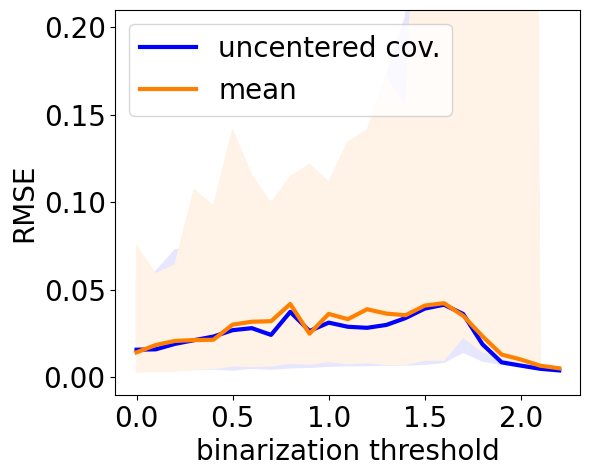

In [60]:
end_thresh_index = get_closest_match(values=threshold, target=2.3)
threshold_np = depytorch(threshold[:end_thresh_index])
group_mean_state_rmse_min = depytorch( group_mean_state_rmse.min(dim=0).values[:end_thresh_index] )
group_mean_state_rmse_median = depytorch( group_mean_state_rmse.median(dim=0).values[:end_thresh_index] )
group_mean_state_rmse_max = depytorch( group_mean_state_rmse.max(dim=0).values[:end_thresh_index] )
group_mean_state_product_rmse_min = depytorch( group_mean_state_product_rmse.min(dim=0).values[:end_thresh_index] )
group_mean_state_product_rmse_median = depytorch( group_mean_state_product_rmse.median(dim=0).values[:end_thresh_index] )
group_mean_state_product_rmse_max = depytorch( group_mean_state_product_rmse.max(dim=0).values[:end_thresh_index] )

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 5) )
line_width = 3.0

cval = blue_cval
axs.fill_between( threshold_np, group_mean_state_product_rmse_min, group_mean_state_product_rmse_max, color=[0.9+0.1*c for c in cval])
axs.plot(threshold_np, group_mean_state_product_rmse_median, color=cval, linewidth=line_width, label=f'uncentered cov.')

cval = orange_cval
axs.fill_between( threshold_np, group_mean_state_rmse_min, group_mean_state_rmse_max, color=[0.9+0.1*c for c in cval])
axs.plot(threshold_np, group_mean_state_rmse_median, color=cval, linewidth=line_width, label=f'mean')

axs.set_ylim([-0.01, 0.21])

axs.legend(loc='upper left')
axs.set_xlabel('binarization threshold')
axs.set_ylabel('RMSE')
plt.show()

In [59]:
group_mean_state_rmse_min = group_mean_state_rmse.min(dim=0).values
group_mean_state_rmse_median = group_mean_state_rmse.median(dim=0).values
group_mean_state_rmse_max = group_mean_state_rmse.max(dim=0).values
print( torch.stack( (threshold, group_mean_state_rmse_min, group_mean_state_rmse_median, group_mean_state_rmse_max ), dim=-1 ) )

tensor([[0.0000e+00, 2.9722e-03, 1.4219e-02, 7.5237e-02],
        [1.0000e-01, 3.4507e-03, 1.8404e-02, 5.9081e-02],
        [2.0000e-01, 3.4038e-03, 2.0736e-02, 6.4217e-02],
        [3.0000e-01, 4.5333e-03, 2.1229e-02, 1.0726e-01],
        [4.0000e-01, 4.9552e-03, 2.1419e-02, 9.7694e-02],
        [5.0000e-01, 6.5207e-03, 3.0061e-02, 1.4120e-01],
        [6.0000e-01, 6.1752e-03, 3.1707e-02, 1.1516e-01],
        [7.0000e-01, 6.5113e-03, 3.2013e-02, 9.9425e-02],
        [8.0000e-01, 8.0430e-03, 4.1846e-02, 1.1465e-01],
        [9.0000e-01, 7.4685e-03, 2.4876e-02, 1.2153e-01],
        [1.0000e+00, 8.9601e-03, 3.6164e-02, 1.1153e-01],
        [1.1000e+00, 7.7143e-03, 3.3169e-02, 1.3428e-01],
        [1.2000e+00, 8.4172e-03, 3.8840e-02, 1.4119e-01],
        [1.3000e+00, 7.2349e-03, 3.6354e-02, 1.7145e-01],
        [1.4000e+00, 7.3361e-03, 3.5441e-02, 1.5428e-01],
        [1.5000e+00, 9.8254e-03, 4.0939e-02, 3.8018e-01],
        [1.6000e+00, 9.7380e-03, 4.2296e-02, 5.7475e-01],
        [1.700

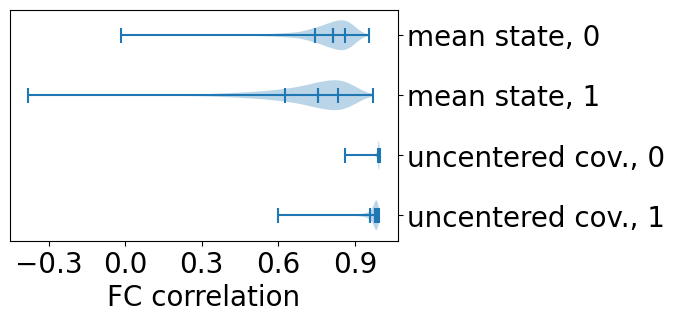

In [68]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 3) )
corr_labels = ['uncentered cov., 1', 'uncentered cov., 0', 'mean state, 1', 'mean state, 0']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [ depytorch( fc.flatten() ) for fc in [individual_1_mean_state_product_corr, individual_0_mean_state_product_corr, individual_1_mean_state_corr, individual_0_mean_state_corr] ]
axs.violinplot( all_corrs, showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal' )
axs.set_yticks(label_x)
axs.set_xticks([-0.3, 0.0, 0.3, 0.6, 0.9])
# plt.yticks(rotation=45)
axs.set_yticklabels(corr_labels)
axs.yaxis.set_label_position("right")
axs.yaxis.tick_right()
axs.set_xlabel('correlation')
# axs.set_xlim([0.3, 1.1])
plt.show()

In [69]:
individual_0_dir_str = other_file_dir
individual_0_data_name_part = 'all_mean_std_0'
individual_0_sim_name_part = 'group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_test_length_120000'
mean_scans_individual_0 = True
individual_0_mean_state_rmse = get_mean_state_rmse(dir_str=individual_0_dir_str, data_name_part=individual_0_data_name_part, sim_name_part=individual_0_sim_name_part, mean_scans=mean_scans_individual_0)
individual_0_mean_state_product_rmse = get_mean_state_product_rmse(dir_str=individual_0_dir_str, data_name_part=individual_0_data_name_part, sim_name_part=individual_0_sim_name_part, mean_scans=mean_scans_individual_0)

loaded data_mean_state torch.Size([4, 837, 360])
resized to torch.Size([1, 837, 360])
loaded sim_mean_state torch.Size([5, 837, 360])
computed mean_state_rmse torch.Size([5, 837])
loaded data_mean_state_product torch.Size([4, 837, 360, 360])
resized to torch.Size([1, 837, 64620])
loaded sim_mean_state_product torch.Size([5, 837, 360, 360])
resized to torch.Size([5, 837, 64620])
computed mean_state_product_rmse torch.Size([5, 837])


In [70]:
individual_1_dir_str = other_file_dir
individual_1_data_name_part = 'all_mean_std_1'
individual_1_sim_name_part = 'group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_test_length_120000'
mean_scans_individual_1 = True
individual_1_mean_state_rmse = get_mean_state_rmse(dir_str=individual_1_dir_str, data_name_part=individual_1_data_name_part, sim_name_part=individual_1_sim_name_part, mean_scans=mean_scans_individual_1)
individual_1_mean_state_product_rmse = get_mean_state_product_rmse(dir_str=individual_1_dir_str, data_name_part=individual_1_data_name_part, sim_name_part=individual_1_sim_name_part, mean_scans=mean_scans_individual_1)

loaded data_mean_state torch.Size([4, 837, 360])
resized to torch.Size([1, 837, 360])
loaded sim_mean_state torch.Size([5, 837, 360])
computed mean_state_rmse torch.Size([5, 837])
loaded data_mean_state_product torch.Size([4, 837, 360, 360])
resized to torch.Size([1, 837, 64620])
loaded sim_mean_state_product torch.Size([5, 837, 360, 360])
resized to torch.Size([5, 837, 64620])
computed mean_state_product_rmse torch.Size([5, 837])


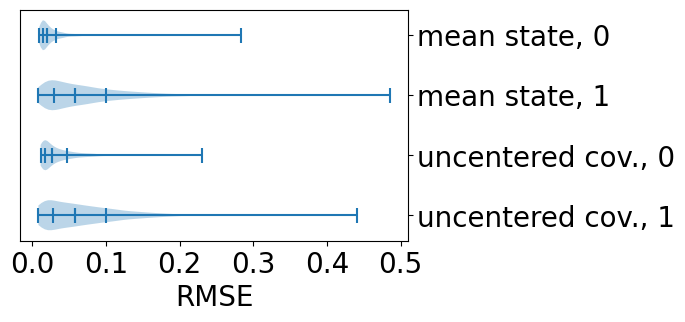

In [73]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 3) )
corr_labels = ['uncentered cov., 1', 'uncentered cov., 0', 'mean state, 1', 'mean state, 0']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [ depytorch( fc.flatten() ) for fc in [individual_1_mean_state_product_rmse, individual_0_mean_state_product_rmse, individual_1_mean_state_rmse, individual_0_mean_state_rmse] ]
axs.violinplot( all_corrs, showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal' )
axs.set_yticks(label_x)
axs.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
# plt.yticks(rotation=45)
axs.set_yticklabels(corr_labels)
axs.yaxis.set_label_position("right")
axs.yaxis.tick_right()
axs.set_xlabel('RMSE')
# axs.set_xlim([0.3, 1.1])
plt.show()

In [ ]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 4) )
end_thresh = get_closest_match(values=threshold, target=2.5)
threshold_np = depytorch(threshold[:end_thresh])
line_width = 3.0

fc_corr_min_final = depytorch(fc_corr_summary[-1,:end_thresh,min_col])
fc_corr_max_final = depytorch(fc_corr_summary[-1,:end_thresh,max_col])
fc_corr_median_final = depytorch(fc_corr_summary[-1,:end_thresh,median_col])

cval = blue_cval
axs.fill_between( threshold_np, fc_corr_min_final, fc_corr_max_final, color=[0.9+0.1*c for c in cval])
# axs.plot( threshold_np, fc_corr_min_final, color=cval, linestyle='--', linewidth=line_width )
# axs.plot( threshold_np, fc_corr_max_final, color=cval, linestyle='--', linewidth=line_width )
axs.plot( threshold_np, fc_corr_median_final, color=cval, linewidth=line_width, label=f'heterogeneous h' )

fc_corr_hom_h_min_final = depytorch( fc_corr_homogenized_h[:,:end_thresh].min(dim=0).values )
fc_corr_hom_h_max_final = depytorch( fc_corr_homogenized_h[:,:end_thresh].max(dim=0).values )
fc_corr_hom_h_median_final = depytorch( fc_corr_homogenized_h[:,:end_thresh].median(dim=0).values )

cval = orange_cval
axs.fill_between( threshold_np, fc_corr_hom_h_min_final, fc_corr_hom_h_max_final, color=[0.9+0.1*c for c in cval])
# axs.plot( threshold_np, fc_corr_min_final, color=cval, linestyle='--', linewidth=line_width )
# axs.plot( threshold_np, fc_corr_max_final, color=cval, linestyle='--', linewidth=line_width )
axs.plot( threshold_np, fc_corr_hom_h_median_final, color=cval, linewidth=line_width, label=f'homogeneous h' )

axs.legend()
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
plt.show()

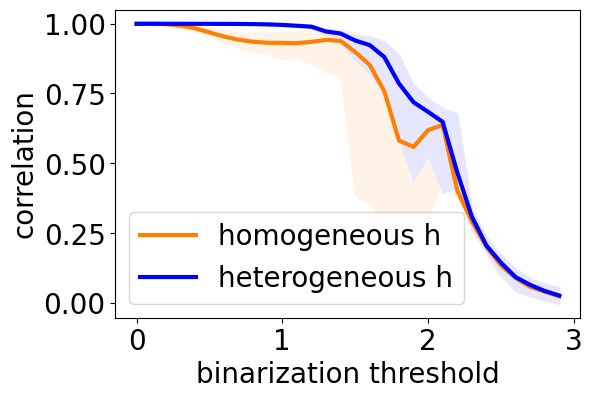

In [56]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 4) )
end_thresh = get_closest_match(values=threshold, target=3.0)

line_width = 3.0

threshold_np = depytorch(threshold[:end_thresh])

fc_corr_hom_aal_in_range = fc_corr_aal_mean_h[:,:end_thresh]
fc_corr_hom_min_final = depytorch( fc_corr_hom_aal_in_range.min(dim=0).values )
fc_corr_hom_max_final = depytorch( fc_corr_hom_aal_in_range.max(dim=0).values )
fc_corr_hom_median_final = depytorch( fc_corr_hom_aal_in_range.median(dim=0).values )

cval = orange_cval
axs.fill_between( threshold_np, fc_corr_hom_min_final, fc_corr_hom_max_final, color=[0.9+0.1*c for c in cval])
# axs.plot( threshold_np, fc_corr_min_final, color=cval, linestyle='--', linewidth=line_width )
# axs.plot( threshold_np, fc_corr_max_final, color=cval, linestyle='--', linewidth=line_width )
axs.plot( threshold_np, fc_corr_hom_median_final, color=cval, linewidth=line_width, label=f'homogeneous h' )

fc_corr_aal_in_range = fc_corr_aal[:,:end_thresh]
fc_corr_min_final = depytorch( fc_corr_aal_in_range.min(dim=0).values )
fc_corr_max_final = depytorch( fc_corr_aal_in_range.max(dim=0).values )
fc_corr_median_final = depytorch( fc_corr_aal_in_range.median(dim=0).values )

cval = blue_cval
axs.fill_between( threshold_np, fc_corr_min_final, fc_corr_max_final, color=[0.9+0.1*c for c in cval])
# axs.plot( threshold_np, fc_corr_min_final, color=cval, linestyle='--', linewidth=line_width )
# axs.plot( threshold_np, fc_corr_max_final, color=cval, linestyle='--', linewidth=line_width )
axs.plot( threshold_np, fc_corr_median_final, color=cval, linewidth=line_width, label=f'heterogeneous h' )

axs.legend()
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
plt.show()

In [33]:
state_mean_rmse_file = os.path.join(file_dir, f'state_mean_rmse_ising_model_light_group_thresholds_{num_threshold}_min_{min_threshold:.3g}_max_{max_threshold:.3g}_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_test_length_120000.pt')
state_mean_rmse = torch.load(state_mean_rmse_file, weights_only=False)
print( state_mean_rmse.size() )

torch.Size([101, 31])


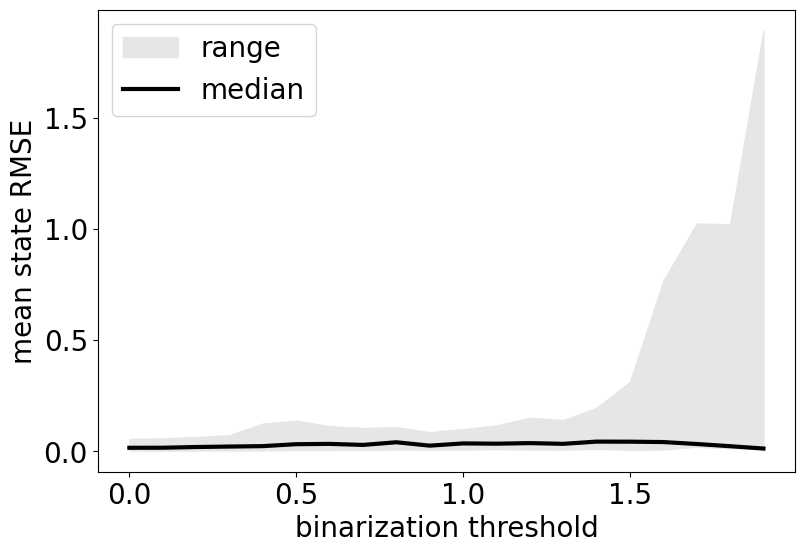

In [41]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
max_threshold_index = get_closest_match(values=threshold, target=2.0)
threshold_np = depytorch(threshold[:max_threshold_index])
state_mean_rmse_in_range = state_mean_rmse[:,:max_threshold_index]
state_mean_rmse_min_np = depytorch( state_mean_rmse_in_range.min(dim=0).values )
state_mean_rmse_median_np = depytorch( state_mean_rmse_in_range.median(dim=0).values )
state_mean_rmse_max_np = depytorch( state_mean_rmse_in_range.max(dim=0).values )
line_width = 3.0

cval = [0.0, 0.0, 0.0]
axs.fill_between( threshold_np, state_mean_rmse_min_np, state_mean_rmse_max_np, color=[0.9+0.1*c for c in cval], label=f'range')
# axs.plot( threshold_np, state_mean_rmse_min_np, color=cval, linestyle='--', linewidth=line_width )
# axs.plot( threshold_np, state_mean_rmse_max_np, color=cval, linestyle='--', linewidth=line_width )
axs.plot( threshold_np, state_mean_rmse_median_np, color=cval, linewidth=line_width, label=f'median' )

axs.legend()
axs.set_xlabel('binarization threshold')
axs.set_ylabel('mean state RMSE')
plt.show()

In [58]:
state_product_mean_rmse_file = os.path.join(file_dir, f'state_product_mean_rmse_ising_model_light_group_thresholds_{num_threshold}_min_{min_threshold:.3g}_max_{max_threshold:.3g}_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_test_length_120000.pt')
state_product_mean_rmse = torch.load(state_product_mean_rmse_file, weights_only=False)
print( state_product_mean_rmse.size() )

torch.Size([101, 31])


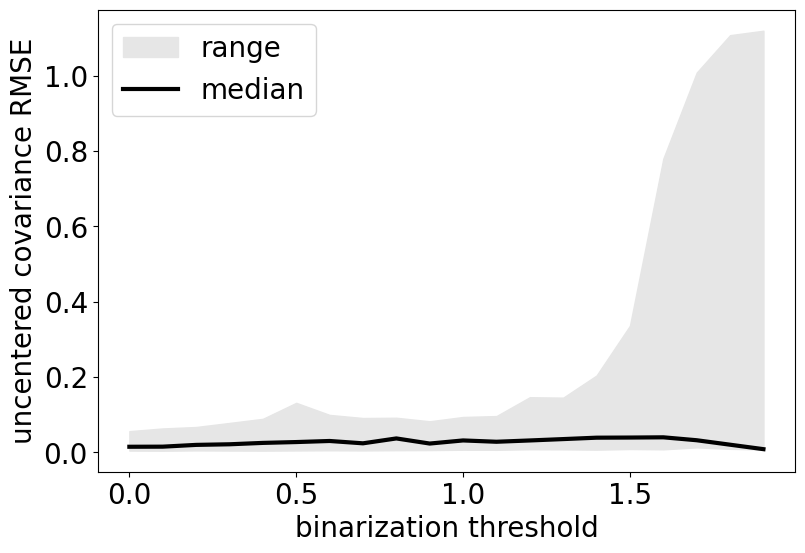

In [61]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
max_threshold_index = get_closest_match(values=threshold, target=2.0)
threshold_np = depytorch(threshold[:max_threshold_index])
state_product_mean_rmse_in_range = state_product_mean_rmse[:,:max_threshold_index]
state_product_mean_rmse_min_np = depytorch( state_product_mean_rmse_in_range.min(dim=0).values )
state_product_mean_rmse_median_np = depytorch( state_product_mean_rmse_in_range.median(dim=0).values )
state_product_mean_rmse_max_np = depytorch( state_product_mean_rmse_in_range.max(dim=0).values )
line_width = 3.0

cval = [0.0, 0.0, 0.0]
axs.fill_between( threshold_np, state_product_mean_rmse_min_np, state_product_mean_rmse_max_np, color=[0.9+0.1*c for c in cval], label=f'range')
# axs.plot( threshold_np, state_mean_rmse_min_np, color=cval, linestyle='--', linewidth=line_width )
# axs.plot( threshold_np, state_mean_rmse_max_np, color=cval, linestyle='--', linewidth=line_width )
axs.plot( threshold_np, state_product_mean_rmse_median_np, color=cval, linewidth=line_width, label=f'median' )

axs.legend()
axs.set_xlabel('binarization threshold')
axs.set_ylabel('uncentered covariance RMSE')
plt.show()

In [57]:
def check_aal_model():
    # model_aal = torch.load( f=os.path.join(file_dir, 'ising_model_light_group_init_means_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_1_steps_1200_lr_0.01_beta_updates_8_param_updates_40000.pt'), weights_only=False )
    model_aal = torch.load( f=os.path.join(file_dir, 'ising_model_light_group_init_means_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_1_steps_1200_lr_0.01_beta_updates_8.pt'), weights_only=False )
    print( model_aal.h.size() )
    print( model_aal.J.size() )
    return 0
check_aal_model()

torch.Size([101, 31, 117])
torch.Size([101, 31, 117, 117])


0

In [62]:
print( 'h reduced to', group_h.size() )
print( 'J reduced to', group_J.size() )

h reduced to torch.Size([101, 31, 360])
J reduced to torch.Size([101, 31, 64620])


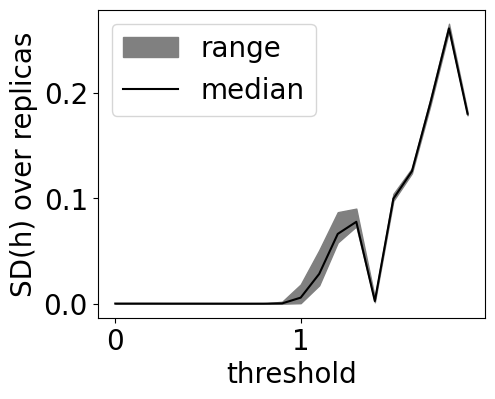

In [230]:
max_threshold_index = get_closest_match(values=threshold, target=2.0)
threshold_np = depytorch(threshold[:max_threshold_index])
h_rep_std = torch.std(group_h[:,:max_threshold_index,:], dim=0)
min_h_rep_std = depytorch( torch.min(h_rep_std, dim=-1).values )
median_h_rep_std = depytorch( torch.median(h_rep_std, dim=-1).values )
max_h_rep_std = depytorch( torch.max(h_rep_std, dim=-1).values )
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax.fill_between(threshold_np, min_h_rep_std, max_h_rep_std, color=[0.5, 0.5, 0.5], label='range')
ax.plot(threshold_np, median_h_rep_std, color=[0.0, 0.0, 0.0], label='median')
ax.set_xlabel('threshold')
ax.set_ylabel('SD(h) over replicas')
ax.legend()

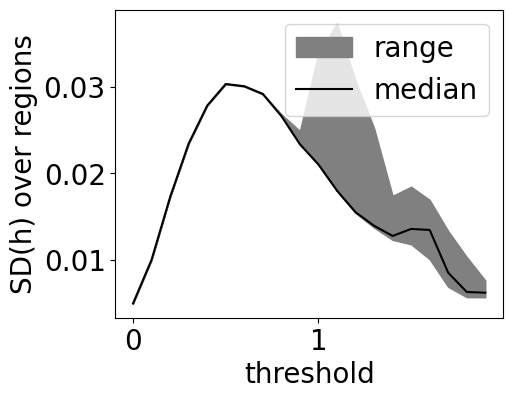

In [231]:
max_threshold_index = get_closest_match(values=threshold, target=2.0)
threshold_np = depytorch(threshold[:max_threshold_index])
h_node_std = torch.std(group_h[:,:max_threshold_index,:], dim=-1)
min_h_node_std = depytorch( torch.min(h_node_std, dim=0).values )
median_h_node_std = depytorch( torch.median(h_node_std, dim=0).values )
max_h_node_std = depytorch( torch.max(h_node_std, dim=0).values )
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax.fill_between(threshold_np, min_h_node_std, max_h_node_std, color=[0.5, 0.5, 0.5], label='range')
ax.plot(threshold_np, median_h_node_std, color=[0.0, 0.0, 0.0], label='median')
ax.set_xlabel('threshold')
ax.set_ylabel('SD(h) over regions')
ax.legend()

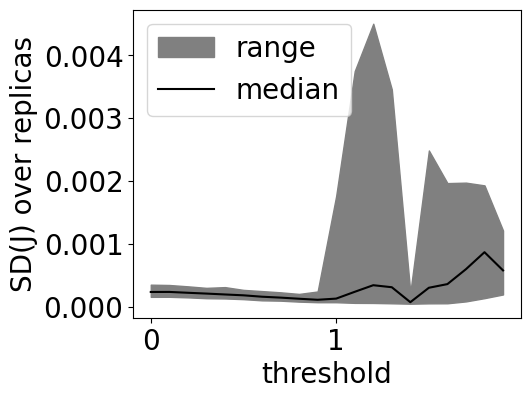

In [232]:
max_threshold_index = get_closest_match(values=threshold, target=2.0)
threshold_np = depytorch(threshold[:max_threshold_index])
J_rep_std = torch.std(group_J[:,:max_threshold_index,:], dim=0)
min_J_rep_std = depytorch( torch.min(J_rep_std, dim=-1).values )
median_J_rep_std = depytorch( torch.median(J_rep_std, dim=-1).values )
max_J_rep_std = depytorch( torch.max(J_rep_std, dim=-1).values )
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax.fill_between(threshold_np, min_J_rep_std, max_J_rep_std, color=[0.5, 0.5, 0.5], label='range')
ax.plot(threshold_np, median_J_rep_std, color=[0.0, 0.0, 0.0], label='median')
ax.set_xlabel('threshold')
ax.set_ylabel('SD(J) over replicas')
ax.legend()

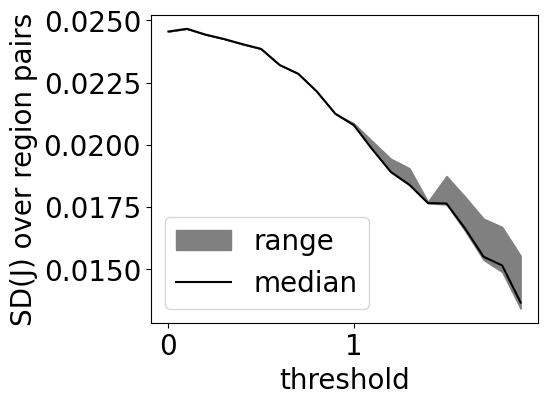

In [233]:
max_threshold_index = get_closest_match(values=threshold, target=2.0)
threshold_np = depytorch(threshold[:max_threshold_index])
J_node_std = torch.std(group_J[:,:max_threshold_index,:], dim=-1)
min_J_node_std = depytorch( torch.min(J_node_std, dim=0).values )
median_J_node_std = depytorch( torch.median(J_node_std, dim=0).values )
max_J_node_std = depytorch( torch.max(J_node_std, dim=0).values )
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax.fill_between(threshold_np, min_J_node_std, max_J_node_std, color=[0.5, 0.5, 0.5], label='range')
ax.plot(threshold_np, median_J_node_std, color=[0.0, 0.0, 0.0], label='median')
ax.set_xlabel('threshold')
ax.set_ylabel('SD(J) over region pairs')
ax.legend()

In [13]:
model_0 = torch.load( os.path.join(other_file_dir, 'ising_model_light_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000.pt'), weights_only=False )
print( model_0.h.size() )
print( model_0.J.size() )

torch.Size([5, 837, 360])
torch.Size([5, 837, 360, 360])


In [14]:
model_1 = torch.load( os.path.join(other_file_dir, 'ising_model_light_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000.pt'), weights_only=False )
print( model_1.h.size() )
print( model_1.J.size() )

torch.Size([5, 837, 360])
torch.Size([5, 837, 360, 360])


In [17]:
model_0 = torch.load( os.path.join(other_file_dir, 'light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000.pt'), weights_only=False )
print( model_0.h.size() )
print( model_0.J.size() )

torch.Size([5, 837, 360])
torch.Size([5, 837, 360, 360])


In [18]:
model_1 = torch.load( os.path.join(other_file_dir, 'light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000.pt'), weights_only=False )
print( model_1.h.size() )
print( model_1.J.size() )

torch.Size([5, 837, 360])
torch.Size([5, 837, 360, 360])


In [19]:
beta_h_0 = model_0.h * model_0.beta.unsqueeze(dim=-1)
beta_h_1 = model_1.h * model_1.beta.unsqueeze(dim=-1)

In [20]:
h_0_std, h_0_mean = torch.std_mean( beta_h_0.mean(dim=0), dim=0 )
h_1_std, h_1_mean = torch.std_mean( beta_h_1.mean(dim=0), dim=0 )

In [21]:
print( h_0_mean.std().item() )
print( h_1_mean.std().item() )

0.004301589448004961
0.022602001205086708


In [22]:
print( h_0_mean.min().item(), h_0_mean.median().item(), h_0_mean.max().item() )
print( h_1_mean.min().item(), h_1_mean.median().item(), h_1_mean.max().item() )

-0.011536788195371628 -0.0003739756648428738 0.012534637935459614
-0.11782543361186981 -0.02233750931918621 0.02367923967540264


In [23]:
print( h_0_std.min().item(), h_0_std.median().item(), h_0_std.max().item() )
print( h_1_std.min().item(), h_1_std.median().item(), h_1_std.max().item() )

0.01280141994357109 0.015509518794715405 0.01699393428862095
0.017624588683247566 0.028012482449412346 0.041514962911605835


In [24]:
replica_std_0 = beta_h_0.std(dim=0)
print( replica_std_0.min().item(), replica_std_0.median().item(), replica_std_0.max().item() )
replica_std_1 = beta_h_1.std(dim=0)
print( replica_std_1.min().item(), replica_std_1.median().item(), replica_std_1.max().item() )

9.09068785404088e-06 0.00026018399512395263 0.000980630749836564
2.5497736260149395e-06 0.0006811712519265711 0.05097513645887375


In [25]:
beta_J_0 = model_0.J * model_0.beta.unsqueeze(dim=-1).unsqueeze(dim=-1)
beta_J_1 = model_1.J * model_1.beta.unsqueeze(dim=-1).unsqueeze(dim=-1)

In [26]:
triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=beta_J_0.size(dim=-1), device=beta_J_0.device )
J_0_std, J_0_mean = torch.std_mean( beta_J_0[:,:,triu_rows,triu_cols].mean(dim=0), dim=0 )
J_1_std, J_1_mean = torch.std_mean( beta_J_1[:,:,triu_rows,triu_cols].mean(dim=0), dim=0 )

In [27]:
print( J_0_mean.std().item() )
print( J_1_mean.std().item() )

0.02072317712008953
0.020153239369392395


In [28]:
print( J_0_mean.min().item(), J_0_mean.median().item(), J_0_mean.max().item() )
print( J_1_mean.min().item(), J_1_mean.median().item(), J_1_mean.max().item() )

-0.05040460079908371 0.00029265572084113955 0.41346248984336853
-0.04643773287534714 0.0002674429561011493 0.3326951563358307


In [29]:
print( J_0_std.min().item(), J_0_std.median().item(), J_0_std.max().item() )
print( J_1_std.min().item(), J_1_std.median().item(), J_1_std.max().item() )

0.01057757530361414 0.018367934972047806 0.05756855383515358
0.012675749137997627 0.021399909630417824 0.07171221822500229


In [30]:
J_replica_std_0 = beta_J_0[:,:,triu_rows,triu_cols].std(dim=0)
print( J_replica_std_0.min().item(), J_replica_std_0.median().item(), J_replica_std_0.max().item() )
J_replica_std_1 = beta_J_1[:,:,triu_rows,triu_cols].std(dim=0)
print( J_replica_std_1.min().item(), J_replica_std_1.median().item(), J_replica_std_1.max().item() )

1.382118284709577e-06 0.00019368133507668972 0.0007587940781377256
9.607779247744475e-07 0.00011128328333143145 0.0062868716195225716


Text(0, 0.5, 'h for threshold 1')

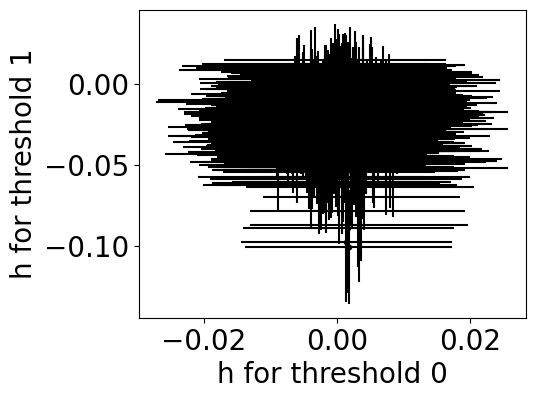

In [151]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax.errorbar( x=depytorch(h_0_mean), y=depytorch(h_1_mean), yerr=depytorch(h_1_std), xerr=depytorch(h_0_std), fmt='.', color='black' )
ax.set_xlabel('h for threshold 0')
ax.set_ylabel('h for threshold 1')

mean h, threshold=1=0.0864mean h, threshold=0+-0.0239, R^2=0.00027


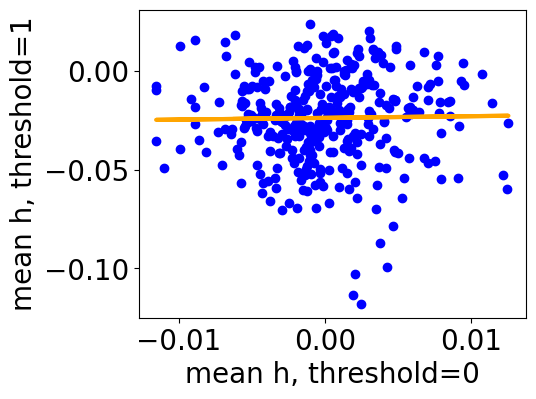

In [32]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line( ax, feature=h_0_mean, param=h_1_mean, feature_name='mean h, threshold=0', param_name='mean h, threshold=1' )

In [33]:
get_correlation_and_p( feature=h_0_mean, param=h_1_mean, feature_name='mean h, threshold=0', param_name='mean h, threshold=1', num_perms=1000000 )

mean h, threshold=1 v. mean h, threshold=0 corr.=0.0164, p-value=0.755


(tensor(0.0164, device='cuda:0'), tensor(0.7549, device='cuda:0'))

SD h, threshold=1=2.09SD h, threshold=0+-0.00479, R^2=0.0747


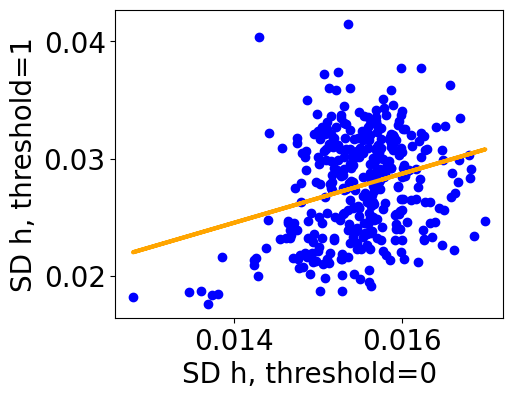

In [34]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line( ax, feature=h_0_std, param=h_1_std, feature_name='SD h, threshold=0', param_name='SD h, threshold=1' )

In [40]:
get_correlation_and_p( feature=h_0_std, param=h_1_std, feature_name='SD h, threshold=0', param_name='SD h, threshold=1', num_perms=1000000 )

SD h, threshold=1 v. SD h, threshold=0 corr.=0.273, p-value=0


(tensor(0.2729, device='cuda:0'), tensor(0., device='cuda:0'))

mean J, threshold=1=0.955mean J, threshold=0+0.000625, R^2=0.964


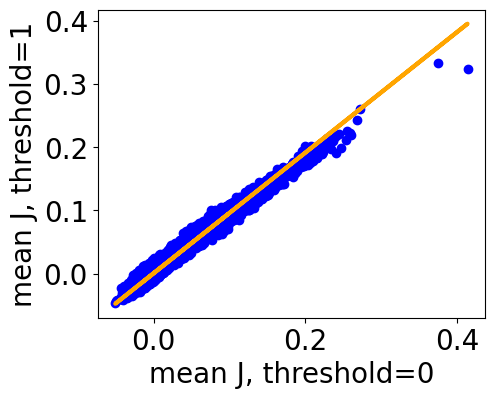

In [36]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line( ax, feature=J_0_mean, param=J_1_mean, feature_name='mean J, threshold=0', param_name='mean J, threshold=1' )

In [41]:
get_correlation_and_p( feature=J_0_mean, param=J_1_mean, feature_name='mean J, threshold=0', param_name='mean J, threshold=1', num_perms=1000000 )

mean J, threshold=1 v. mean J, threshold=0 corr.=0.982, p-value=0


(tensor(0.9820, device='cuda:0'), tensor(0., device='cuda:0'))

SD J, threshold=1=1.27SD J, threshold=0+-0.00162, R^2=0.922


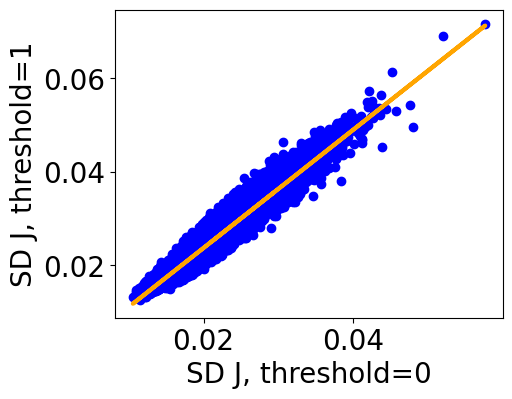

In [38]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
make_scatter_plot_with_regression_line( ax, feature=J_0_std, param=J_1_std, feature_name='SD J, threshold=0', param_name='SD J, threshold=1' )

In [42]:
get_correlation_and_p( feature=J_0_std, param=J_1_std, feature_name='SD J, threshold=0', param_name='SD J, threshold=1', num_perms=1000000 )

SD J, threshold=1 v. SD J, threshold=0 corr.=0.96, p-value=0


(tensor(0.9600, device='cuda:0'), tensor(0., device='cuda:0'))

Text(0, 0.5, 'J for threshold 1')

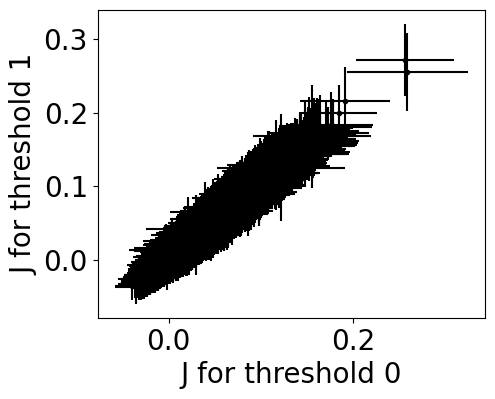

In [171]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax.errorbar( x=depytorch(J_0_mean), y=depytorch(J_1_mean), yerr=depytorch(J_1_std), xerr=depytorch(J_0_std), fmt='.', color='black' )
ax.set_xlabel('J for threshold 0')
ax.set_ylabel('J for threshold 1')

In [43]:
h_1_std_sorted, h_1_std_indices = torch.sort(h_1_std, dim=0, descending=True)
h_0_std_sorted, h_0_std_indices = torch.sort(h_0_std, dim=0, descending=True)
node_ranks = torch.arange( h_1_std_indices.numel(), dtype=float_type, device=device )

In [44]:
h_0 = beta_h_0.mean(dim=0)
h_1 = beta_h_1.mean(dim=0)

In [45]:
J_0 = beta_J_0.mean(dim=0)[:,triu_rows,triu_cols]
J_1 = beta_J_1.mean(dim=0)[:,triu_rows,triu_cols]

In [46]:
h_1_sorted = h_1[:,h_1_std_indices]
h_1_diff_from_mean = h_1_sorted - h_1_sorted.mean(dim=0, keepdim=True)

Text(0.5, 1.0, 'threshold=1')

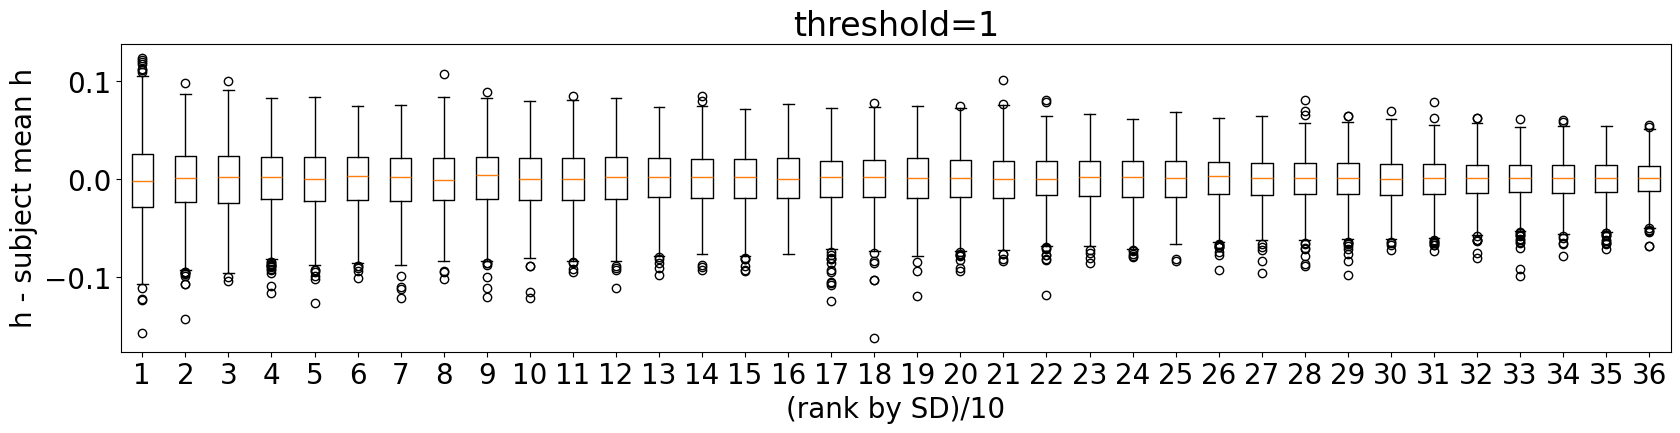

In [47]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(20, 4) )
skip_indices = torch.arange( start=0, end=h_1_diff_from_mean.size(dim=-1), step=10 )
ax.boxplot( x=depytorch(h_1_diff_from_mean[:,skip_indices]) )
ax.set_xlabel('(rank by SD)/10')
ax.set_ylabel('h - subject mean h')
ax.set_title('threshold=1')

Text(0.5, 1.0, 'threshold=1')

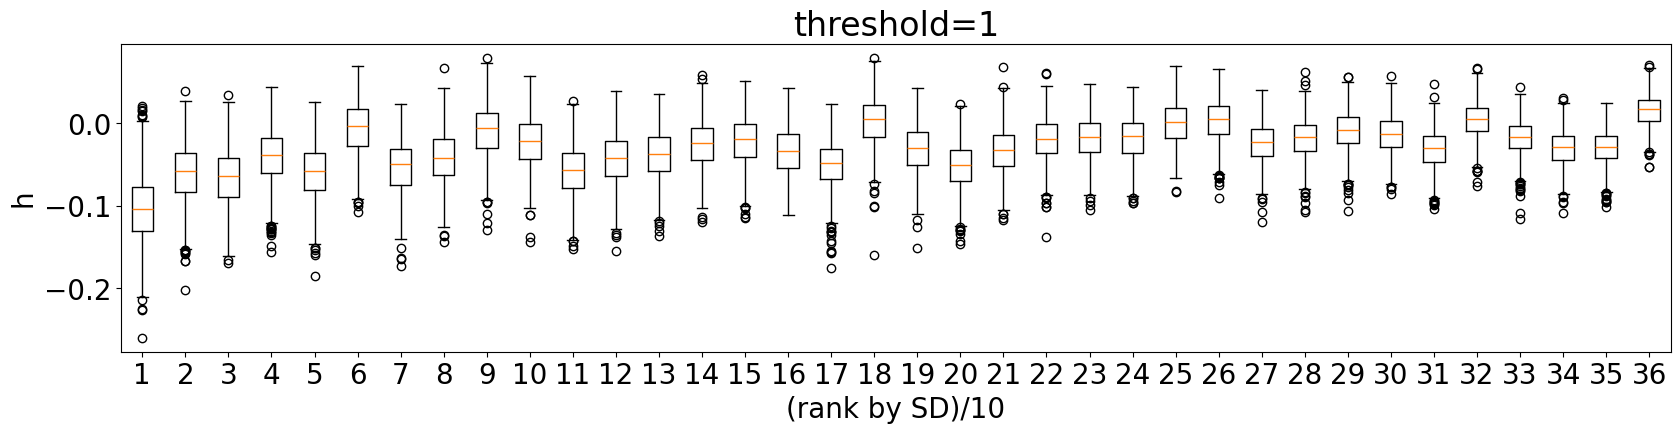

In [48]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(20, 4) )
skip_indices = torch.arange( start=0, end=h_1_sorted.size(dim=-1), step=10 )
ax.boxplot( x=depytorch(h_1_sorted[:,skip_indices]) )
ax.set_xlabel('(rank by SD)/10')
ax.set_ylabel('h')
ax.set_title('threshold=1')

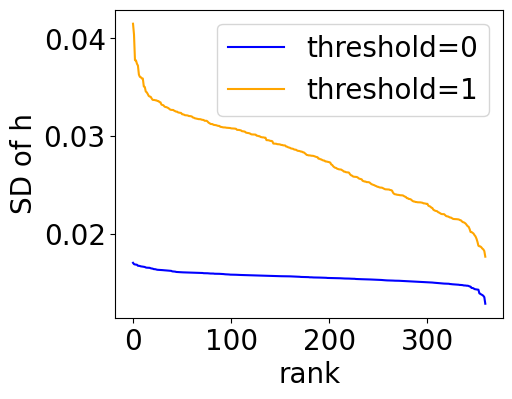

In [49]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax.plot( depytorch(node_ranks), depytorch(h_0_std_sorted), color='blue', label='threshold=0' )
ax.plot( depytorch(node_ranks), depytorch(h_1_std_sorted), color='orange', label='threshold=1' )
ax.set_xlabel('rank')
ax.set_ylabel('SD of h')
ax.legend()

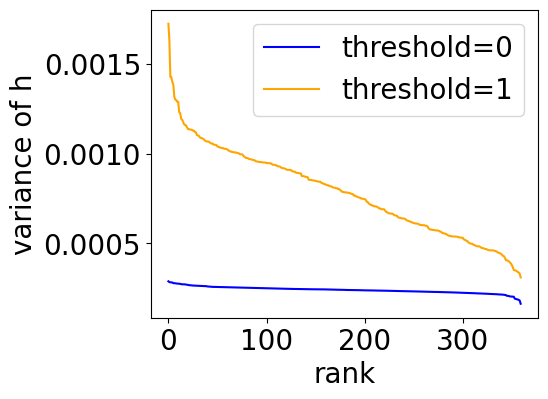

In [50]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax.plot(  depytorch(node_ranks), depytorch( h_0_std_sorted.square() ), color='blue', label='threshold=0'  )
ax.plot(  depytorch(node_ranks), depytorch( h_1_std_sorted.square() ), color='orange', label='threshold=1'  )
ax.set_xlabel('rank')
ax.set_ylabel('variance of h')
ax.legend()

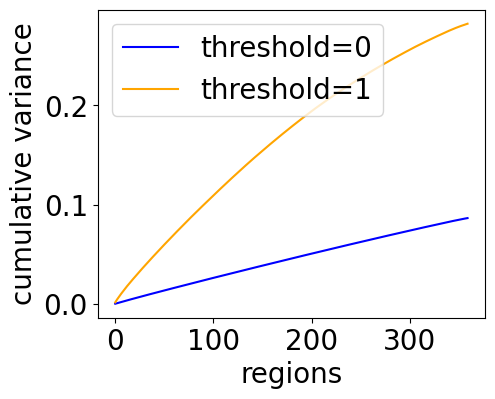

In [51]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax.plot(  depytorch(node_ranks), depytorch( h_0_std_sorted.square().cumsum(dim=0) ), color='blue', label='threshold=0'  )
ax.plot(  depytorch(node_ranks), depytorch( h_1_std_sorted.square().cumsum(dim=0) ), color='orange', label='threshold=1'  )
ax.set_xlabel('regions')
ax.set_ylabel('cumulative variance')
ax.legend()

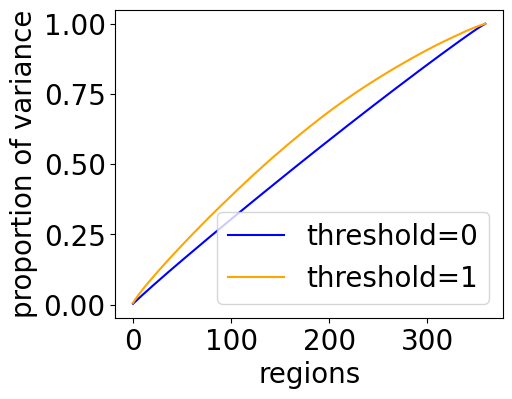

In [52]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
h_0_var_sorted = h_0_std_sorted.square()
h_1_var_sorted = h_1_std_sorted.square()
ax.plot(  depytorch(node_ranks), depytorch( h_0_var_sorted.cumsum(dim=0)/h_0_var_sorted.sum() ), color='blue', label='threshold=0'  )
ax.plot(  depytorch(node_ranks), depytorch( h_1_var_sorted.cumsum(dim=0)/h_1_var_sorted.sum() ), color='orange', label='threshold=1'  )
ax.set_xlabel('regions')
ax.set_ylabel('proportion of variance')
ax.legend()

In [53]:
print( h_0_var_sorted[:10].tolist(), h_0_var_sorted[-10:].tolist() )
print( h_1_var_sorted[:10].tolist(), h_1_var_sorted[-10:].tolist()  )

[0.0002887937880586833, 0.000284353707684204, 0.00028315754025243223, 0.0002828362921718508, 0.00028219749219715595, 0.00027864138246513903, 0.00027845517615787685, 0.0002778217603918165, 0.0002766212564893067, 0.0002762913063634187] [0.0002035303768934682, 0.00020294265414122492, 0.00020267502986826003, 0.00019197656365577132, 0.00019071590213570744, 0.00018887499754782766, 0.0001874896843219176, 0.00018528928922023624, 0.00018151814583688974, 0.00016387634968850762]
[0.0017234921688213944, 0.0016330145299434662, 0.0014265342615544796, 0.0014257996808737516, 0.0013995235785841942, 0.0013855112483724952, 0.0013172294711694121, 0.001300657750107348, 0.0012979331659153104, 0.0012886375188827515] [0.00037941616028547287, 0.00036696161259897053, 0.00035139734973199666, 0.00034932937705889344, 0.00034873647382482886, 0.0003453436656855047, 0.0003405899915378541, 0.00033758278004825115, 0.00033147106296382844, 0.00031062611378729343]


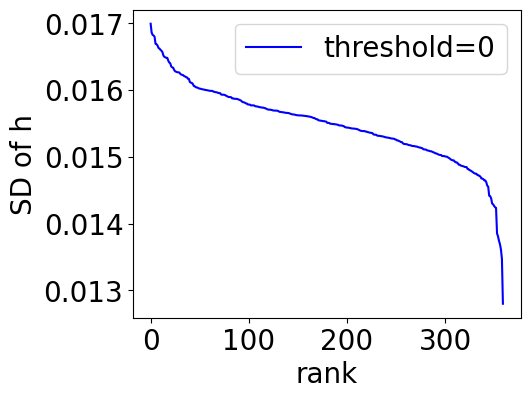

In [54]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax.plot( depytorch(node_ranks), depytorch(h_0_std_sorted), color='blue', label='threshold=0' )
ax.set_xlabel('rank')
ax.set_ylabel('SD of h')
ax.legend()

In [55]:
J_1_std_sorted, J_1_std_indices = torch.sort(J_1_std, dim=0, descending=True)
J_0_std_sorted, J_0_std_indices = torch.sort(J_0_std, dim=0, descending=True)
edge_ranks = torch.arange( J_1_std_indices.numel(), dtype=float_type, device=device )

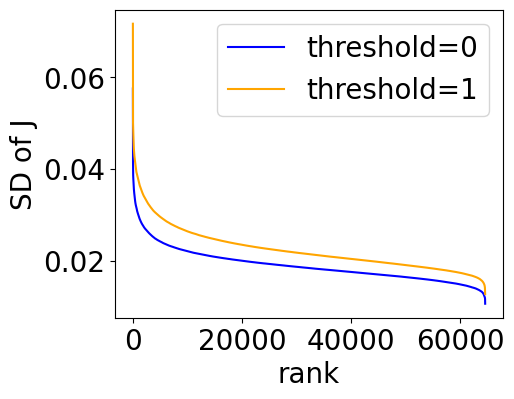

In [56]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax.plot( depytorch(edge_ranks), depytorch(J_0_std_sorted), color='blue', label='threshold=0' )
ax.plot( depytorch(edge_ranks), depytorch(J_1_std_sorted), color='orange', label='threshold=1' )
ax.set_xlabel('rank')
ax.set_ylabel('SD of J')
ax.legend()

In [57]:
print( h_0.size() )
num_nodes = h_0.size(dim=-1)
(U_h_0, S_h_0, V_h_0) = torch.pca_lowrank(h_0, q=num_nodes, center=True, niter=100)
print( U_h_0.size(), S_h_0.size(), V_h_0.size() )

torch.Size([837, 360])
torch.Size([837, 360]) torch.Size([360]) torch.Size([360, 360])


In [58]:
print( h_1.size() )
num_nodes = h_1.size(dim=-1)
(U_h_1, S_h_1, V_h_1) = torch.pca_lowrank(h_1, q=num_nodes, center=True, niter=100)
print( U_h_1.size(), S_h_1.size(), V_h_1.size() )

torch.Size([837, 360])
torch.Size([837, 360]) torch.Size([360]) torch.Size([360, 360])


In [59]:
print( S_h_0.min().item(), S_h_0.mean().item(), S_h_0.max().item(), S_h_0.min().item()/S_h_0.max().item() )

0.07736240327358246 0.41875025629997253 0.8907811045646667 0.08684782701064388


In [60]:
print( S_h_1.min().item(), S_h_1.mean().item(), S_h_1.max().item(), S_h_1.min().item()/S_h_1.max().item() )

0.16694310307502747 0.6443299651145935 7.482590675354004 0.02231086936572664


In [61]:
S_h_0_sorted, _ = S_h_0.sort(descending=True)
proportion_of_variance_h_0 = torch.cumsum(S_h_0_sorted, dim=0)/torch.sum(S_h_0)

In [62]:
S_h_1_sorted, _ = S_h_1.sort(descending=True)
proportion_of_variance_h_1 = torch.cumsum(S_h_1_sorted, dim=0)/torch.sum(S_h_1)

In [63]:
print( proportion_of_variance_h_0[:10].tolist(), proportion_of_variance_h_0[-10:].tolist() )
print( proportion_of_variance_h_1[:10].tolist(), proportion_of_variance_h_1[-10:].tolist()  )

[0.005908992141485214, 0.011358150281012058, 0.01650187373161316, 0.021521225571632385, 0.02653203159570694, 0.031504321843385696, 0.036433834582567215, 0.041286710649728775, 0.046124860644340515, 0.05092417076230049] [0.9914065003395081, 0.9925044178962708, 0.9935793876647949, 0.9946427941322327, 0.9956682324409485, 0.9966806173324585, 0.9976818561553955, 0.9986404180526733, 0.9994868040084839, 1.0]
[0.032258275896310806, 0.042508386075496674, 0.05103430151939392, 0.0585767887532711, 0.06584369391202927, 0.07292809337377548, 0.0798545777797699, 0.0865340530872345, 0.09303390979766846, 0.09942349046468735] [0.9926162362098694, 0.9935146570205688, 0.9944088459014893, 0.9952844977378845, 0.9961228370666504, 0.9969483613967896, 0.9977470636367798, 0.9985239505767822, 0.9992803931236267, 1.0000001192092896]


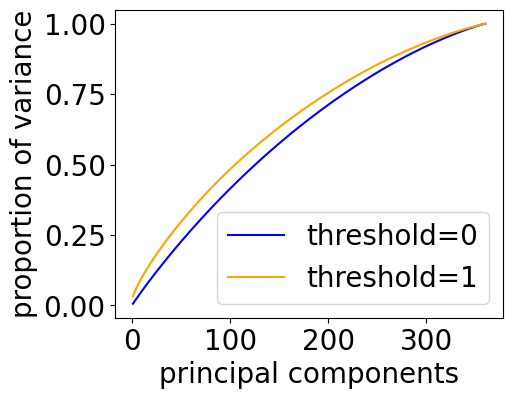

In [64]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
node_ranks = torch.arange( start=1, end=proportion_of_variance_h_0.numel()+1, dtype=float_type, device=device )
ax.plot( depytorch(node_ranks), depytorch(proportion_of_variance_h_0), color='blue', label='threshold=0' )
ax.plot( depytorch(node_ranks), depytorch(proportion_of_variance_h_1), color='orange', label='threshold=1' )
ax.set_xlabel('principal components')
ax.set_ylabel('proportion of variance')
ax.legend()

In [65]:
print( J_0.size() )
num_subjects = J_0.size(dim=0)
(U_J_0, S_J_0, V_J_0) = torch.pca_lowrank(J_0, q=num_subjects, center=True, niter=10)
print( U_J_0.size(), S_J_0.size(), V_J_0.size() )

torch.Size([837, 64620])
torch.Size([837, 837]) torch.Size([837]) torch.Size([64620, 837])


In [66]:
print( J_1.size() )
num_subjects = J_1.size(dim=0)
(U_J_1, S_J_1, V_J_1) = torch.pca_lowrank(J_1, q=num_subjects, center=True, niter=10)
print( U_J_1.size(), S_J_1.size(), V_J_1.size() )

torch.Size([837, 64620])
torch.Size([837, 837]) torch.Size([837]) torch.Size([64620, 837])


In [67]:
S_J_0_sorted, _ = S_J_0.sort(descending=True)
print( S_J_0_sorted[0].item(), S_J_0_sorted[-1].item() )
proportion_of_variance_J_0 = torch.cumsum(S_J_0_sorted, dim=0)/torch.sum(S_J_0)

12.445357322692871 1.070661164703779e-05


In [68]:
S_J_1_sorted, _ = S_J_1.sort(descending=True)
proportion_of_variance_J_1 = torch.cumsum(S_J_1_sorted, dim=0)/torch.sum(S_J_1)

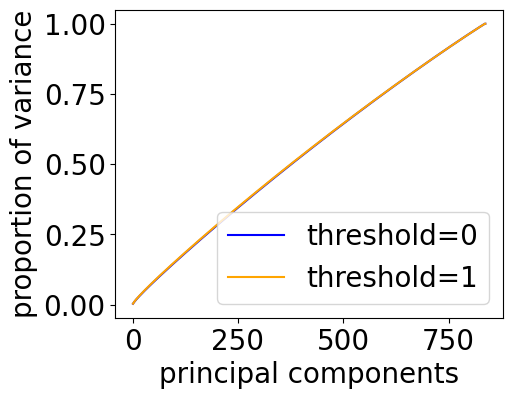

In [69]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
edge_ranks = torch.arange( start=1, end=proportion_of_variance_J_0.numel()+1, dtype=float_type, device=device )
ax.plot( depytorch(edge_ranks), depytorch(proportion_of_variance_J_0), color='blue', label='threshold=0' )
ax.plot( depytorch(edge_ranks), depytorch(proportion_of_variance_J_1), color='orange', label='threshold=1' )
ax.set_xlabel('principal components')
ax.set_ylabel('proportion of variance')
ax.legend()

In [70]:
pca_h_0 = torch.load( os.path.join(file_dir, f'pca_h_beta_subj_0_to_837_iter_20000_ising_model_light_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000.pt'), weights_only=False )
print( len(pca_h_0) )

7


In [85]:
pca_h_0 = torch.load( os.path.join(file_dir, f'pca_h_beta_subj_0_to_837_iter_200_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000.pt'), weights_only=False )
print( len(pca_h_0) )

7


In [86]:
U_h_0 = pca_h_0[0]
print( 'U_h_0 size', U_h_0.size() )
S_h_0 = pca_h_0[1]
print( 'S_h_0 size', S_h_0.size() )
V_h_0 = pca_h_0[2] 
print( 'V_h_0 size', V_h_0.size() )
proportion_of_variance_original_h_0 = pca_h_0[3]
print( 'proportion_of_variance_original_h_0 size', proportion_of_variance_original_h_0.size() )
proportion_of_variance_pca_h_0 = pca_h_0[4]
print( 'proportion_of_variance_pca_h_0 size', proportion_of_variance_pca_h_0.size() )
components_needed_original_h_0 = pca_h_0[5]
print( 'components_needed_original_h_0 size', components_needed_original_h_0.size() )
components_needed_pca_h_0 = pca_h_0[6]
print( 'components_needed_pca_h_0 size', components_needed_pca_h_0.size() )

U_h_0 size torch.Size([837, 360])
S_h_0 size torch.Size([360])
V_h_0 size torch.Size([360, 360])
proportion_of_variance_original_h_0 size torch.Size([360])
proportion_of_variance_pca_h_0 size torch.Size([360])
components_needed_original_h_0 size torch.Size([])
components_needed_pca_h_0 size torch.Size([])


In [72]:
pca_h_1 = torch.load( os.path.join(file_dir, f'pca_h_beta_subj_0_to_837_iter_20000_ising_model_light_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000.pt'), weights_only=False )
print( len(pca_h_1) )

7


In [87]:
pca_h_1 = torch.load( os.path.join(file_dir, f'pca_h_beta_subj_0_to_837_iter_200_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000.pt'), weights_only=False )
print( len(pca_h_1) )

7


In [88]:
U_h_1 = pca_h_1[0]
print( 'U_h_1 size', U_h_1.size() )
S_h_1 = pca_h_1[1]
print( 'S_h_1 size', S_h_1.size() )
V_h_1 = pca_h_1[2] 
print( 'V_h_1 size', V_h_1.size() )
proportion_of_variance_original_h_1 = pca_h_1[3]
print( 'proportion_of_variance_original_h_1 size', proportion_of_variance_original_h_1.size() )
proportion_of_variance_pca_h_1 = pca_h_1[4]
print( 'proportion_of_variance_pca_h_1 size', proportion_of_variance_pca_h_1.size() )
components_needed_original_h_1 = pca_h_1[5]
print( 'components_needed_original_h_1 size', components_needed_original_h_1.size() )
components_needed_pca_h_1 = pca_h_1[6]
print( 'components_needed_pca_h_1 size', components_needed_pca_h_1.size() )

U_h_1 size torch.Size([837, 360])
S_h_1 size torch.Size([360])
V_h_1 size torch.Size([360, 360])
proportion_of_variance_original_h_1 size torch.Size([360])
proportion_of_variance_pca_h_1 size torch.Size([360])
components_needed_original_h_1 size torch.Size([])
components_needed_pca_h_1 size torch.Size([])


In [89]:
num_nodes = proportion_of_variance_pca_h_0.numel()
num_edges = proportion_of_variance_original_J_0.numel()
num_edge_pcs = proportion_of_variance_pca_J_0.numel()
print(f'The top {components_needed_original_h_0} regions or top {components_needed_pca_h_0} of {num_nodes} PCs capture 95% of the variance of h for threshold 0.')
print(f'The top {components_needed_original_h_1} regions or top {components_needed_pca_h_1} of {num_nodes} PCs capture 95% of the variance of h for threshold 1.')
print(f'The top {components_needed_original_J_0} of {num_edges} region pairs or top {components_needed_pca_J_0} of {num_edge_pcs} PCs capture 95% of the variance of J for threshold 0.')
print(f'The top {components_needed_original_J_1} of {num_edges} region pairs or top {components_needed_pca_J_1} of {num_edge_pcs} PCs capture 95% of the variance of J for threshold 1.')

The top 339 regions or top 320 of 360 PCs capture 95% of the variance of h for threshold 0.
The top 326 regions or top 313 of 360 PCs capture 95% of the variance of h for threshold 1.
The top 58649 of 64620 region pairs or top 785 of 837 PCs capture 95% of the variance of J for threshold 0.
The top 58551 of 64620 region pairs or top 785 of 837 PCs capture 95% of the variance of J for threshold 1.


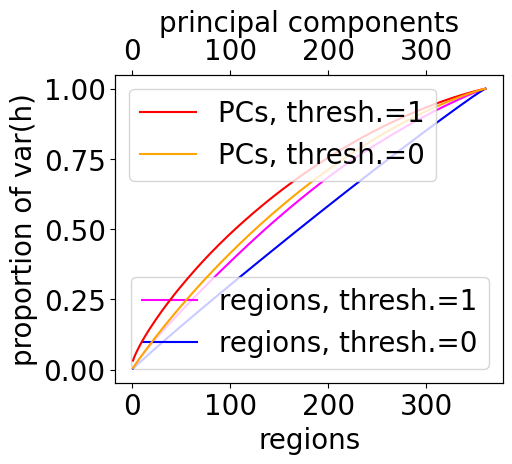

In [90]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax2 = ax.twiny()
node_ranks = torch.arange( start=1, end=proportion_of_variance_original_h_0.numel()+1, dtype=float_type, device=device )
ax2.plot( depytorch(node_ranks), depytorch(proportion_of_variance_pca_h_1), color='red', label='PCs, thresh.=1' )
ax2.plot( depytorch(node_ranks), depytorch(proportion_of_variance_pca_h_0), color='orange', label='PCs, thresh.=0' )
ax.plot( depytorch(node_ranks), depytorch(proportion_of_variance_original_h_1), color='magenta', label='regions, thresh.=1' )
ax.plot( depytorch(node_ranks), depytorch(proportion_of_variance_original_h_0), color='blue', label='regions, thresh.=0' )
ax2.set_xlabel('principal components')
ax.set_xlabel('regions')
ax.set_ylabel('proportion of var(h)')
# ax.legend(loc=[1.05, 0.25])
ax2.legend(loc='upper left')
ax.legend(loc='lower right')

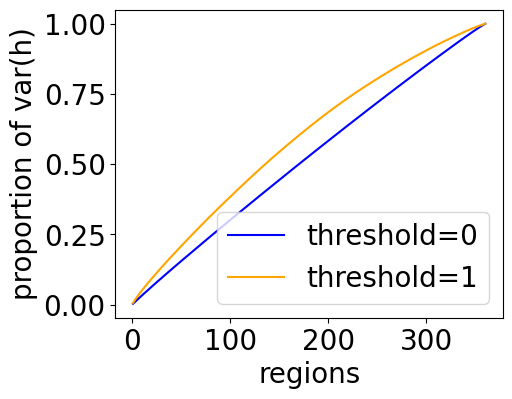

In [91]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
node_ranks = torch.arange( start=1, end=proportion_of_variance_original_h_0.numel()+1, dtype=float_type, device=device )
ax.plot( depytorch(node_ranks), depytorch(proportion_of_variance_original_h_0), color='blue', label='threshold=0' )
ax.plot( depytorch(node_ranks), depytorch(proportion_of_variance_original_h_1), color='orange', label='threshold=1' )
ax.set_xlabel('regions')
ax.set_ylabel('proportion of var(h)')
ax.legend()

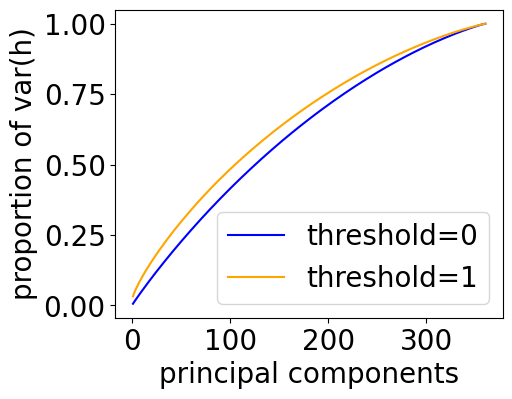

In [92]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
node_ranks = torch.arange( start=1, end=proportion_of_variance_original_h_0.numel()+1, dtype=float_type, device=device )
ax.plot( depytorch(node_ranks), depytorch(proportion_of_variance_pca_h_0), color='blue', label='threshold=0' )
ax.plot( depytorch(node_ranks), depytorch(proportion_of_variance_pca_h_1), color='orange', label='threshold=1' )
ax.set_xlabel('principal components')
ax.set_ylabel('proportion of var(h)')
ax.legend()

In [207]:
pca_J_0 = torch.load( os.path.join(file_dir, f'pca_J_beta_subj_0_to_837_iter_20000_ising_model_light_all_mean_std_0_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_66_popt_steps_10000.pt'), weights_only=False )
print( len(pca_J_0) )

7


In [78]:
pca_J_0 = torch.load( os.path.join(file_dir, f'pca_J_beta_subj_0_to_837_iter_200_ising_model_light_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000.pt'), weights_only=False )
print( len(pca_J_0) )

7


In [79]:
U_J_0 = pca_J_0[0]
print( 'U_J_0 size', U_J_0.size() )
S_J_0 = pca_J_0[1]
print( 'S_J_0 size', S_J_0.size() )
V_J_0 = pca_J_0[2] 
print( 'V_J_0 size', V_J_0.size() )
proportion_of_variance_original_J_0 = pca_J_0[3]
print( 'proportion_of_variance_original_J_0 size', proportion_of_variance_original_J_0.size() )
proportion_of_variance_pca_J_0 = pca_J_0[4]
print( 'proportion_of_variance_pca_J_0 size', proportion_of_variance_pca_J_0.size() )
components_needed_original_J_0 = pca_J_0[5]
print( 'components_needed_original_J_0 size', components_needed_original_J_0.size() )
components_needed_pca_J_0 = pca_J_0[6]
print( 'components_needed_pca_J_0 size', components_needed_pca_J_0.size() )

U_J_0 size torch.Size([837, 837])
S_J_0 size torch.Size([837])
V_J_0 size torch.Size([64620, 837])
proportion_of_variance_original_J_0 size torch.Size([64620])
proportion_of_variance_pca_J_0 size torch.Size([837])
components_needed_original_J_0 size torch.Size([])
components_needed_pca_J_0 size torch.Size([])


In [209]:
pca_J_1 = torch.load( os.path.join(file_dir, f'pca_J_beta_subj_0_to_837_iter_20000_ising_model_light_all_mean_std_1_medium_init_uncentered_reps_5_lr_0.01_steps_1200_pupd_per_bopt_1000_num_opt_1_bopt_steps_68_popt_steps_40000.pt'), weights_only=False )
print( len(pca_J_1) )

7


In [75]:
pca_J_1 = torch.load( os.path.join(file_dir, f'pca_J_beta_subj_0_to_837_iter_200_ising_model_light_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000.pt'), weights_only=False )
print( len(pca_J_1) )

7


In [76]:
U_J_1 = pca_J_1[0]
print( 'U_J_1 size', U_J_1.size() )
S_J_1 = pca_J_1[1]
print( 'S_J_1 size', S_J_1.size() )
V_J_1 = pca_J_1[2] 
print( 'V_J_1 size', V_J_1.size() )
proportion_of_variance_original_J_1 = pca_J_1[3]
print( 'proportion_of_variance_original_J_1 size', proportion_of_variance_original_J_1.size() )
proportion_of_variance_pca_J_1 = pca_J_1[4]
print( 'proportion_of_variance_pca_J_1 size', proportion_of_variance_pca_J_1.size() )
components_needed_original_J_1 = pca_J_1[5]
print( 'components_needed_original_J_1 size', components_needed_original_J_1.size() )
components_needed_pca_J_1 = pca_J_1[6]
print( 'components_needed_pca_J_1 size', components_needed_pca_J_1.size() )

U_J_1 size torch.Size([837, 837])
S_J_1 size torch.Size([837])
V_J_1 size torch.Size([64620, 837])
proportion_of_variance_original_J_1 size torch.Size([64620])
proportion_of_variance_pca_J_1 size torch.Size([837])
components_needed_original_J_1 size torch.Size([])
components_needed_pca_J_1 size torch.Size([])


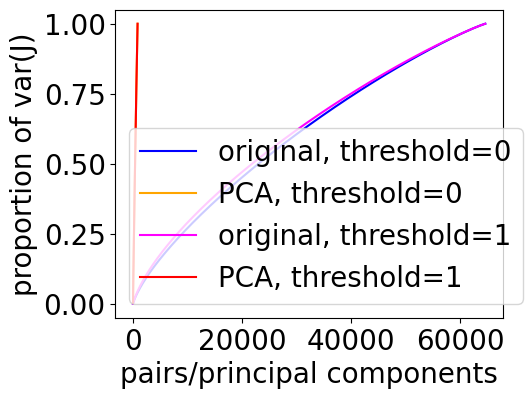

In [80]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
edge_ranks = torch.arange( start=1, end=proportion_of_variance_original_J_0.numel()+1, dtype=float_type, device=device )
edge_pc_ranks = torch.arange( start=1, end=proportion_of_variance_pca_J_0.numel()+1, dtype=float_type, device=device )
ax.plot( depytorch(edge_ranks), depytorch(proportion_of_variance_original_J_0), color='blue', label='original, threshold=0' )
ax.plot( depytorch(edge_pc_ranks), depytorch(proportion_of_variance_pca_J_0), color='orange', label='PCA, threshold=0' )
ax.plot( depytorch(edge_ranks), depytorch(proportion_of_variance_original_J_1), color='magenta', label='original, threshold=1' )
ax.plot( depytorch(edge_pc_ranks), depytorch(proportion_of_variance_pca_J_1), color='red', label='PCA, threshold=1' )
ax.set_xlabel('pairs/principal components')
ax.set_ylabel('proportion of var(J)')
ax.legend()

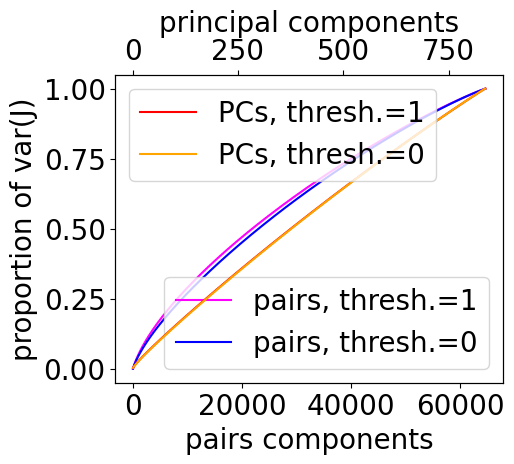

In [81]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax2 = ax.twiny()
edge_ranks = torch.arange( start=1, end=proportion_of_variance_original_J_0.numel()+1, dtype=float_type, device=device )
edge_pc_ranks = torch.arange( start=1, end=proportion_of_variance_pca_J_0.numel()+1, dtype=float_type, device=device )
ax.plot( depytorch(edge_ranks), depytorch(proportion_of_variance_original_J_1), color='magenta', label='pairs, thresh.=1' )
ax.plot( depytorch(edge_ranks), depytorch(proportion_of_variance_original_J_0), color='blue', label='pairs, thresh.=0' )
ax2.plot( depytorch(edge_pc_ranks), depytorch(proportion_of_variance_pca_J_1), color='red', label='PCs, thresh.=1' )
ax2.plot( depytorch(edge_pc_ranks), depytorch(proportion_of_variance_pca_J_0), color='orange', label='PCs, thresh.=0' )
ax.set_xlabel('pairs components')
ax2.set_xlabel('principal components')
ax.set_ylabel('proportion of var(J)')
ax.legend(loc='lower right')
ax2.legend(loc='upper left')

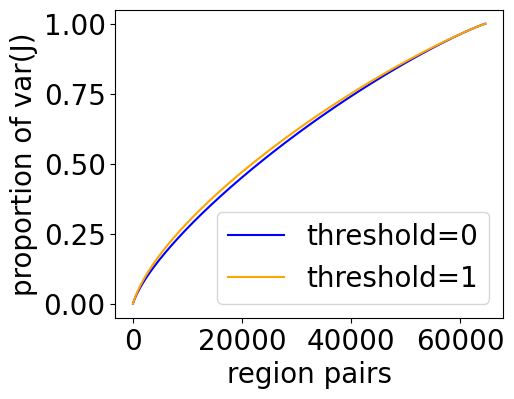

In [82]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
edge_ranks = torch.arange( start=1, end=proportion_of_variance_original_J_0.numel()+1, dtype=float_type, device=device )
edge_pc_ranks = torch.arange( start=1, end=proportion_of_variance_pca_J_0.numel()+1, dtype=float_type, device=device )
ax.plot( depytorch(edge_ranks), depytorch(proportion_of_variance_original_J_0), color='blue', label='threshold=0' )
ax.plot( depytorch(edge_ranks), depytorch(proportion_of_variance_original_J_1), color='orange', label='threshold=1' )
ax.set_xlabel('region pairs')
ax.set_ylabel('proportion of var(J)')
ax.legend()

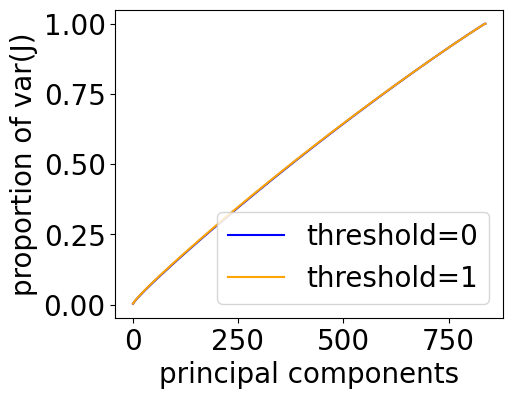

In [83]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
edge_ranks = torch.arange( start=1, end=proportion_of_variance_original_J_0.numel()+1, dtype=float_type, device=device )
edge_pc_ranks = torch.arange( start=1, end=proportion_of_variance_pca_J_0.numel()+1, dtype=float_type, device=device )
ax.plot( depytorch(edge_pc_ranks), depytorch(proportion_of_variance_pca_J_0), color='blue', label='threshold=0' )
ax.plot( depytorch(edge_pc_ranks), depytorch(proportion_of_variance_pca_J_1), color='orange', label='threshold=1' )
ax.set_xlabel('principal components')
ax.set_ylabel('proportion of var(J)')
ax.legend()

In [93]:
num_subjects = h_0.size(dim=0)
proportion_of_variance_pca_h_0_v_total = ( S_h_0.square()/(num_subjects-1) ).cumsum(dim=0) / torch.sum( h_0.var(dim=0) )
proportion_of_variance_pca_h_1_v_total = ( S_h_1.square()/(num_subjects-1) ).cumsum(dim=0) / torch.sum( h_1.var(dim=0) )
proportion_of_variance_pca_J_0_v_total = ( S_J_0.square()/(num_subjects-1) ).cumsum(dim=0) / torch.sum( J_0.var(dim=0) )
proportion_of_variance_pca_J_1_v_total = ( S_J_1.square()/(num_subjects-1) ).cumsum(dim=0) / torch.sum( J_1.var(dim=0) )

In [94]:
print( 'h 0', proportion_of_variance_pca_h_0_v_total[-1].item() )
print( 'h 1', proportion_of_variance_pca_h_1_v_total[-1].item() )
print( 'J 0', proportion_of_variance_pca_J_0_v_total[-1].item() )
print( 'J 1', proportion_of_variance_pca_J_1_v_total[-1].item() )

h 0 1.000108242034912
h 1 1.0000534057617188
J 0 1.0003540515899658
J 1 1.0003467798233032


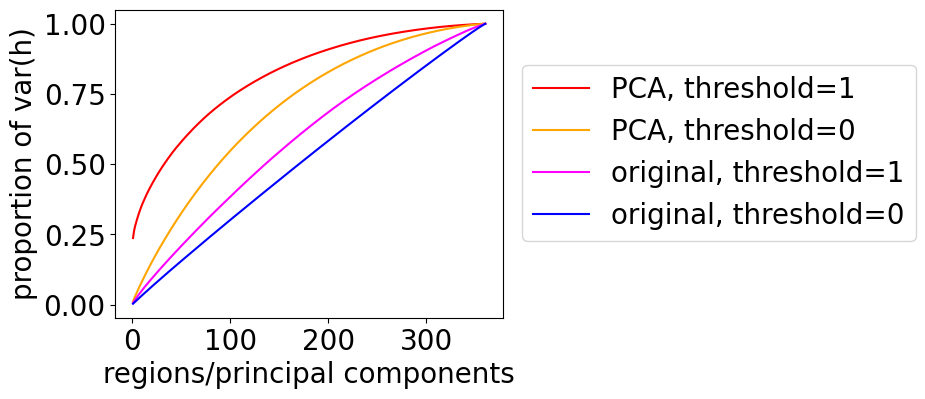

In [95]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
node_ranks = torch.arange( start=1, end=proportion_of_variance_original_h_0.numel()+1, dtype=float_type, device=device )
ax.plot( depytorch(node_ranks), depytorch(proportion_of_variance_pca_h_1_v_total), color='red', label='PCA, threshold=1' )
ax.plot( depytorch(node_ranks), depytorch(proportion_of_variance_pca_h_0_v_total), color='orange', label='PCA, threshold=0' )
ax.plot( depytorch(node_ranks), depytorch(proportion_of_variance_original_h_1), color='magenta', label='original, threshold=1' )
ax.plot( depytorch(node_ranks), depytorch(proportion_of_variance_original_h_0), color='blue', label='original, threshold=0' )
ax.set_xlabel('regions/principal components')
ax.set_ylabel('proportion of var(h)')
ax.legend(loc=[1.05, 0.25])

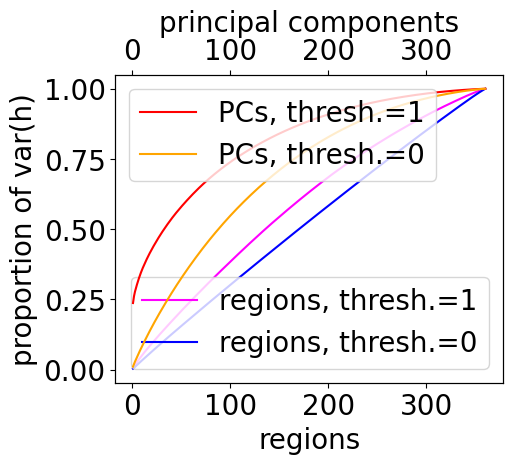

In [96]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax2 = ax.twiny()
node_ranks = torch.arange( start=1, end=proportion_of_variance_original_h_0.numel()+1, dtype=float_type, device=device )
ax2.plot( depytorch(node_ranks), depytorch(proportion_of_variance_pca_h_1_v_total), color='red', label='PCs, thresh.=1' )
ax2.plot( depytorch(node_ranks), depytorch(proportion_of_variance_pca_h_0_v_total), color='orange', label='PCs, thresh.=0' )
ax.plot( depytorch(node_ranks), depytorch(proportion_of_variance_original_h_1), color='magenta', label='regions, thresh.=1' )
ax.plot( depytorch(node_ranks), depytorch(proportion_of_variance_original_h_0), color='blue', label='regions, thresh.=0' )
ax2.set_xlabel('principal components')
ax.set_xlabel('regions')
ax.set_ylabel('proportion of var(h)')
# ax.legend(loc=[1.05, 0.25])
ax2.legend(loc='upper left')
ax.legend(loc='lower right')

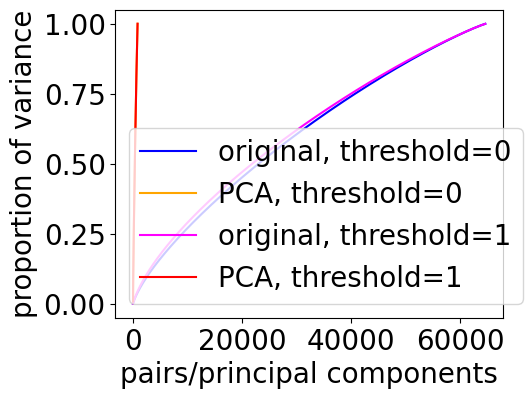

In [97]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
edge_ranks = torch.arange( start=1, end=proportion_of_variance_original_J_0.numel()+1, dtype=float_type, device=device )
edge_pc_ranks = torch.arange( start=1, end=proportion_of_variance_pca_J_0_v_total.numel()+1, dtype=float_type, device=device )
ax.plot( depytorch(edge_ranks), depytorch(proportion_of_variance_original_J_0), color='blue', label='original, threshold=0' )
ax.plot( depytorch(edge_pc_ranks), depytorch(proportion_of_variance_pca_J_0_v_total), color='orange', label='PCA, threshold=0' )
ax.plot( depytorch(edge_ranks), depytorch(proportion_of_variance_original_J_1), color='magenta', label='original, threshold=1' )
ax.plot( depytorch(edge_pc_ranks), depytorch(proportion_of_variance_pca_J_1_v_total), color='red', label='PCA, threshold=1' )
ax.set_xlabel('pairs/principal components')
ax.set_ylabel('proportion of variance')
ax.legend()

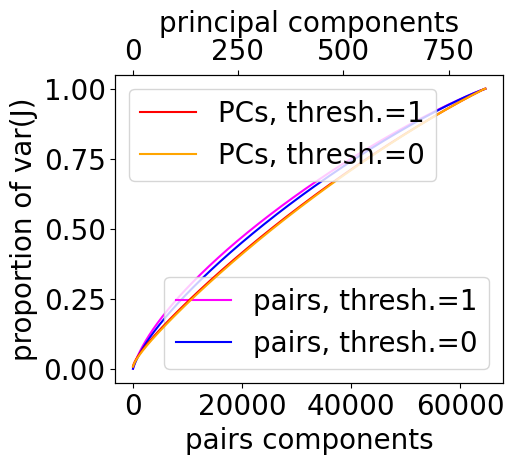

In [98]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
ax2 = ax.twiny()
edge_ranks = torch.arange( start=1, end=proportion_of_variance_original_J_0.numel()+1, dtype=float_type, device=device )
edge_pc_ranks = torch.arange( start=1, end=proportion_of_variance_pca_J_0.numel()+1, dtype=float_type, device=device )
ax.plot( depytorch(edge_ranks), depytorch(proportion_of_variance_original_J_1), color='magenta', label='pairs, thresh.=1' )
ax.plot( depytorch(edge_ranks), depytorch(proportion_of_variance_original_J_0), color='blue', label='pairs, thresh.=0' )
ax2.plot( depytorch(edge_pc_ranks), depytorch(proportion_of_variance_pca_J_1_v_total), color='red', label='PCs, thresh.=1' )
ax2.plot( depytorch(edge_pc_ranks), depytorch(proportion_of_variance_pca_J_0_v_total), color='orange', label='PCs, thresh.=0' )
ax.set_xlabel('pairs components')
ax2.set_xlabel('principal components')
ax.set_ylabel('proportion of var(J)')
ax.legend(loc='lower right')
ax2.legend(loc='upper left')

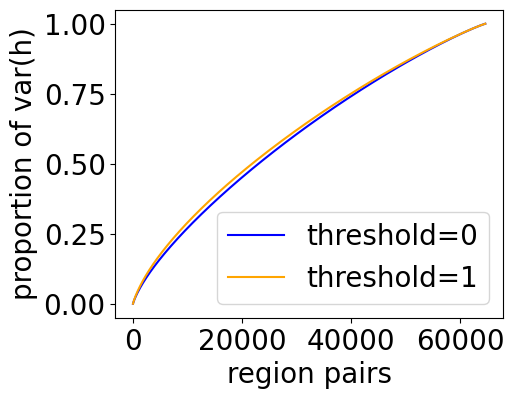

In [99]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
edge_ranks = torch.arange( start=1, end=proportion_of_variance_original_J_0.numel()+1, dtype=float_type, device=device )
ax.plot( depytorch(edge_ranks), depytorch(proportion_of_variance_original_J_0), color='blue', label='threshold=0' )
ax.plot( depytorch(edge_ranks), depytorch(proportion_of_variance_original_J_1), color='orange', label='threshold=1' )
ax.set_xlabel('region pairs')
ax.set_ylabel('proportion of var(h)')
ax.legend()

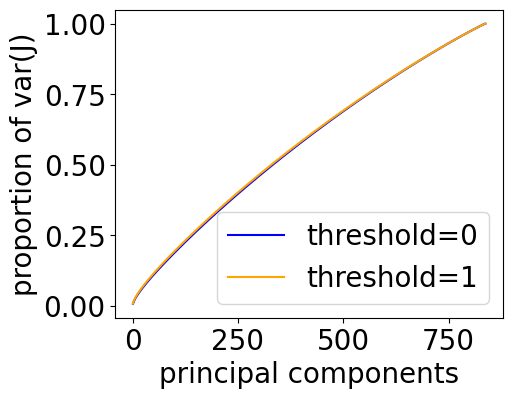

In [100]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
edge_pc_ranks = torch.arange( start=1, end=proportion_of_variance_pca_J_0_v_total.numel()+1, dtype=float_type, device=device )
ax.plot( depytorch(edge_pc_ranks), depytorch(proportion_of_variance_pca_J_0_v_total), color='blue', label='threshold=0' )
ax.plot( depytorch(edge_pc_ranks), depytorch(proportion_of_variance_pca_J_1_v_total), color='orange', label='threshold=1' )
ax.set_xlabel('principal components')
ax.set_ylabel('proportion of var(J)')
ax.legend()

In [101]:
def get_components_needed(cumulative_proportion:torch.Tensor):
    return torch.count_nonzero(cumulative_proportion < 0.95) + 1
components_needed_pca_h_0_v_total = get_components_needed(proportion_of_variance_pca_h_0_v_total)
components_needed_pca_h_1_v_total = get_components_needed(proportion_of_variance_pca_h_1_v_total)
components_needed_pca_J_0_v_total = get_components_needed(proportion_of_variance_pca_J_0_v_total)
components_needed_pca_J_1_v_total = get_components_needed(proportion_of_variance_pca_J_1_v_total)

In [102]:
print(f'The top {components_needed_original_h_0} regions or top {components_needed_pca_h_0_v_total} of {num_nodes} PCs capture 95% of the variance of h for threshold 0.')
print(f'The top {components_needed_original_h_1} regions or top {components_needed_pca_h_1_v_total} of {num_nodes} PCs capture 95% of the variance of h for threshold 1.')
print(f'The top {components_needed_original_J_0} of {num_edges} region pairs or top {components_needed_pca_J_0_v_total} of {num_edge_pcs} PCs capture 95% of the variance of J for threshold 0.')
print(f'The top {components_needed_original_J_1} of {num_edges} region pairs or top {components_needed_pca_J_1_v_total} of {num_edge_pcs} PCs capture 95% of the variance of J for threshold 1.')

The top 339 regions or top 283 of 360 PCs capture 95% of the variance of h for threshold 0.
The top 326 regions or top 245 of 360 PCs capture 95% of the variance of h for threshold 1.
The top 58649 of 64620 region pairs or top 773 of 837 PCs capture 95% of the variance of J for threshold 0.
The top 58551 of 64620 region pairs or top 773 of 837 PCs capture 95% of the variance of J for threshold 1.


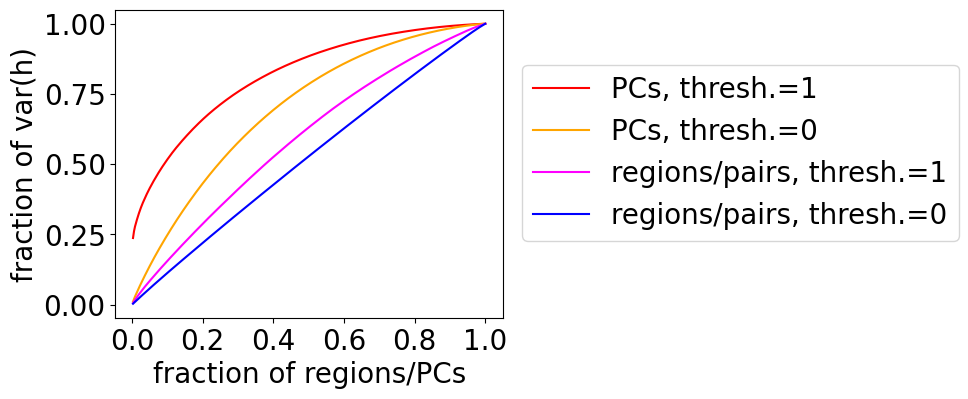

In [108]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
num_nodes = proportion_of_variance_original_h_0.numel()
node_ranks = torch.arange( start=1, end=num_nodes+1, dtype=float_type, device=device )
node_rank_fraction_np = depytorch(node_ranks/num_nodes)
ax.plot( node_rank_fraction_np, depytorch(proportion_of_variance_pca_h_1_v_total), color='red', label='PCs, thresh.=1' )
ax.plot( node_rank_fraction_np, depytorch(proportion_of_variance_pca_h_0_v_total), color='orange', label='PCs, thresh.=0' )
ax.plot( node_rank_fraction_np, depytorch(proportion_of_variance_original_h_1), color='magenta', label='regions/pairs, thresh.=1' )
ax.plot( node_rank_fraction_np, depytorch(proportion_of_variance_original_h_0), color='blue', label='regions/pairs, thresh.=0' )
ax.set_xticks( np.arange(0.0, 1.2, 0.2) )
ax.set_xlabel('fraction of regions/PCs')
ax.set_ylabel('fraction of var(h)')
ax.legend(loc=[1.05, 0.25])
# ax.legend(loc='lower right')

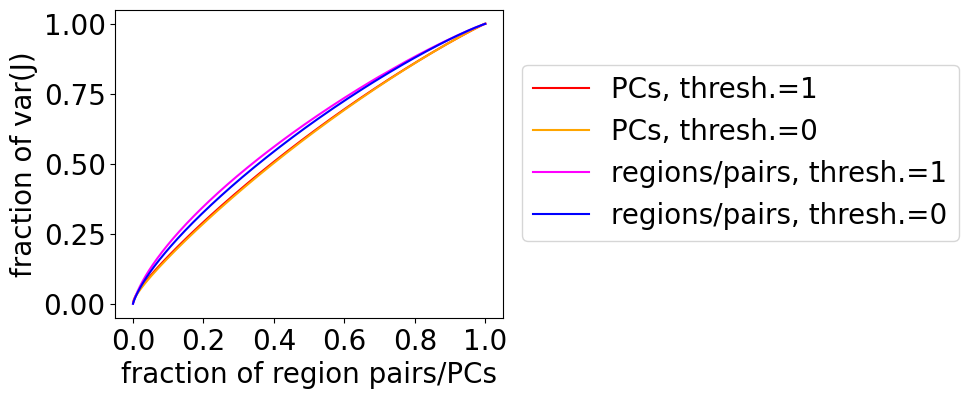

In [109]:
fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(5, 4) )
num_edges = proportion_of_variance_original_J_0.numel()
edge_ranks = torch.arange( start=1, end=num_edges+1, dtype=float_type, device=device )
edge_rank_fraction_np = depytorch(edge_ranks/num_edges)
num_edge_pcs = proportion_of_variance_pca_J_0_v_total.numel()
edge_pc_ranks = torch.arange( start=1, end=num_edge_pcs+1, dtype=float_type, device=device )
edge_pc_rank_fraction_np = depytorch(edge_pc_ranks/num_edge_pcs)
ax.plot( edge_pc_rank_fraction_np, depytorch(proportion_of_variance_pca_J_1_v_total), color='red', label='PCs, thresh.=1' )
ax.plot( edge_pc_rank_fraction_np, depytorch(proportion_of_variance_pca_J_0_v_total), color='orange', label='PCs, thresh.=0' )
ax.plot( edge_rank_fraction_np, depytorch(proportion_of_variance_original_J_1), color='magenta', label='regions/pairs, thresh.=1' )
ax.plot( edge_rank_fraction_np, depytorch(proportion_of_variance_original_J_0), color='blue', label='regions/pairs, thresh.=0' )
ax.set_xticks( np.arange(0.0, 1.2, 0.2) )
ax.set_xlabel('fraction of region pairs/PCs')
ax.set_ylabel('fraction of var(J)')
ax.legend(loc=[1.05, 0.25])
# ax.legend(loc='lower right')

In [110]:
print( num_edges, num_edge_pcs )

64620 837


In [79]:
fc_corr_group = torch.load( f=os.path.join(file_dir, 'fc_corr_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_test_length_120000.pt'), weights_only=False )
print( fc_corr_group.size() )

torch.Size([101, 31])


In [80]:
min_corr = torch.min(fc_corr_group, dim=0).values
median_corr = torch.median(fc_corr_group, dim=0).values
max_corr = torch.max(fc_corr_group, dim=0).values
print(  torch.stack( tensors=(threshold, min_corr, median_corr, max_corr), dim=-1 )  )

tensor([[ 0.0000e+00,  9.8842e-01,  9.9753e-01,  9.9922e-01],
        [ 1.0000e-01,  9.9018e-01,  9.9761e-01,  9.9920e-01],
        [ 2.0000e-01,  9.8624e-01,  9.9718e-01,  9.9891e-01],
        [ 3.0000e-01,  9.8812e-01,  9.9725e-01,  9.9909e-01],
        [ 4.0000e-01,  9.8476e-01,  9.9705e-01,  9.9893e-01],
        [ 5.0000e-01,  9.8165e-01,  9.9681e-01,  9.9873e-01],
        [ 6.0000e-01,  9.8591e-01,  9.9630e-01,  9.9805e-01],
        [ 7.0000e-01,  9.8977e-01,  9.9534e-01,  9.9721e-01],
        [ 8.0000e-01,  9.8523e-01,  9.9246e-01,  9.9561e-01],
        [ 9.0000e-01,  9.7962e-01,  9.8856e-01,  9.9260e-01],
        [ 1.0000e+00,  9.4272e-01,  9.8209e-01,  9.8826e-01],
        [ 1.1000e+00,  8.4999e-01,  9.7217e-01,  9.8286e-01],
        [ 1.2000e+00,  7.9966e-01,  9.6055e-01,  9.7478e-01],
        [ 1.3000e+00,  6.3295e-01,  9.4549e-01,  9.6580e-01],
        [ 1.4000e+00,  4.1328e-01,  9.0592e-01,  9.4468e-01],
        [ 1.5000e+00,  2.5482e-01,  8.2177e-01,  9.1537e-01],
        

In [85]:
group_data_mean_state = torch.load( os.path.join(file_dir, f'mean_state_thresholds_31_min_0_max_3.pt'), weights_only=False )
print( group_data_mean_state.size() )

torch.Size([31, 360])


In [86]:
group_data_has_variance = group_data_mean_state.abs() < 1.0
group_data_all_regions_have_variance = torch.all(group_data_has_variance, dim=-1)
print(threshold[group_data_all_regions_have_variance])

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
        1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000,
        2.7000, 2.8000, 2.9000, 3.0000], device='cuda:0')


In [87]:
print( group_data_mean_state.min(dim=-1).values )
print( group_data_mean_state.max(dim=-1).values )

tensor([-0.0201, -0.1054, -0.1946, -0.2794, -0.3592, -0.4336, -0.5021, -0.5639,
        -0.6201, -0.6705, -0.7173, -0.7587, -0.7953, -0.8278, -0.8560, -0.8807,
        -0.9034, -0.9223, -0.9381, -0.9508, -0.9614, -0.9700, -0.9768, -0.9822,
        -0.9864, -0.9897, -0.9922, -0.9941, -0.9957, -0.9968, -0.9977],
       device='cuda:0')
tensor([ 0.0191, -0.0660, -0.1500, -0.2326, -0.3113, -0.3857, -0.4556, -0.5208,
        -0.5816, -0.6370, -0.6867, -0.7314, -0.7710, -0.8062, -0.8364, -0.8613,
        -0.8834, -0.9022, -0.9186, -0.9326, -0.9440, -0.9532, -0.9610, -0.9675,
        -0.9731, -0.9778, -0.9818, -0.9851, -0.9878, -0.9899, -0.9918],
       device='cuda:0')


In [88]:
group_data_std = torch.sqrt( 1 - torch.square(group_data_mean_state) )

In [90]:
group_data_std_min = group_data_std.min(dim=-1).values
print(  torch.stack( (threshold, group_data_std_min), dim=-1 )  )

tensor([[0.0000, 0.9998],
        [0.1000, 0.9944],
        [0.2000, 0.9809],
        [0.3000, 0.9602],
        [0.4000, 0.9333],
        [0.5000, 0.9011],
        [0.6000, 0.8648],
        [0.7000, 0.8259],
        [0.8000, 0.7845],
        [0.9000, 0.7419],
        [1.0000, 0.6968],
        [1.1000, 0.6514],
        [1.2000, 0.6062],
        [1.3000, 0.5610],
        [1.4000, 0.5170],
        [1.5000, 0.4736],
        [1.6000, 0.4288],
        [1.7000, 0.3866],
        [1.8000, 0.3465],
        [1.9000, 0.3099],
        [2.0000, 0.2753],
        [2.1000, 0.2433],
        [2.2000, 0.2143],
        [2.3000, 0.1877],
        [2.4000, 0.1642],
        [2.5000, 0.1431],
        [2.6000, 0.1249],
        [2.7000, 0.1081],
        [2.8000, 0.0930],
        [2.9000, 0.0801],
        [3.0000, 0.0683]], device='cuda:0')


In [92]:
individual_0_data_mean_state = torch.load( os.path.join(other_file_dir, f'mean_state_all_mean_std_0.pt'), weights_only=False )
print( individual_0_data_mean_state.size() )

torch.Size([4, 837, 360])


In [93]:
individual_0_data_mean_state_scans_combined = individual_0_data_mean_state.mean(dim=0)
individual_0_data_std = torch.sqrt( 1 - torch.square(individual_0_data_mean_state_scans_combined) )

In [94]:
print( individual_0_data_std.min().item() )

0.9879144430160522


In [95]:
individual_1_data_mean_state = torch.load( os.path.join(other_file_dir, f'mean_state_all_mean_std_1.pt'), weights_only=False )
print( individual_1_data_mean_state.size() )

torch.Size([4, 837, 360])


In [96]:
individual_1_data_mean_state_scans_combined = individual_1_data_mean_state.mean(dim=0)
individual_1_data_std = torch.sqrt( 1 - torch.square(individual_1_data_mean_state_scans_combined) )

In [97]:
print( individual_1_data_std.min().item() )

0.47881340980529785


In [5]:
data_ts_all_as_is = torch.load( os.path.join(other_file_dir, f'data_ts_all_as_is.pt'), weights_only=False )
print( data_ts_all_as_is.size() )

torch.Size([4, 837, 360, 1200])


In [6]:
data_ts_all_as_is = torch.permute( input=data_ts_all_as_is, dims=(1,2,0,3) ).flatten(start_dim=-2, end_dim=-1)
print( data_ts_all_as_is.size() )

torch.Size([837, 360, 4800])


In [7]:
data_ts_all_as_is_std, data_ts_all_as_is_mean = torch.std_mean(data_ts_all_as_is, dim=-1, keepdim=True)
data_ts_all_as_is -= data_ts_all_as_is_mean
data_ts_all_as_is /= data_ts_all_as_is_std

In [8]:
threshold = 0.0
num_time_points = data_ts_all_as_is.size(dim=-1)
num_high = torch.count_nonzero(data_ts_all_as_is > threshold, dim=-1)
num_none_high = torch.count_nonzero(num_high == 0)
num_all_high = torch.count_nonzero(num_high == num_time_points)
print( num_none_high, num_all_high )

OutOfMemoryError: CUDA out of memory. Tried to allocate 10.78 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 6.74 GiB is allocated by PyTorch, and 4.04 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [122]:
num_steps = 64
step_increment = 1000
fc_corr_first = torch.load( os.path.join(other_file_dir, 'fc_corr_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_0_test_length_120000.pt'), weights_only=False )
print( fc_corr_first.size() )
num_reps, num_thresholds = fc_corr_first.size()
fc_corr_dtype = fc_corr_first.dtype
fc_corr_device = fc_corr_first.device

torch.Size([101, 31])


In [124]:
# fc_corr_series_init_means = torch.load( os.path.join(file_dir, 'fc_corr_summary_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_updates_min_1000_max_63000_increment_1000.pt'), weights_only=False )
fc_corr_series_init_means = torch.zeros( size=(num_steps, num_reps, num_thresholds), dtype=fc_corr_dtype, device=fc_corr_device )
for step_index in range(num_steps):
    num_updates = step_increment * step_index
    fc_corr_file_name = os.path.join(other_file_dir, f'fc_corr_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_{num_updates}_test_length_120000.pt')
    fc_corr_series_init_means[step_index,:,:] = torch.load(f=fc_corr_file_name, weights_only=False)
    print(f'loaded {fc_corr_file_name}')
print( fc_corr_series_init_means.size() )

loaded D:\Ising_model_results_daai\fc_corr_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_0_test_length_120000.pt
loaded D:\Ising_model_results_daai\fc_corr_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_1000_test_length_120000.pt
loaded D:\Ising_model_results_daai\fc_corr_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_2000_test_length_120000.pt
loaded D:\Ising_model_results_daai\fc_corr_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_3000_test_length_120000.pt
loaded D:\Ising_model_results_daai\fc_corr_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_4000_test_length_120000.pt
loaded D:\Ising_mo

In [37]:
# fc_corr_series_init_normal = torch.load( os.path.join(file_dir, 'fc_corr_summary_ising_model_light_group_init_normal_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_7_param_updates_updates_min_1000_max_33000_increment_1000.pt'), weights_only=False )
fc_corr_series_init_normal = torch.zeros( size=(num_steps, num_reps, num_thresholds), dtype=fc_corr_dtype, device=fc_corr_device )
for step_index in range(num_steps):
    num_updates = step_increment * step_index
    fc_corr_file_name = os.path.join(file_dir, f'fc_corr_ising_model_light_group_init_normal_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_7_param_updates_{num_updates}_test_length_120000.pt')
    fc_corr_series_init_normal[step_index,:,:] = torch.load(f=fc_corr_file_name, weights_only=False)
    print(f'loaded {fc_corr_file_name}')
print( fc_corr_series_init_normal.size() )

loaded E:\Ising_model_results_daai\fc_corr_ising_model_light_group_init_normal_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_7_param_updates_0_test_length_120000.pt
loaded E:\Ising_model_results_daai\fc_corr_ising_model_light_group_init_normal_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_7_param_updates_1000_test_length_120000.pt
loaded E:\Ising_model_results_daai\fc_corr_ising_model_light_group_init_normal_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_7_param_updates_2000_test_length_120000.pt
loaded E:\Ising_model_results_daai\fc_corr_ising_model_light_group_init_normal_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_7_param_updates_3000_test_length_120000.pt
loaded E:\Ising_model_results_daai\fc_corr_ising_model_light_group_init_normal_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_7

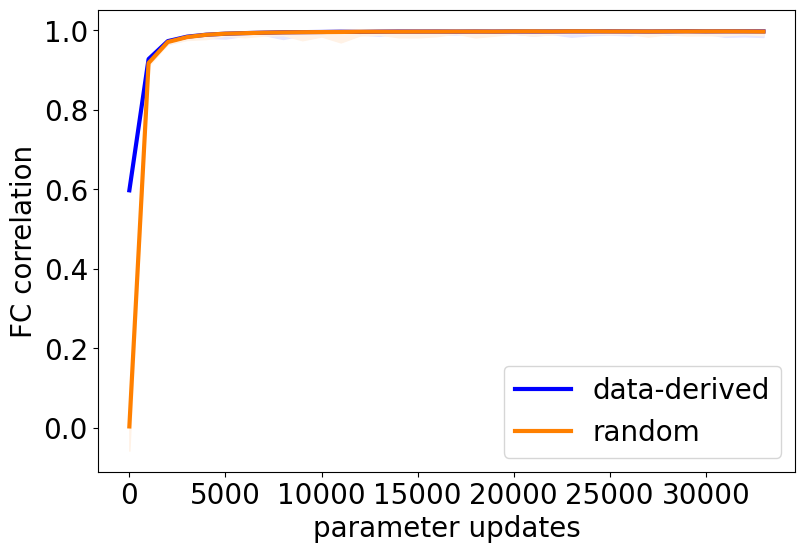

In [39]:
# num_steps = min( fc_corr_series_init_means.size(dim=0), fc_corr_series_init_normal.size(dim=0) )
step_increment = 1000
update_count_np = depytorch(  torch.arange( start=0, end=step_increment*num_steps, step=step_increment, dtype=torch.float, device=device )  )
line_width = 3.0
threshold_index = get_closest_match(values=threshold, target=0.0)
selected_threshold = threshold[threshold_index]
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
for fc_corr_series, summary_name, summary_cval in zip([fc_corr_series_init_means, fc_corr_series_init_normal],['data-derived', 'random'],[blue_cval, orange_cval]):
    fc_corr_series_at_threshold = fc_corr_series[:,:,threshold_index]
    fc_corr_median = depytorch( torch.median(fc_corr_series_at_threshold,dim=1).values )
    fc_corr_min = depytorch( torch.min(fc_corr_series_at_threshold,dim=1).values )
    fc_corr_max = depytorch( torch.max(fc_corr_series_at_threshold,dim=1).values )
    axs.fill_between( update_count_np, fc_corr_min, fc_corr_max, color=[0.9+0.1*c for c in summary_cval])# , label=f'thresh.={selected_threshold:.3g} range'
    axs.plot( update_count_np, fc_corr_median, color=summary_cval, linewidth=line_width, label=summary_name )# , label=f'thresh.={selected_threshold:.3g} median'
axs.legend(loc='lower right')# , bbox_to_anchor=(1.46, 0.5)
axs.set_xlabel('parameter updates')
axs.set_ylabel('FC correlation')
plt.show()

In [40]:
fc_corr_sim_convergence_0 = torch.load( f=os.path.join(file_dir, 'fc_corr_group_threshold_0_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_70_param_updates_10000_individual_updates_10000_steps_min_100_max_120000_inc_100.pt'), weights_only=False )
print( fc_corr_sim_convergence_0.size() )

torch.Size([1200, 5, 837])


In [41]:
fc_corr_sim_convergence_1 = torch.load( f=os.path.join(file_dir, 'fc_corr_group_threshold_1_betas_5_min_1e-10_max_0.01_beta_steps_1200_param_steps_1200_lr_0.01_beta_updates_68_param_updates_10000_individual_updates_45000_steps_min_100_max_120000_inc_100.pt'), weights_only=False )
print( fc_corr_sim_convergence_1.size() )

torch.Size([1200, 5, 837])


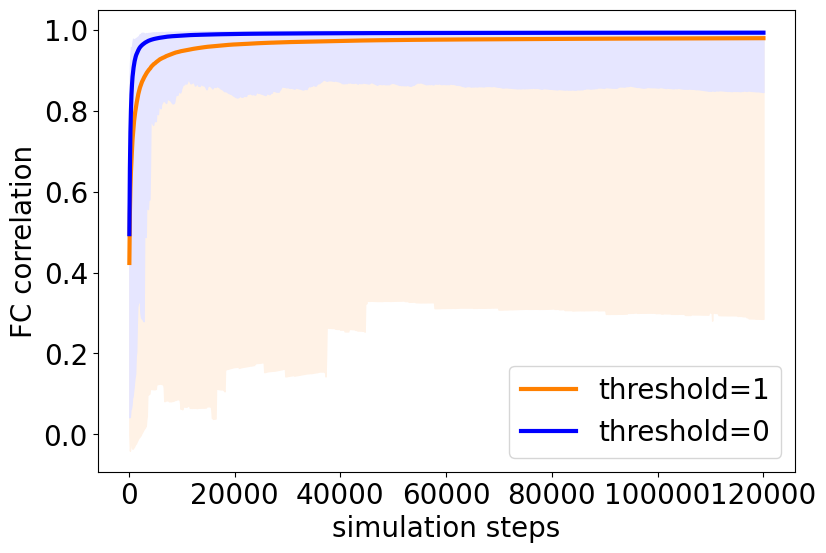

In [42]:
# num_steps = min( fc_corr_series_init_means.size(dim=0), fc_corr_series_init_normal.size(dim=0) )
step_increment = 100
num_steps = fc_corr_sim_convergence_0.size(dim=0)
step_count_np = depytorch(  torch.arange( start=step_increment, end=step_increment*(num_steps+1), step=step_increment, dtype=torch.float, device=device )  )
line_width = 3.0
threshold_index = get_closest_match(values=threshold, target=1.0)
selected_threshold = threshold[threshold_index]
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
for fc_corr_series, summary_name, summary_cval in zip([fc_corr_sim_convergence_1, fc_corr_sim_convergence_0],['threshold=1', 'threshold=0'],[orange_cval, blue_cval]):
    fc_corr_series_flat = fc_corr_series.flatten(start_dim=-2, end_dim=-1)
    fc_corr_median = depytorch( torch.median(fc_corr_series_flat,dim=1).values )
    fc_corr_min = depytorch( torch.min(fc_corr_series_flat,dim=1).values )
    fc_corr_max = depytorch( torch.max(fc_corr_series_flat,dim=1).values )
    axs.fill_between( step_count_np, fc_corr_min, fc_corr_max, color=[0.9+0.1*c for c in summary_cval])# , label=f'thresh.={selected_threshold:.3g} range'
    axs.plot( step_count_np, fc_corr_median, color=summary_cval, linewidth=line_width, label=summary_name )# , label=f'thresh.={selected_threshold:.3g} median'
axs.legend(loc='lower right')# , bbox_to_anchor=(1.46, 0.5)
axs.set_xlabel('simulation steps')
axs.set_ylabel('FC correlation')
plt.show()

In [15]:
fc_corr_single_scans_1 = torch.load( os.path.join(file_dir, 'fc_corr_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_to_thresh_1_reps_1_subj_3348_v1_individual_updates_40000_test_length_120000.pt'), weights_only=False )
print( fc_corr_single_scans_1.size() )

torch.Size([1, 3348])


In [16]:
fc_corr_single_scans_2 = torch.load( os.path.join(file_dir, 'fc_corr_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_to_thresh_1_reps_1_subj_3348_v2_individual_updates_40000_test_length_120000.pt'), weights_only=False )
print( fc_corr_single_scans_2.size() )

torch.Size([1, 3348])


In [17]:
fc_corr_single_scans_better = torch.maximum(fc_corr_single_scans_1, fc_corr_single_scans_2)
print( fc_corr_single_scans_better.size(), f'{fc_corr_single_scans_better.min():.3g}, {fc_corr_single_scans_better.median():.3g}, {fc_corr_single_scans_better.max():.3g}' )

torch.Size([1, 3348]) 0.37, 0.972, 0.994


In [18]:
print( torch.count_nonzero(fc_corr_single_scans_1 < 0.9) )
print( torch.count_nonzero(fc_corr_single_scans_2 < 0.9) )
print( torch.count_nonzero(fc_corr_single_scans_better < 0.9) )

tensor(231, device='cuda:0')
tensor(217, device='cuda:0')
tensor(47, device='cuda:0')


In [14]:
def unflatten_scans_subjects(m:torch.Tensor):
    return torch.unflatten( input=torch.squeeze(m, dim=0), dim=0, sizes=(4,-1) )

In [24]:
fc_corr_single_scans_1_unf = unflatten_scans_subjects(fc_corr_single_scans_1)
print( fc_corr_single_scans_1_unf.size() )

torch.Size([4, 837])


In [25]:
fc_corr_single_scans_2_unf = unflatten_scans_subjects(fc_corr_single_scans_2)
print( fc_corr_single_scans_2_unf.size() )

torch.Size([4, 837])


In [15]:
model_single_scans_1 = torch.load( os.path.join(file_dir, 'ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_to_thresh_1_reps_1_subj_3348_v1_individual_updates_40000.pt'), weights_only=False )
print( model_single_scans_1.h.size() )

torch.Size([1, 3348, 360])


In [16]:
h_single_scans_1_unf = unflatten_scans_subjects(model_single_scans_1.h)
print( h_single_scans_1_unf.size() )

torch.Size([4, 837, 360])


In [17]:
triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=model_single_scans_1.J.size(dim=-1), device=model_single_scans_1.J.device )
J_single_scans_1_unf = unflatten_scans_subjects(model_single_scans_1.J[:,:,triu_rows,triu_cols])
print( J_single_scans_1_unf.size() )

torch.Size([4, 837, 64620])


Text(0, 0.5, 'mean( SD(h) of scans ) of subjects')

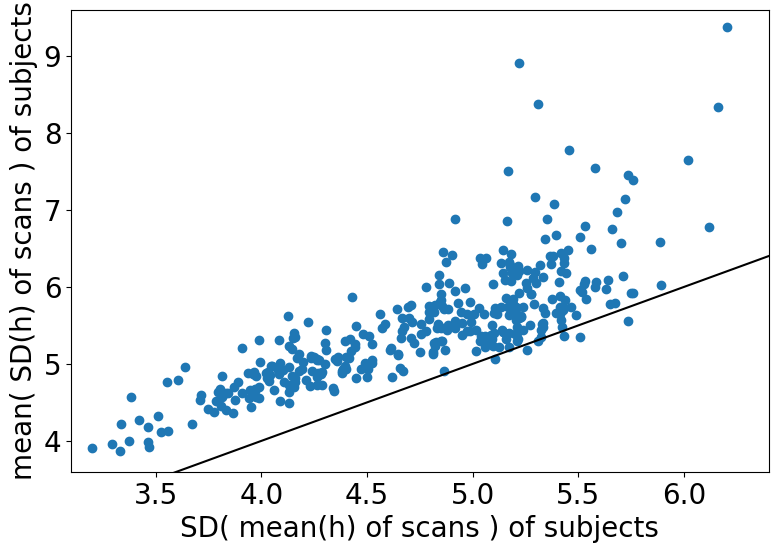

In [18]:
h_single_scans_1_unf_std_over_scans, h_single_scans_1_unf_mean_over_scans = torch.std_mean(h_single_scans_1_unf, dim=0)
h_single_scans_1_unf_std_over_subjects, h_single_scans_1_unf_mean_over_subjects = torch.std_mean(h_single_scans_1_unf_mean_over_scans, dim=0)
h_single_scans_1_unf_std_over_scans_mean = torch.mean(h_single_scans_1_unf_std_over_scans, dim=0)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
line_width = 3.0
axs.scatter( depytorch(h_single_scans_1_unf_std_over_subjects), depytorch(h_single_scans_1_unf_std_over_scans_mean) )
identity_line_points = np.arange(3.0, 10.0)
axs.plot( identity_line_points, identity_line_points, color='black' )
axs.set_xlim([3.1, 6.4])
axs.set_ylim([3.6, 9.6])
axs.set_xlabel('SD( mean(h) of scans ) of subjects')
axs.set_ylabel('mean( SD(h) of scans ) of subjects')

Text(0, 0.5, 'mean( SD(J) of scans ) of subjects')

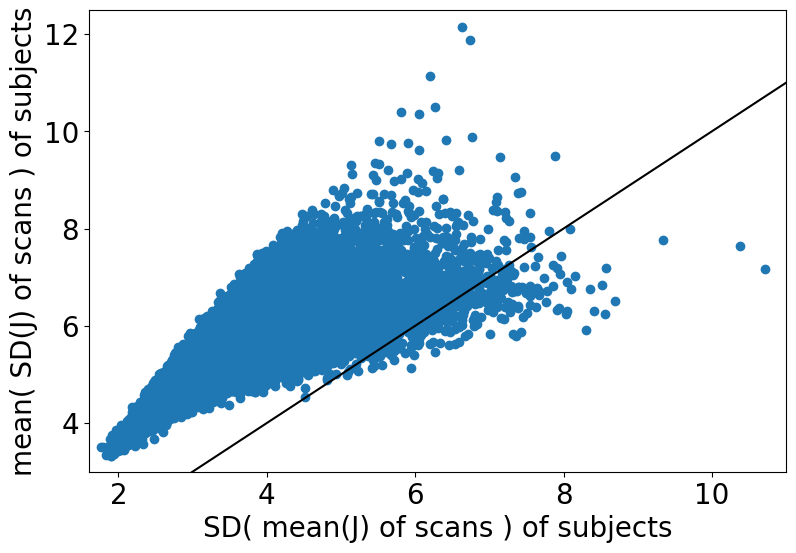

In [19]:
J_single_scans_1_unf_std_over_scans, J_single_scans_1_unf_mean_over_scans = torch.std_mean(J_single_scans_1_unf, dim=0)
J_single_scans_1_unf_std_over_subjects, J_single_scans_1_unf_mean_over_subjects = torch.std_mean(J_single_scans_1_unf_mean_over_scans, dim=0)
J_single_scans_1_unf_std_over_scans_mean = torch.mean(J_single_scans_1_unf_std_over_scans, dim=0)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
line_width = 3.0
axs.scatter( depytorch(J_single_scans_1_unf_std_over_subjects), depytorch(J_single_scans_1_unf_std_over_scans_mean) )
identity_line_points = np.arange(1.5, 13.0)
axs.plot( identity_line_points, identity_line_points, color='black' )
axs.set_xlim([1.6, 11])
axs.set_ylim([3, 12.5])
axs.set_xlabel('SD( mean(J) of scans ) of subjects')
axs.set_ylabel('mean( SD(J) of scans ) of subjects')

In [168]:
print( torch.count_nonzero(J_single_scans_1_unf_std_over_subjects < 0.1) )

tensor(0, device='cuda:0')


In [20]:
model_single_scans_2 = torch.load( os.path.join(file_dir, 'ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_40000_to_thresh_1_reps_1_subj_3348_v2_individual_updates_40000.pt'), weights_only=False )
print( model_single_scans_2.h.size() )

torch.Size([1, 3348, 360])


In [21]:
h_single_scans_2_unf = unflatten_scans_subjects(model_single_scans_2.h)
print( h_single_scans_2_unf.size() )

torch.Size([4, 837, 360])


In [22]:
J_single_scans_2_unf = unflatten_scans_subjects(model_single_scans_2.J[:,:,triu_rows,triu_cols])
print( J_single_scans_2_unf.size() )

torch.Size([4, 837, 64620])


In [23]:
h_single_scans_diff_unf = h_single_scans_1_unf - h_single_scans_2_unf
print( torch.min(h_single_scans_diff_unf).item(), torch.mean(h_single_scans_diff_unf).item(), torch.max(h_single_scans_diff_unf).item() )

-1.5907630920410156 -6.302694964688271e-05 1.0529136657714844


In [24]:
h_single_scans_diff_unf_abs = h_single_scans_diff_unf.abs()
print( torch.min(h_single_scans_diff_unf_abs).item(), torch.mean(h_single_scans_diff_unf_abs).item(), torch.max(h_single_scans_diff_unf_abs).item() )

0.0 0.0427461601793766 1.5907630920410156


In [25]:
J_single_scans_diff_unf = J_single_scans_1_unf - J_single_scans_2_unf
print( torch.min(J_single_scans_diff_unf).item(), torch.mean(J_single_scans_diff_unf).item(), torch.max(J_single_scans_diff_unf).item() )

-0.400285005569458 1.80921870196471e-05 0.28630733489990234


In [26]:
J_single_scans_diff_unf_abs = J_single_scans_diff_unf.abs()
print( torch.min(J_single_scans_diff_unf_abs).item(), torch.mean(J_single_scans_diff_unf_abs).item(), torch.max(J_single_scans_diff_unf_abs).item() )

0.0 0.02006116881966591 0.400285005569458


In [27]:
h_single_scans_1_unf_abs = h_single_scans_1_unf.abs()
print( h_single_scans_1_unf_abs.min().item(), h_single_scans_1_unf_abs.mean().item(), h_single_scans_1_unf_abs.max().item() )

1.3865206710761413e-05 9.285104751586914 75.50012969970703


In [28]:
h_single_scans_2_unf_abs = h_single_scans_2_unf.abs()
print( h_single_scans_2_unf_abs.min().item(), h_single_scans_2_unf_abs.mean().item(), h_single_scans_2_unf_abs.max().item() )

1.0551757441135123e-05 9.285103797912598 75.49750518798828


In [29]:
J_single_scans_1_unf_abs = J_single_scans_1_unf.abs()
print( J_single_scans_1_unf_abs.min().item(), J_single_scans_1_unf_abs.mean().item(), J_single_scans_1_unf_abs.max().item() )

2.6222551241517067e-08 5.413462162017822 122.01824188232422


In [30]:
J_single_scans_2_unf_abs = J_single_scans_2_unf.abs()
print( J_single_scans_2_unf_abs.min().item(), J_single_scans_2_unf_abs.mean().item(), J_single_scans_2_unf_abs.max().item() )

4.290450306143612e-08 5.413464069366455 121.99858093261719


In [31]:
h_single_scans_relative_diff_unf = 2*(h_single_scans_2_unf - h_single_scans_1_unf)/(h_single_scans_1_unf + h_single_scans_2_unf)
print( torch.min(h_single_scans_relative_diff_unf).item(), torch.mean(h_single_scans_relative_diff_unf).item(), torch.max(h_single_scans_relative_diff_unf).item() )

-3612.22900390625 -0.004349890630692244 3175.792724609375


In [32]:
h_single_scans_relative_diff_unf_abs = h_single_scans_relative_diff_unf.abs()
print( torch.min(h_single_scans_relative_diff_unf_abs).item(), torch.mean(h_single_scans_relative_diff_unf_abs).item(), torch.max(h_single_scans_relative_diff_unf_abs).item() )

0.0 0.053363680839538574 3612.22900390625


In [33]:
J_single_scans_relative_diff_unf = 2*(J_single_scans_2_unf - J_single_scans_1_unf)/(J_single_scans_1_unf + J_single_scans_2_unf)
print( torch.min(J_single_scans_relative_diff_unf).item(), torch.mean(J_single_scans_relative_diff_unf).item(), torch.max(J_single_scans_relative_diff_unf).item() )

-233708.390625 0.0017859895015135407 617507.5


In [34]:
J_single_scans_relative_diff_unf_abs = J_single_scans_relative_diff_unf.abs()
print( torch.min(J_single_scans_relative_diff_unf_abs).item(), torch.mean(J_single_scans_relative_diff_unf_abs).item(), torch.max(J_single_scans_relative_diff_unf_abs).item() )

0.0 0.05015316978096962 617507.5


In [31]:
h_single_scans_1_unf_scan_mean = h_single_scans_1_unf.mean(dim=0, keepdim=True)
h_single_scans_1_unf_scan_diff = h_single_scans_1_unf - h_single_scans_1_unf_scan_mean
h_single_scans_1_unf_group_mean = h_single_scans_1_unf_scan_mean.mean(dim=1, keepdim=True)
h_single_scans_1_unf_group_diff = h_single_scans_1_unf_scan_mean - h_single_scans_1_unf_group_mean

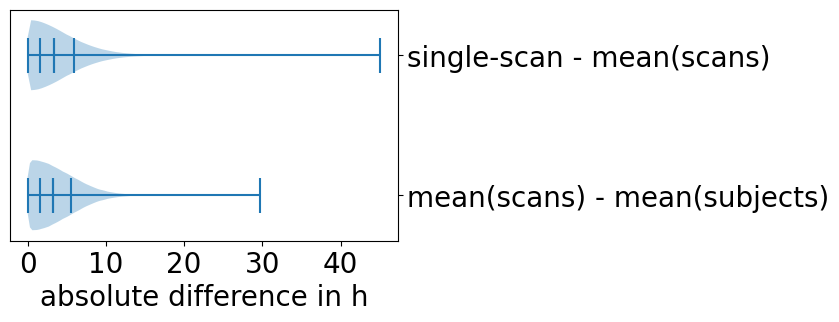

In [42]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 3) )
corr_labels = ['mean(scans) - mean(subjects)', 'single-scan - mean(scans)']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [ depytorch( param_diff.abs().flatten() ) for param_diff in [h_single_scans_1_unf_group_diff, h_single_scans_1_unf_scan_diff] ]
axs.violinplot( all_corrs, showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal' )
axs.set_yticks(label_x)
axs.set_xticks( range(0,50,10) )
# plt.yticks(rotation=45)
axs.set_yticklabels(corr_labels)
axs.yaxis.set_label_position("right")
axs.yaxis.tick_right()
axs.set_xlabel('absolute difference in h')
# axs.set_xlim([0.3, 1.1])
plt.show()

In [43]:
print([ param_diff.abs().median().item() for param_diff in [h_single_scans_1_unf_group_diff, h_single_scans_1_unf_scan_diff] ])

[3.290487289428711, 3.3916969299316406]


In [45]:
h_single_scans_2_unf_scan_mean = h_single_scans_2_unf.mean(dim=0, keepdim=True)
h_single_scans_2_unf_scan_diff = h_single_scans_2_unf - h_single_scans_1_unf_scan_mean
h_single_scans_2_unf_group_mean = h_single_scans_2_unf_scan_mean.mean(dim=1, keepdim=True)
h_single_scans_2_unf_group_diff = h_single_scans_2_unf_scan_mean - h_single_scans_2_unf_group_mean

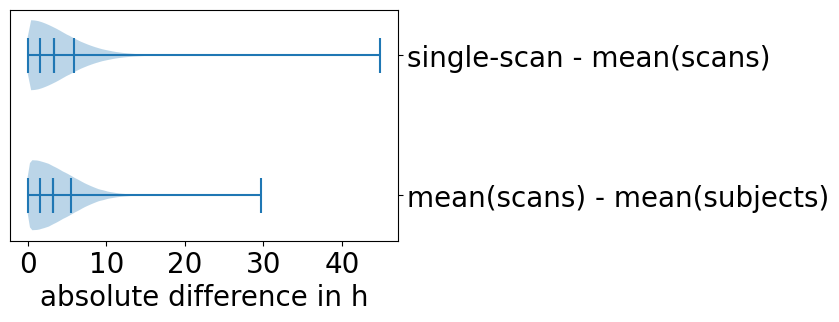

In [46]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 3) )
corr_labels = ['mean(scans) - mean(subjects)', 'single-scan - mean(scans)']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [ depytorch( param_diff.abs().flatten() ) for param_diff in [h_single_scans_2_unf_group_diff, h_single_scans_2_unf_scan_diff] ]
axs.violinplot( all_corrs, showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal' )
axs.set_yticks(label_x)
axs.set_xticks( range(0,50,10) )
# plt.yticks(rotation=45)
axs.set_yticklabels(corr_labels)
axs.yaxis.set_label_position("right")
axs.yaxis.tick_right()
axs.set_xlabel('absolute difference in h')
# axs.set_xlim([0.3, 1.1])
plt.show()

In [47]:
print([ param_diff.abs().median().item() for param_diff in [h_single_scans_2_unf_group_diff, h_single_scans_2_unf_scan_diff] ])

[3.289754629135132, 3.3916015625]


In [48]:
J_single_scans_1_unf_scan_mean = J_single_scans_1_unf.mean(dim=0, keepdim=True)
J_single_scans_1_unf_scan_diff = J_single_scans_1_unf - J_single_scans_1_unf_scan_mean
J_single_scans_1_unf_group_mean = J_single_scans_1_unf_scan_mean.mean(dim=1, keepdim=True)
J_single_scans_1_unf_group_diff = J_single_scans_1_unf_scan_mean - J_single_scans_1_unf_group_mean

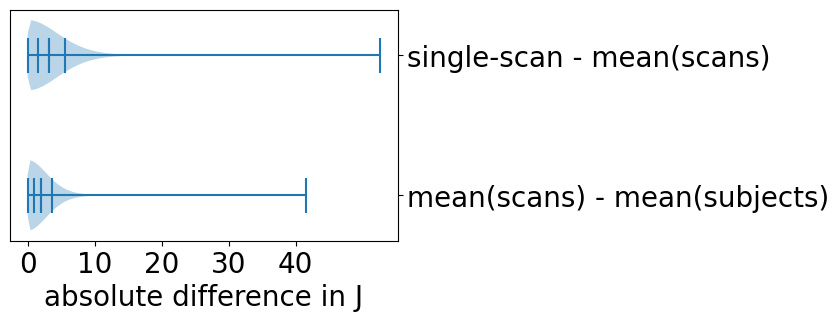

In [49]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 3) )
corr_labels = ['mean(scans) - mean(subjects)', 'single-scan - mean(scans)']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [ depytorch( param_diff.abs().flatten() ) for param_diff in [J_single_scans_1_unf_group_diff, J_single_scans_1_unf_scan_diff] ]
axs.violinplot( all_corrs, showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal' )
axs.set_yticks(label_x)
axs.set_xticks( range(0,50,10) )
# plt.yticks(rotation=45)
axs.set_yticklabels(corr_labels)
axs.yaxis.set_label_position("right")
axs.yaxis.tick_right()
axs.set_xlabel('absolute difference in J')
# axs.set_xlim([0.3, 1.1])
plt.show()

In [52]:
print([ param_diff.abs().median().item() for param_diff in [J_single_scans_1_unf_group_diff, J_single_scans_1_unf_scan_diff] ])

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.23 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 14.59 GiB is allocated by PyTorch, and 9.89 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [50]:
J_single_scans_2_unf_scan_mean = J_single_scans_2_unf.mean(dim=0, keepdim=True)
J_single_scans_2_unf_scan_diff = J_single_scans_2_unf - J_single_scans_2_unf_scan_mean
J_single_scans_2_unf_group_mean = J_single_scans_2_unf_scan_mean.mean(dim=1, keepdim=True)
J_single_scans_2_unf_group_diff = J_single_scans_2_unf_scan_mean - J_single_scans_2_unf_group_mean

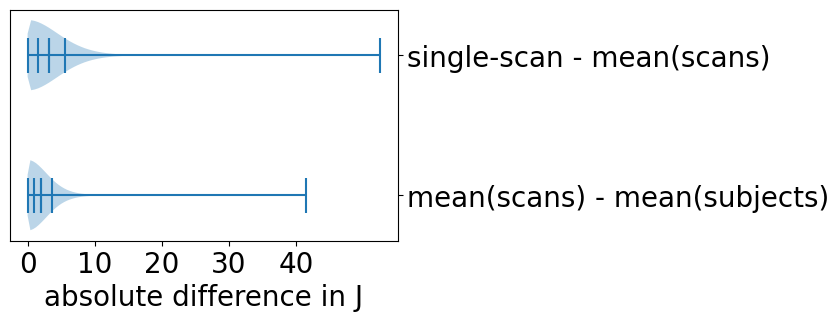

In [51]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 3) )
corr_labels = ['mean(scans) - mean(subjects)', 'single-scan - mean(scans)']
label_x = range( 1, len(corr_labels)+1 )
all_corrs = [ depytorch( param_diff.abs().flatten() ) for param_diff in [J_single_scans_2_unf_group_diff, J_single_scans_2_unf_scan_diff] ]
axs.violinplot( all_corrs, showmedians=True, quantiles=[[0.25, 0.5, 0.75]]*len(all_corrs), orientation='horizontal' )
axs.set_yticks(label_x)
axs.set_xticks( range(0,50,10) )
# plt.yticks(rotation=45)
axs.set_yticklabels(corr_labels)
axs.yaxis.set_label_position("right")
axs.yaxis.tick_right()
axs.set_xlabel('absolute difference in J')
# axs.set_xlim([0.3, 1.1])
plt.show()

In [40]:
mean_over_subjects_of_std_over_scans_h = torch.mean( torch.std(h_single_scans_1_unf, dim=0), dim=0 )
max_mean_std_h, max_mean_std_h_index = torch.max(mean_over_subjects_of_std_over_scans_h, dim=0)
print(max_mean_std_h, max_mean_std_h_index)

tensor(9.3796, device='cuda:0') tensor(165, device='cuda:0')


torch.Size([4, 837, 360])


Text(0, 0.5, 'individual scan h')

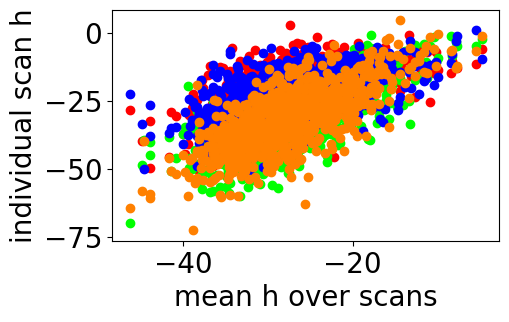

In [41]:
print( h_single_scans_1_unf.size() )
region_index = max_mean_std_h_index
h_region = h_single_scans_1_unf[:,:,region_index]
h_mean_over_scans = h_region.mean(dim=0)
num_scans = h_region.size(dim=0)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 3) )
for h_region_scan, scan_name, scan_cval in zip( [ h_region[scan_index,:] for scan_index in range(num_scans) ], ['day 1, LR', 'day 1, RL', 'day 2, LR', 'day 2, RL'], [red_cval, green_cval, blue_cval, orange_cval] ):
    axs.scatter( depytorch(h_mean_over_scans), depytorch(h_region_scan), color=scan_cval, label=scan_name )
axs.set_xlabel('mean h over scans')
axs.set_ylabel('individual scan h')

Text(0, 0.5, 'individual scan h')

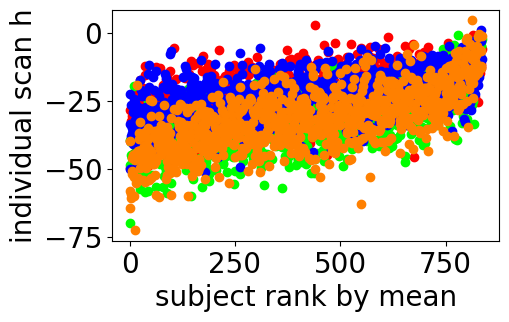

In [49]:
region_index = max_mean_std_h_index
h_region = h_single_scans_1_unf[:,:,region_index]
h_mean_over_scans = h_region.mean(dim=0)
h_mean_sorted, h_mean_sort_indices = torch.sort(h_mean_over_scans)
h_region_sorted = h_region[:,h_mean_sort_indices]
num_scans, num_subjects = h_region.size()
region_indices = depytorch( torch.arange(num_subjects) )
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 3) )
for h_region_scan, scan_name, scan_cval in zip( [ h_region_sorted[scan_index,:] for scan_index in range(num_scans) ], ['day 1, LR', 'day 1, RL', 'day 2, LR', 'day 2, RL'], [red_cval, green_cval, blue_cval, orange_cval] ):
    axs.scatter( region_indices, depytorch(h_region_scan), color=scan_cval, label=scan_name )
axs.set_xlabel('subject rank by mean')
axs.set_ylabel('individual scan h')

torch.Size([4, 837, 360])


Text(0, 0.5, 'h median, range over scans')

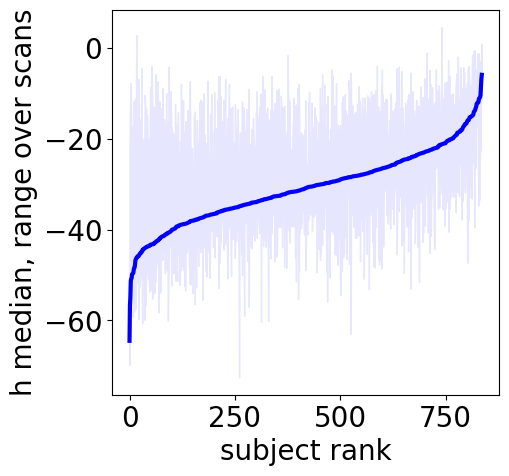

In [48]:
print( h_single_scans_1_unf.size() )
region_index = max_mean_std_h_index
h_region = h_single_scans_1_unf[:,:,region_index]
h_region_scan_min = h_region.min(dim=0).values
h_region_scan_median = h_region.median(dim=0).values
h_region_scan_max = h_region.max(dim=0).values
h_region_scan_median_sorted, h_region_scan_median_sort_indices = torch.sort(h_region_scan_median)
h_region_scan_min_sorted = h_region_scan_min[h_region_scan_median_sort_indices]
h_region_scan_max_sorted = h_region_scan_max[h_region_scan_median_sort_indices]
subject_indices = depytorch( torch.arange(num_subjects) )
summary_cval = blue_cval
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 5) )
axs.fill_between( subject_indices, depytorch(h_region_scan_min_sorted), depytorch(h_region_scan_max_sorted), color=[0.9+0.1*c for c in summary_cval])
axs.plot( subject_indices, depytorch(h_region_scan_median_sorted), color=summary_cval, linewidth=line_width )
axs.set_xlabel('subject rank')
axs.set_ylabel('h median, range over scans')

In [50]:
mean_over_subjects_of_std_over_scans_h = torch.mean( torch.std(h_single_scans_1_unf, dim=0), dim=0 )
mean_over_scans_of_std_over_subjects_h = torch.mean( torch.std(h_single_scans_1_unf, dim=1), dim=0 )

In [57]:
print(  ( torch.count_nonzero(mean_over_subjects_of_std_over_scans_h < mean_over_scans_of_std_over_subjects_h)/mean_over_scans_of_std_over_subjects_h.numel() ).item()  )

1.0


Text(0, 0.5, 'mean( SD(h) of scans ) of subjects')

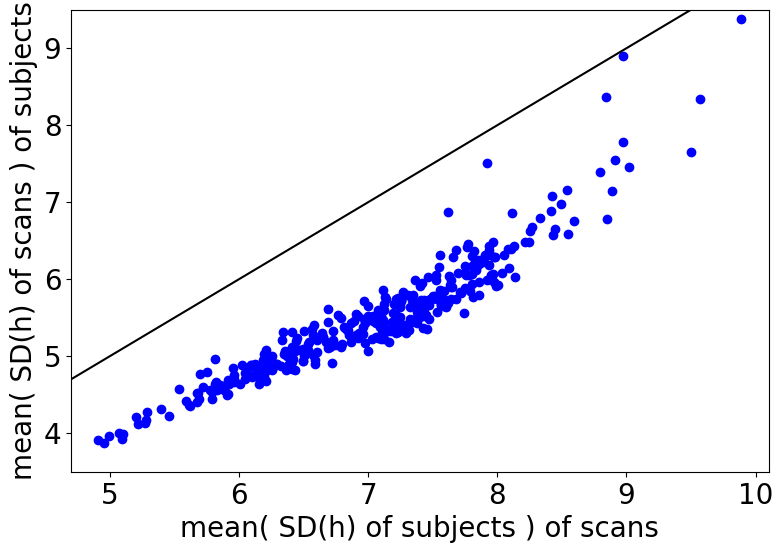

In [56]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
line_width = 3.0
axs.scatter( depytorch(mean_over_scans_of_std_over_subjects_h), depytorch(mean_over_subjects_of_std_over_scans_h), color='blue' )
identity_line_points = np.arange(3.5, 11.0)
axs.plot(identity_line_points, identity_line_points, color='black')
axs.set_xlim([4.7, 10.1])
axs.set_ylim([3.5, 9.5])
axs.set_xlabel('mean( SD(h) of subjects ) of scans')
axs.set_ylabel('mean( SD(h) of scans ) of subjects')

In [58]:
mean_over_subjects_of_std_over_scans_J = torch.mean( torch.std(J_single_scans_1_unf, dim=0), dim=0 )
mean_over_scans_of_std_over_subjects_J = torch.mean( torch.std(J_single_scans_1_unf, dim=1), dim=0 )

In [59]:
print(  ( torch.count_nonzero(mean_over_subjects_of_std_over_scans_J < mean_over_scans_of_std_over_subjects_J)/mean_over_scans_of_std_over_subjects_J.numel() ).item()  )

0.9999380707740784


In [65]:
print(  ( torch.count_nonzero(mean_over_subjects_of_std_over_scans_J > mean_over_scans_of_std_over_subjects_J) ).item()  )

4


Text(0, 0.5, 'mean( SD(J) of scans ) of subjects')

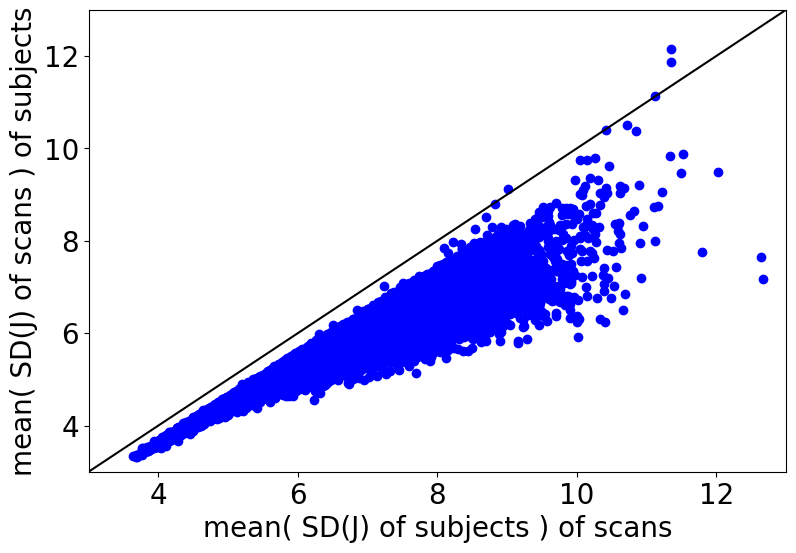

In [64]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
line_width = 3.0
axs.scatter( depytorch(mean_over_scans_of_std_over_subjects_J), depytorch(mean_over_subjects_of_std_over_scans_J), color='blue' )
identity_line_points = np.arange(3.0, 14.0)
axs.plot(identity_line_points, identity_line_points, color='black')
axs.set_xlim([3.0, 13.0])
axs.set_ylim([3.0, 13.0])
axs.set_xlabel('mean( SD(J) of subjects ) of scans')
axs.set_ylabel('mean( SD(J) of scans ) of subjects')

In [ ]:
print([ param_diff.abs().median().item() for param_diff in [J_single_scans_2_unf_group_diff, J_single_scans_2_unf_scan_diff] ])

In [14]:
lstsq_rmse_h_group_all_mean_train = torch.load( os.path.join(file_dir, 'lstsq_rmse_nodewise_h_group_all_mean_train_group_thresholds_31_min_0_max_3_update_min_0_max_63000_inc_1000.pt'), weights_only=False )
print( lstsq_rmse_h_group_all_mean_train.size() )

torch.Size([64, 31, 1000])


In [15]:
lstsq_rmse_h_group_all_mean_test = torch.load( os.path.join(file_dir, 'lstsq_rmse_nodewise_h_group_all_mean_test_group_thresholds_31_min_0_max_3_update_min_0_max_63000_inc_1000.pt'), weights_only=False )
print( lstsq_rmse_h_group_all_mean_test.size() )

torch.Size([64, 31, 1000])


In [16]:
lstsq_rmse_J_group_all_mean_train = torch.load( os.path.join(file_dir, 'lstsq_rmse_pairwise_J_group_sc_mean_train_group_thresholds_31_min_0_max_3_update_min_0_max_63000_inc_1000.pt'), weights_only=False )
print( lstsq_rmse_J_group_all_mean_train.size() )

torch.Size([64, 31, 1000])


In [17]:
lstsq_rmse_J_group_all_mean_test = torch.load( os.path.join(file_dir, 'lstsq_rmse_pairwise_J_group_sc_mean_test_group_thresholds_31_min_0_max_3_update_min_0_max_63000_inc_1000.pt'), weights_only=False )
print( lstsq_rmse_J_group_all_mean_test.size() )

torch.Size([64, 31, 1000])


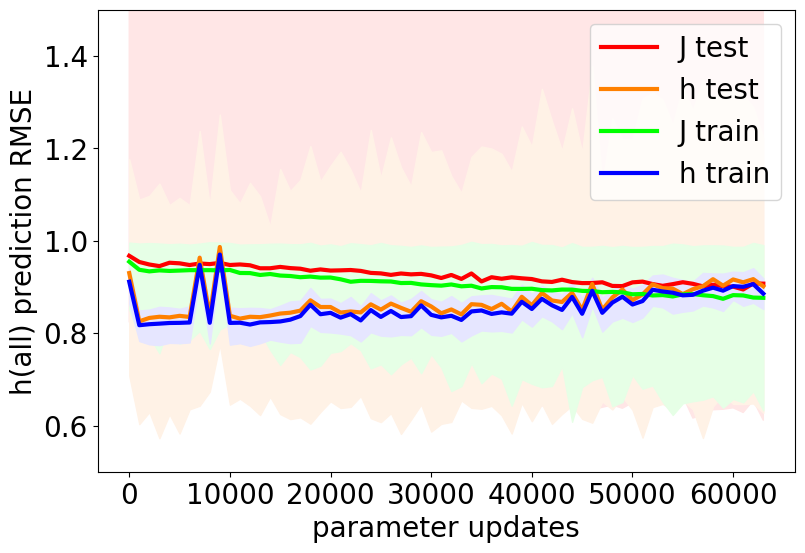

In [35]:
update_start = 0
update_step = 1000
num_updates = lstsq_rmse_h_group_all_mean_train.size(dim=0)
updates = torch.arange( start=update_start, end=update_step*num_updates, step=update_step, dtype=torch.float, device=device )
updates_np = depytorch(updates)

threshold_index = get_closest_match(values=threshold, target=1.5)
selected_threshold = threshold[threshold_index]

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
line_width = 3.0
for rmse_series, rmse_name, rmse_cval in zip([lstsq_rmse_J_group_all_mean_test, lstsq_rmse_h_group_all_mean_test, lstsq_rmse_J_group_all_mean_train, lstsq_rmse_h_group_all_mean_train],['J test', 'h test', 'J train', 'h train'],[red_cval, orange_cval, green_cval, blue_cval]):
    rmse_series_at_thresh = rmse_series[:,threshold_index,:]
    rmse_series_min = depytorch( rmse_series_at_thresh.min(dim=-1).values )
    rmse_series_median = depytorch( rmse_series_at_thresh.median(dim=-1).values )
    rmse_series_max = depytorch( rmse_series_at_thresh.max(dim=-1).values )
    axs.fill_between(updates_np, rmse_series_min, rmse_series_max, color=[0.9+0.1*c for c in rmse_cval])# , label=f'thresh.={selected_threshold:.3g} range'
    axs.plot(updates_np, rmse_series_median, color=rmse_cval, linewidth=line_width, label=rmse_name)# , label=f'thresh.={selected_threshold:.3g} median'
# axs.set_ylim([0.4, 1.1])
axs.set_ylim([0.5, 1.5])
axs.legend(loc='upper right')# , bbox_to_anchor=(1.46, 0.5)
axs.set_xlabel('parameter updates')
axs.set_ylabel('h(all) prediction RMSE')
plt.show()

In [66]:
corr_h_series = torch.load( os.path.join(file_dir, 'direct_corr_nodewise_h_group_all_mean_group_thresholds_31_min_0_max_3_update_min_0_max_63000_inc_1000.pt'), weights_only=False )
print( corr_h_series.size() )

torch.Size([64, 31, 4])


In [67]:
corr_J_series = torch.load( os.path.join(file_dir, 'direct_corr_pairwise_J_group_sc_mean_group_thresholds_31_min_0_max_3_update_min_0_max_63000_inc_1000.pt'), weights_only=False )
print( corr_J_series.size() )

torch.Size([64, 31, 1])


In [134]:
four_feature_h_lstsq_corr = torch.load( os.path.join(file_dir, 'lstsq_corr_nodewise_h_group_all_mean_group_thresholds_31_min_0_max_3_update_min_0_max_63000_inc_1000.pt'), weights_only=False )
print( four_feature_h_lstsq_corr.size() )

torch.Size([64, 31, 4])


In [135]:
four_feature_h_lstsq_corr = four_feature_h_lstsq_corr[:,:,0]

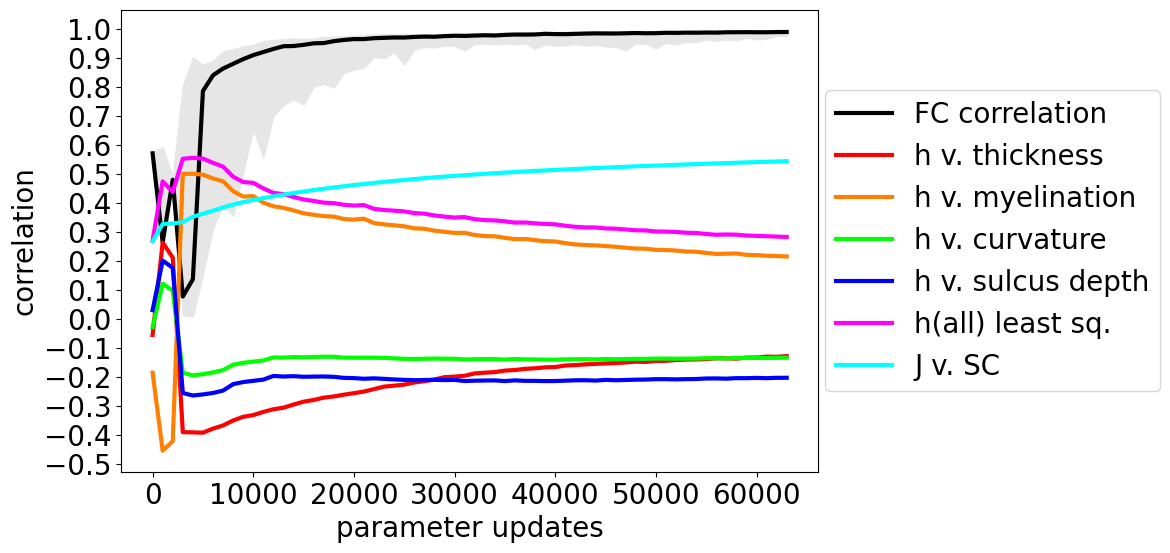

In [136]:
update_start = 0
update_step = 1000
num_updates = corr_h_series.size(dim=0)
updates = torch.arange( start=update_start, end=update_step*num_updates, step=update_step, dtype=torch.float, device=device )
updates_np = depytorch(updates)

threshold_index = get_closest_match(values=threshold, target=1.0)
selected_threshold = threshold[threshold_index]

fc_corr_series_at_thresh = fc_corr_series_init_means[:,:,threshold_index]
fc_corr_series_min = fc_corr_series_at_thresh.min(dim=1).values
fc_corr_series_median = fc_corr_series_at_thresh.median(dim=1).values
fc_corr_series_max = fc_corr_series_at_thresh.max(dim=1).values

corr_series_list = [ depytorch(corr_h_series[:,threshold_index,feature_index]) for feature_index in range( corr_h_series.size(dim=-1) ) ] + [depytorch(four_feature_h_lstsq_corr[:,threshold_index])] + [ depytorch( corr_J_series.squeeze(dim=-1)[:,threshold_index] ) ]
corr_series_names = [ f'h v. {feature_name}' for feature_name in ['thickness', 'myelination', 'curvature', 'sulcus depth'] ] + ['h(all) least sq.', 'J v. SC']
magenta_cval = [1.0, 0.0, 1.0]
corr_series_colors = [red_cval, orange_cval, green_cval, blue_cval, magenta_cval, cyan_cval]

fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
line_width = 3.0
black_cval = [0.0, 0.0, 0.0]
axs.fill_between( updates_np, depytorch(fc_corr_series_min), depytorch(fc_corr_series_max), color=[0.9+0.1*c for c in black_cval] )# label='FC correlation range'
axs.plot( updates_np, depytorch(fc_corr_series_median), color=black_cval, linewidth=line_width, label='FC correlation' )
for corr_series, corr_name, corr_cval in zip(corr_series_list, corr_series_names, corr_series_colors):
    axs.plot(updates_np, corr_series, color=corr_cval, linewidth=line_width, label=corr_name)# , label=f'thresh.={selected_threshold:.3g} median'
# axs.set_ylim([0.4, 1.1])
# axs.set_ylim([0.5, 1.5])
axs.set_yticks( np.arange(-0.5, 1.1, 0.1) )
axs.legend(loc='center', bbox_to_anchor=(1.25, 0.5))
axs.set_xlabel('parameter updates')
axs.set_ylabel('correlation')
plt.show()

In [137]:
best_num_updates = torch.argmax(four_feature_h_lstsq_corr[:,threshold_index])
four_feature_h_lstsq_corr_snapshot = four_feature_h_lstsq_corr[best_num_updates,:]
fc_corr_snapshot = fc_corr_series_init_means[best_num_updates,:,:]
fc_corr_snapshot_min = fc_corr_snapshot.min(dim=0).values
fc_corr_snapshot_median = fc_corr_snapshot.median(dim=0).values
fc_corr_snapshot_max = fc_corr_snapshot.max(dim=0).values
corr_h_snapshot = corr_h_series[best_num_updates,:,:]
corr_J_snapshot = corr_J_series[best_num_updates,:,0]

In [145]:
print( updates[best_num_updates].item() )

4000.0


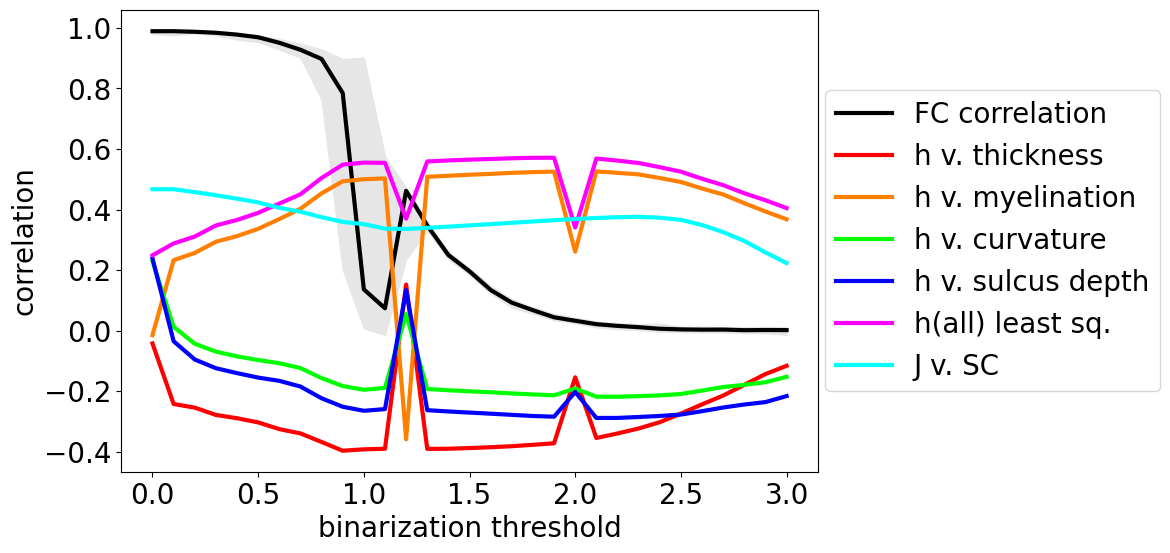

In [144]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
line_width = 3.0
threshold_np = depytorch(threshold)
axs.fill_between(threshold_np, depytorch(fc_corr_snapshot_min), depytorch(fc_corr_snapshot_max), color=[0.9+0.1*c for c in black_cval])# , label=f'thresh.={selected_threshold:.3g} range'
axs.plot(threshold_np, depytorch(fc_corr_snapshot_median), color=black_cval, linewidth=line_width, label='FC correlation')# , label=f'thresh.={selected_threshold:.3g} median'

corr_snapshot_list = [ depytorch(corr_h_snapshot[:,feature_index]) for feature_index in range( corr_h_snapshot.size(dim=1) ) ] + [depytorch(four_feature_h_lstsq_corr_snapshot), depytorch(corr_J_snapshot)]
corr_snapshot_names = [ f'h v. {feature_name}' for feature_name in ['thickness', 'myelination', 'curvature', 'sulcus depth'] ] + ['h(all) least sq.', 'J v. SC']
corr_snapshot_colors = [red_cval, orange_cval, green_cval, blue_cval, magenta_cval, cyan_cval]

for corr_snapshot, corr_name, corr_cval in zip(corr_snapshot_list, corr_snapshot_names, corr_snapshot_colors):
    axs.plot(threshold_np, corr_snapshot, color=corr_cval, linewidth=line_width, label=corr_name)

# axs.set_ylim([0.0, 1.1])
# axs.set_ylim([0.5, 1.5])
axs.legend(loc='center', bbox_to_anchor=(1.25, 0.5))# , bbox_to_anchor=(1.46, 0.5)
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
plt.show()

In [85]:
print('name', corr_series_names)
print(  'value with max abs', [ corr_series[np.argmax( np.abs(corr_series) )].item() for corr_series in corr_series_list ]  )
print(  'param updates for max abs', [ updates_np[np.argmax( np.abs(corr_series) )].item() for corr_series in corr_series_list ]  )
print( 'final', [corr_series[-1].item() for corr_series in corr_series_list] )

name ['h v. thickness', 'h v. myelination', 'h v. curvature', 'h v. sulcus depth', 'J v. SC']
value with max abs [-0.3930714726448059, 0.5001708269119263, -0.1953880786895752, -0.2648184299468994, 0.5435972213745117]
param updates for max abs [5000.0, 4000.0, 4000.0, 4000.0, 63000.0]
final [-0.12888386845588684, 0.21466262638568878, -0.13449698686599731, -0.20360852777957916, 0.5435972213745117]


In [100]:
update_index = 40
print('name', corr_series_names)
print( '40k updates', [corr_series[update_index].item() for corr_series in corr_series_list] )

name ['h v. thickness', 'h v. myelination', 'h v. curvature', 'h v. sulcus depth', 'J v. SC']
40k updates [-0.16664427518844604, 0.2664947509765625, -0.14124394953250885, -0.2149057388305664, 0.513408899307251]


In [98]:
other_direct_corr_final = torch.load( os.path.join(file_dir, 'direct_corr_nodewise_group_h_mean_node_features_group_thresholds_31_min_0_max_3_63k.pt'), weights_only=False )
print( other_direct_corr_final.size() )

torch.Size([31, 4])


In [99]:
print( other_direct_corr_final[threshold_index,:].tolist() )

[-0.12953218817710876, 0.21403194963932037, -0.13463041186332703, -0.2034035474061966]


In [101]:
fc_corr_beta_test = torch.load( os.path.join(file_dir, 'fc_corr_group_J_inv_cov_h_0_thresholds_31_min_0_max_3_beta_num_101_min_1e-10_max_1_sim_steps_120000_flip_rate_pt5.pt'), weights_only=False )
print( fc_corr_beta_test.size() )

torch.Size([101, 31])


In [102]:
fc_corr_beta_opti = torch.load( os.path.join(file_dir, 'fc_corr_group_J_inv_cov_h_0_thresholds_31_min_0_max_3_beta_num_101_min_1e-10_max_1_sim_length_12000_updates_8_param_sim_length_1200_updates_0_sim_steps_120000.pt'), weights_only=False )
print( fc_corr_beta_opti.size() )

torch.Size([101, 31])


In [103]:
print(  torch.count_nonzero( torch.isnan(fc_corr_beta_test), dim=0 )  )

tensor([ 1,  1,  1,  0,  0,  0,  1,  5, 15, 20, 26, 36, 42, 50, 57, 62, 67, 73,
        75, 80, 83, 86, 89, 90, 93, 93, 94, 97, 97, 99, 98], device='cuda:0')


In [104]:
print(  torch.count_nonzero( torch.isnan(fc_corr_beta_opti), dim=0 )  )

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0], device='cuda:0')


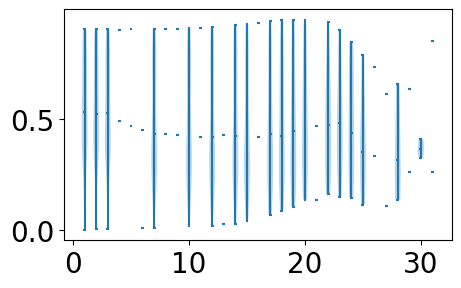

In [48]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 3) )
axs.violinplot(   [depytorch(  fc_corr_slice[torch.logical_not( torch.isnan(fc_corr_slice) )]  ) for fc_corr_slice in fc_corr_beta_test.transpose(dim0=0, dim1=1)], showmedians=True, orientation='vertical'   )
plt.show()

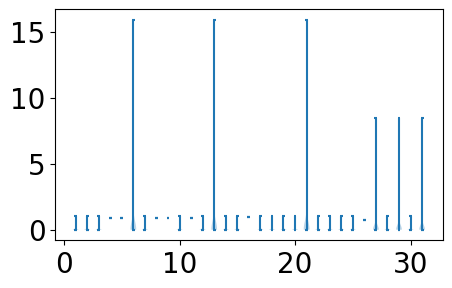

In [49]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 3) )
axs.violinplot( depytorch(fc_corr_beta_opti), showmedians=True, orientation='vertical' )
plt.show()

In [50]:
print( fc_corr_beta_test.transpose(dim0=0, dim1=1) )

tensor([[   nan, 0.0024, 0.0236,  ..., 0.3100, 0.3061, 0.2964],
        [   nan, 0.0053, 0.0253,  ..., 0.3056, 0.2994, 0.2943],
        [   nan, 0.0064, 0.0276,  ..., 0.2960, 0.2852, 0.2821],
        ...,
        [   inf, 0.6596, 0.6081,  ...,    nan,    nan,    nan],
        [   nan, 0.3260, 0.4094,  ...,    nan,    nan,    nan],
        [   inf, 0.8514, 0.2607,  ...,    nan,    nan,    nan]],
       device='cuda:0')


In [51]:
print( fc_corr_beta_opti.transpose(dim0=0, dim1=1) )

tensor([[ 1.0000e+00, -2.0439e-03, -2.6301e-03,  ...,  1.0920e-03,
          3.0010e-03,  1.6331e-03],
        [ 1.0000e+00, -4.2002e-03,  1.6970e-03,  ..., -3.4992e-03,
          7.4198e-03, -2.4575e-04],
        [ 1.0000e+00, -3.0848e-03, -3.5534e-03,  ..., -2.1081e-03,
         -4.9251e-06,  7.0053e-03],
        ...,
        [ 8.4506e+00,  5.6623e-04, -4.7070e-03,  ..., -4.3823e-03,
         -2.2016e-03, -9.7394e-04],
        [ 1.0000e+00, -1.1128e-03, -3.0687e-03,  ...,  1.2394e-03,
          9.7479e-04,  4.8375e-03],
        [ 8.4506e+00,  2.0156e-03, -2.6270e-03,  ...,  2.9920e-03,
         -4.1073e-03, -5.4408e-03]], device='cuda:0')


In [109]:
print( fc_corr_beta_test[:,10].tolist() )
print( fc_corr_beta_opti[:,10].tolist() )

[-inf, 0.020506301894783974, 0.058281056582927704, 0.10568192601203918, 0.1602238267660141, 0.22272342443466187, 0.2864757478237152, 0.33902233839035034, 0.3921816647052765, 0.43344974517822266, 0.4648824632167816, 0.49719491600990295, 0.5219792723655701, 0.5440648198127747, 0.5668657422065735, 0.5877594351768494, 0.606338381767273, 0.6247231364250183, 0.6430424451828003, 0.6648927927017212, 0.6853428483009338, 0.7048419713973999, 0.726318895816803, 0.7487393021583557, 0.7712706923484802, 0.7948620915412903, 0.8170367479324341, 0.8438728451728821, 0.8655504584312439, 0.8881326913833618, 0.9046916961669922, 0.9115496873855591, 0.9096674919128418, 0.889842689037323, 0.8648892045021057, 0.8403815031051636, 0.80007004737854, 0.7704392671585083, 0.7441777586936951, 0.6988836526870728, 0.6533118486404419, 0.38605403900146484, 0.4144124388694763, 0.44286441802978516, 0.42499840259552, 0.43564608693122864, 0.4211234450340271, 0.40573883056640625, 0.3937425911426544, 0.38098323345184326, 0.3654

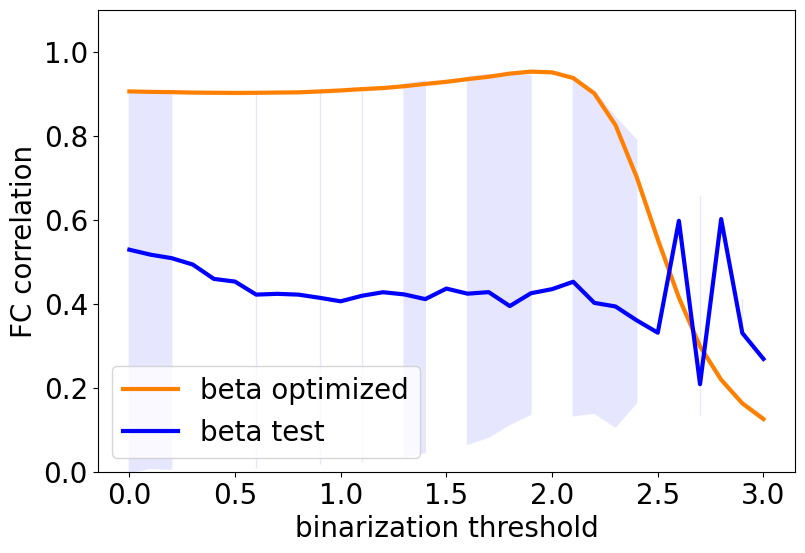

In [107]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
line_width = 3.0
threshold_np = depytorch(threshold)
for fc_corr_series, fc_corr_name, fc_corr_cval in zip([fc_corr_beta_opti, fc_corr_beta_test],['beta optimized', 'beta test'],[orange_cval, blue_cval]):
    fc_corr_series_thresh_as_row = fc_corr_series.transpose(dim0=0, dim1=1)
    fc_corr_series_non_nan_list = [fc_corr_slice[torch.logical_not( torch.isnan(fc_corr_slice) )] for fc_corr_slice in fc_corr_series_thresh_as_row]
    fc_corr_series_min = depytorch(  torch.stack( tensors=[fc_corr_slice.min() for fc_corr_slice in fc_corr_series_non_nan_list], dim=0 )  )
    fc_corr_series_median = depytorch(  torch.stack( tensors=[fc_corr_slice.median() for fc_corr_slice in fc_corr_series_non_nan_list], dim=0 )  )
    fc_corr_series_max = depytorch(  torch.stack( tensors=[fc_corr_slice.max() for fc_corr_slice in fc_corr_series_non_nan_list], dim=0 )  )
    axs.fill_between(threshold_np, fc_corr_series_min, fc_corr_series_max, color=[0.9+0.1*c for c in fc_corr_cval])# , label=f'thresh.={selected_threshold:.3g} range'
    axs.plot(threshold_np, fc_corr_series_median, color=fc_corr_cval, linewidth=line_width, label=fc_corr_name)# , label=f'thresh.={selected_threshold:.3g} median'
axs.set_ylim([0.0, 1.1])
# axs.set_ylim([0.5, 1.5])
axs.legend(loc='lower left')# , bbox_to_anchor=(1.46, 0.5)
axs.set_xlabel('binarization threshold')
axs.set_ylabel('FC correlation')
plt.show()

In [116]:
print( 'threshold', threshold.tolist() )
fc_corr_beta_opti_min = fc_corr_beta_opti.min(dim=0).values
print( 'min after optimization', fc_corr_beta_opti_min.tolist() )
fc_corr_beta_opti_max = fc_corr_beta_opti.max(dim=0).values
print( 'max after optimization', fc_corr_beta_opti_max.tolist() )
fc_corr_beta_test_min_list = [ fc_corr_slice[torch.logical_not(  torch.logical_or( torch.isnan(fc_corr_slice), torch.isinf(fc_corr_slice) )  )].min().item() for fc_corr_slice in fc_corr_beta_test.transpose(dim0=0, dim1=1) ]
fc_corr_beta_test_min = torch.tensor( data=fc_corr_beta_test_min_list, dtype=float_type, device=device )
print('max during beta test', fc_corr_beta_test_min_list)
fc_corr_beta_test_max_list = [ fc_corr_slice[torch.logical_not(  torch.logical_or( torch.isnan(fc_corr_slice), torch.isinf(fc_corr_slice) )  )].max().item() for fc_corr_slice in fc_corr_beta_test.transpose(dim0=0, dim1=1) ]
fc_corr_beta_test_max = torch.tensor( data=fc_corr_beta_test_max_list, dtype=float_type, device=device )
print('max during beta test', fc_corr_beta_test_max_list)

threshold [0.0, 0.10000000149011612, 0.20000000298023224, 0.30000001192092896, 0.4000000059604645, 0.5, 0.6000000238418579, 0.699999988079071, 0.800000011920929, 0.9000000357627869, 1.0, 1.100000023841858, 1.2000000476837158, 1.3000000715255737, 1.399999976158142, 1.5, 1.600000023841858, 1.6999999284744263, 1.7999999523162842, 1.899999976158142, 2.0, 2.0999999046325684, 2.200000047683716, 2.299999952316284, 2.4000000953674316, 2.5, 2.5999999046325684, 2.700000047683716, 2.799999952316284, 2.9000000953674316, 3.0]
min after optimization [0.9026477336883545, 0.9012372493743896, 0.9009261727333069, 0.8991566300392151, 0.9002360105514526, 0.897943377494812, 0.8992472290992737, 0.8997066617012024, 0.9003905653953552, 0.902453601360321, 0.9047733545303345, 0.9069868326187134, 0.9101493954658508, 0.915412425994873, 0.9196104407310486, 0.9247859716415405, 0.9313270449638367, 0.937254011631012, 0.9448093175888062, 0.949383020401001, 0.9490242004394531, 0.9345397353172302, 0.8967380523681641, 0.

In [117]:
print(  torch.max( torch.abs(fc_corr_beta_opti_max - fc_corr_beta_opti_min) )  )

tensor(0.0202, device='cuda:0')


In [118]:
fc_corr_beta_opti_median = fc_corr_beta_opti.median(dim=0).values

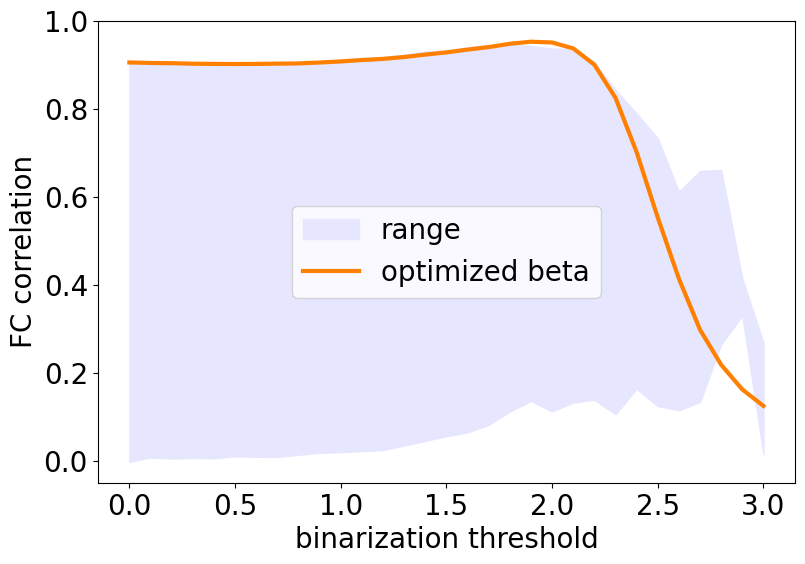

In [120]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
line_width = 3.0
threshold_np = depytorch(threshold)
axs.fill_between(threshold_np, depytorch(fc_corr_beta_test_min), depytorch(fc_corr_beta_test_max), color=[0.9+0.1*c for c in blue_cval], label='range')# , label=f'thresh.={selected_threshold:.3g} range'
axs.plot(threshold_np, depytorch(fc_corr_beta_opti_median), color=orange_cval, linewidth=line_width, label='optimized beta')# , label=f'thresh.={selected_threshold:.3g} median'
# axs.set_ylim([0.0, 1.1])
# axs.set_ylim([0.5, 1.5])
axs.legend(loc='center')# , bbox_to_anchor=(1.46, 0.5)
axs.set_xlabel('binarization threshold')
axs.set_ylabel('FC correlation')
plt.show()

In [64]:
best_beta = torch.load( os.path.join(file_dir, 'ising_model_group_J_inv_cov_h_0_thresholds_31_min_0_max_3_beta_num_101_min_1e-10_max_1_sim_length_120000_updates_24_param_sim_length_1200_updates_0.pt'), weights_only=False ).beta
print( best_beta.size() )

torch.Size([101, 31])


In [65]:
best_beta_min = best_beta.min(dim=0).values
best_beta_median = best_beta.median(dim=0).values
best_beta_max = best_beta.max(dim=0).values
print( best_beta_min )
print( best_beta_max )

tensor([0.0000, 0.0000, 0.0000, 0.5467, 0.5191, 0.0000, 0.0000, 0.4205, 0.3831,
        0.0000, 0.3126, 0.0000, 0.0000, 0.0000, 0.0000, 0.1630, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0224, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')
tensor([0.0000, 0.0000, 0.0000, 0.5467, 0.5191, 0.0000, 0.0000, 0.4205, 0.3831,
        0.0000, 0.3126, 0.0000, 0.0000, 0.0000, 0.0000, 0.1630, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0224, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0')


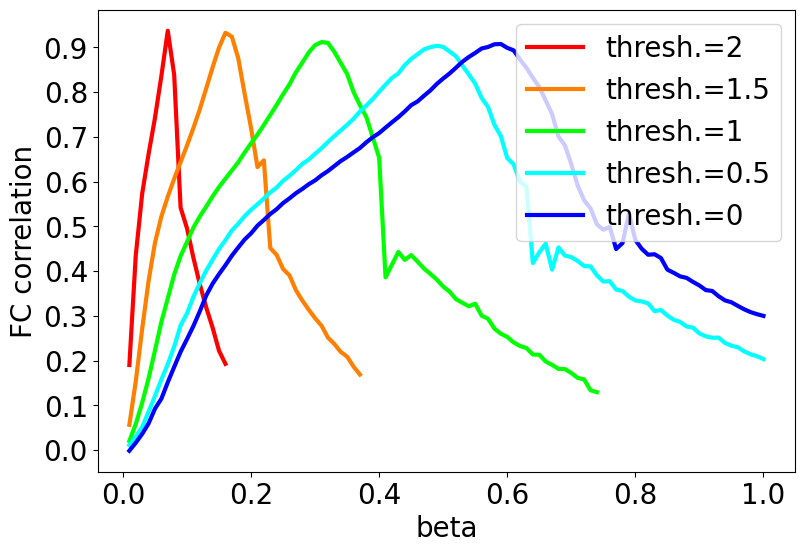

In [108]:
beta = torch.linspace(start=1e-10, end=1, steps=101, dtype=float_type, device=device)
beta_np = depytorch(beta)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
line_width = 3.0
for target_threshold, threshold_cval in zip([2.0, 1.5, 1.0, 0.5, 0.0],[red_cval, orange_cval, green_cval, cyan_cval, blue_cval]):
    threshold_index = get_closest_match(values=threshold, target=target_threshold)
    selected_threshold = threshold[threshold_index]
    fc_corr_beta_test_at_threshold = depytorch(fc_corr_beta_test[:,threshold_index])
    # fc_corr_beta_opti_at_threshold = fc_corr_beta_opti[:,threshold_index]
    axs.plot(beta_np, fc_corr_beta_test_at_threshold, color=threshold_cval, linewidth=line_width, label=f'thresh.={selected_threshold:.3g}')# , label=f'thresh.={selected_threshold:.3g} median'
# axs.set_ylim([0.4, 1.1])
# axs.set_ylim([0.5, 1.5])
axs.set_yticks( np.arange(0.0, 1.0, 0.1) )
axs.legend(loc='upper right')# , bbox_to_anchor=(1.46, 0.5)
axs.set_xlabel('beta')
axs.set_ylabel('FC correlation')
plt.show()

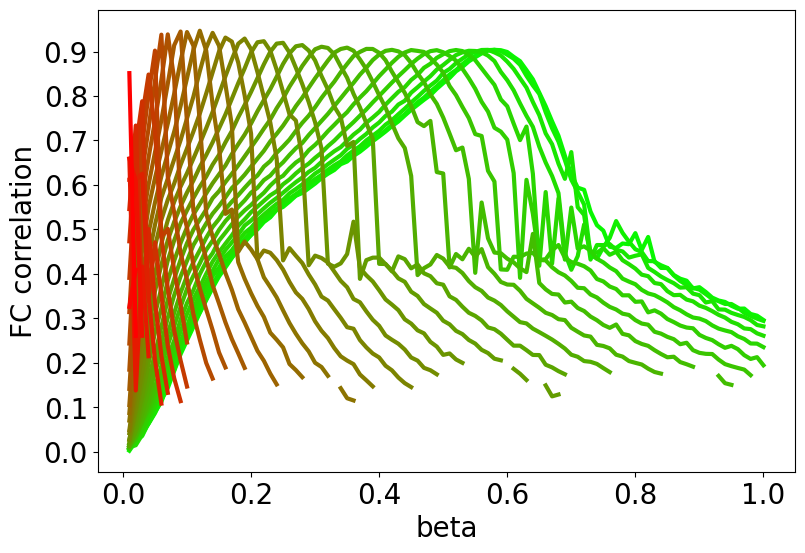

In [69]:
beta = torch.linspace(start=1e-10, end=1, steps=101, dtype=float_type, device=device)
beta_np = depytorch(beta)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
line_width = 3.0
num_thresh = threshold.numel()
for threshold_index in range(num_thresh):
    selected_threshold = threshold[threshold_index]
    fc_corr_beta_test_at_threshold = depytorch(fc_corr_beta_test[:,threshold_index])
    thresh_frac = (threshold_index+1)/num_thresh
    threshold_cval = [thresh_frac, 1.0-thresh_frac, 0.0]
    # fc_corr_beta_opti_at_threshold = fc_corr_beta_opti[:,threshold_index]
    axs.plot(beta_np, fc_corr_beta_test_at_threshold, color=threshold_cval, linewidth=line_width, label=f'thresh.={selected_threshold:.3g}')# , label=f'thresh.={selected_threshold:.3g} median'
# axs.set_ylim([0.4, 1.1])
# axs.set_ylim([0.5, 1.5])
axs.set_yticks( np.arange(0.0, 1.0, 0.1) )
# axs.legend(loc='upper right')# , bbox_to_anchor=(1.46, 0.5)
axs.set_xlabel('beta')
axs.set_ylabel('FC correlation')
plt.show()

In [135]:
fc_corr_beta_test_neg_nans = fc_corr_beta_test.clone()
fc_corr_beta_test_neg_nans[ torch.isnan(fc_corr_beta_test_neg_nans) ] = -1.0
fc_corr_beta_test_neg_nans[ torch.isinf(fc_corr_beta_test_neg_nans) ] = -1.0
fc_corr_beta_test_best, fc_corr_beta_test_best_index = torch.max(fc_corr_beta_test_neg_nans, dim=0)
print( 'threshold:', threshold )
print( 'best beta at threshold:', beta[fc_corr_beta_test_best_index] )
print( 'best FC corr at threshold:', fc_corr_beta_test_best )

threshold: tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
        1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000,
        2.7000, 2.8000, 2.9000, 3.0000], device='cuda:0')
best beta at threshold: tensor([0.5800, 0.5800, 0.5700, 0.5400, 0.5200, 0.4900, 0.4500, 0.4200, 0.3800,
        0.3500, 0.3100, 0.2800, 0.2500, 0.2200, 0.1900, 0.1600, 0.1400, 0.1200,
        0.1000, 0.0900, 0.0700, 0.0600, 0.0500, 0.0400, 0.0300, 0.0200, 0.0300,
        0.0100, 0.0100, 0.0200, 0.0100], device='cuda:0')
best FC corr at threshold: tensor([0.9038, 0.9038, 0.9037, 0.9017, 0.9034, 0.9031, 0.9033, 0.9037, 0.9059,
        0.9088, 0.9108, 0.9145, 0.9196, 0.9232, 0.9292, 0.9313, 0.9419, 0.9468,
        0.9438, 0.9450, 0.9385, 0.9379, 0.9020, 0.8483, 0.7882, 0.7335, 0.6251,
        0.6582, 0.6596, 0.4094, 0.8514], device='cuda:0')


In [79]:
threshold_index = get_closest_match(values=threshold, target=0.5)
print( fc_corr_beta_test[:,threshold_index].tolist() )

[inf, 0.008497519418597221, 0.027854561805725098, 0.05324159935116768, 0.0826348066329956, 0.1190873235464096, 0.15454819798469543, 0.19509091973304749, 0.2346174418926239, 0.2704651653766632, 0.3100045919418335, 0.3433837294578552, 0.37094539403915405, 0.4001355469226837, 0.42777499556541443, 0.44895926117897034, 0.4680767357349396, 0.4866196811199188, 0.5081117749214172, 0.5224756002426147, 0.5387959480285645, 0.5511609315872192, 0.5640367269515991, 0.5767077803611755, 0.5857852697372437, 0.6015167832374573, 0.6123698949813843, 0.626072347164154, 0.6380175948143005, 0.6479886174201965, 0.6610171794891357, 0.672605574131012, 0.6871209144592285, 0.6996820569038391, 0.714198887348175, 0.728015661239624, 0.7412883639335632, 0.7557833790779114, 0.7699152827262878, 0.7856265306472778, 0.8002272844314575, 0.8152696490287781, 0.8302298784255981, 0.8445937037467957, 0.8580763936042786, 0.8720598816871643, 0.884122908115387, 0.8942805528640747, 0.9008343815803528, 0.9030783772468567, 0.8984373

In [120]:
cov_rmse_beta_test = torch.load( f=os.path.join(file_dir, 'cov_rmse_J_inv_cov_thresh_num_31_min_0_max_3_test_beta_min_1e-10_max_1_sim_steps_120000_v2.pt'), weights_only=False )
print( cov_rmse_beta_test.size() )

torch.Size([101, 31])


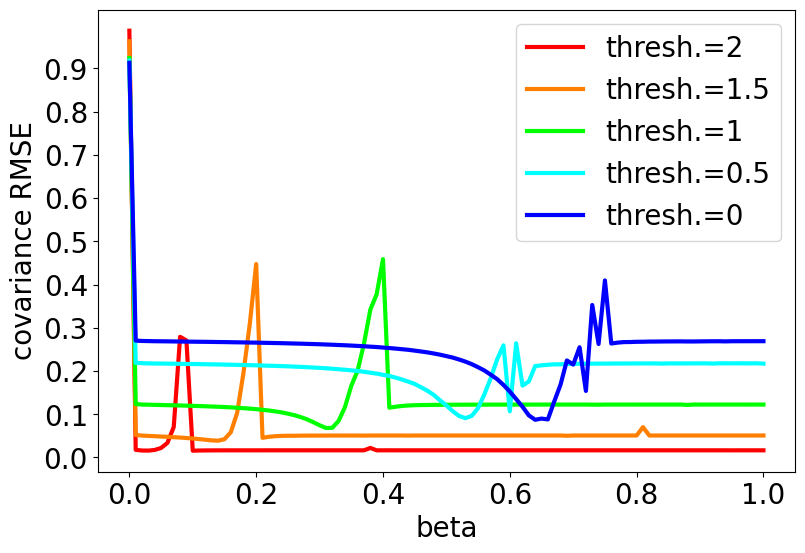

In [121]:
beta = torch.linspace(start=1e-10, end=1, steps=101, dtype=float_type, device=device)
beta_np = depytorch(beta)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
line_width = 3.0
for target_threshold, threshold_cval in zip([2.0, 1.5, 1.0, 0.5, 0.0],[red_cval, orange_cval, green_cval, cyan_cval, blue_cval]):
    threshold_index = get_closest_match(values=threshold, target=target_threshold)
    selected_threshold = threshold[threshold_index]
    cov_rmse_beta_test_at_threshold = depytorch(cov_rmse_beta_test[:,threshold_index])
    # fc_corr_beta_opti_at_threshold = fc_corr_beta_opti[:,threshold_index]
    axs.plot(beta_np, cov_rmse_beta_test_at_threshold, color=threshold_cval, linewidth=line_width, label=f'thresh.={selected_threshold:.3g}')# , label=f'thresh.={selected_threshold:.3g} median'
# axs.set_ylim([0.4, 1.1])
# axs.set_ylim([0.5, 1.5])
axs.set_yticks( np.arange(0.0, 1.0, 0.1) )
axs.legend(loc='upper right')# , bbox_to_anchor=(1.46, 0.5)
axs.set_xlabel('beta')
axs.set_ylabel('covariance RMSE')
plt.show()

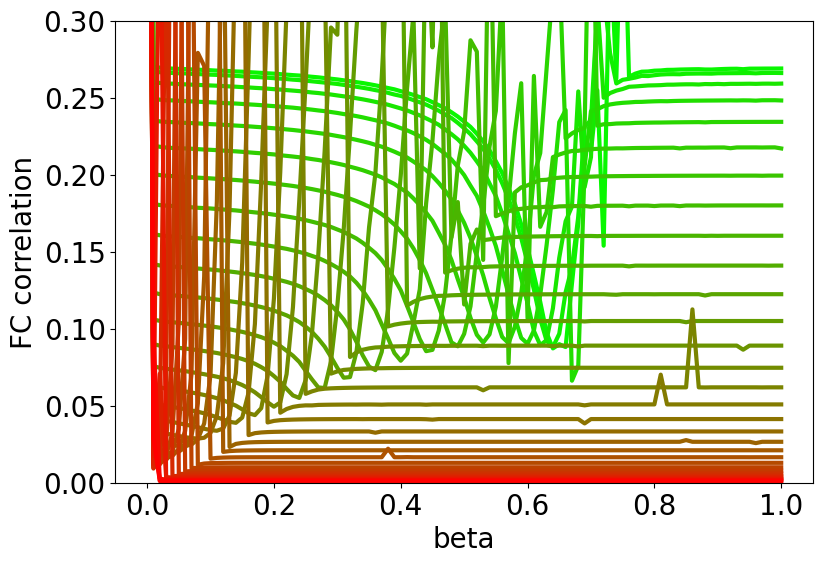

In [122]:
beta = torch.linspace(start=1e-10, end=1, steps=101, dtype=float_type, device=device)
beta_np = depytorch(beta)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
line_width = 3.0
num_thresh = threshold.numel()
for threshold_index in range(num_thresh):
    selected_threshold = threshold[threshold_index]
    cov_rmse_beta_test_at_threshold = depytorch(cov_rmse_beta_test[:,threshold_index])
    thresh_frac = (threshold_index+1)/num_thresh
    threshold_cval = [thresh_frac, 1.0-thresh_frac, 0.0]
    # fc_corr_beta_opti_at_threshold = fc_corr_beta_opti[:,threshold_index]
    axs.plot(beta_np, cov_rmse_beta_test_at_threshold, color=threshold_cval, linewidth=line_width, label=f'thresh.={selected_threshold:.3g}')# , label=f'thresh.={selected_threshold:.3g} median'
# axs.set_ylim([0.4, 1.1])
axs.set_ylim([0.0, 0.3])
# axs.set_yticks( np.arange(0.0, 1.0, 0.1) )
# axs.legend(loc='upper right')# , bbox_to_anchor=(1.46, 0.5)
axs.set_xlabel('beta')
axs.set_ylabel('FC correlation')
plt.show()

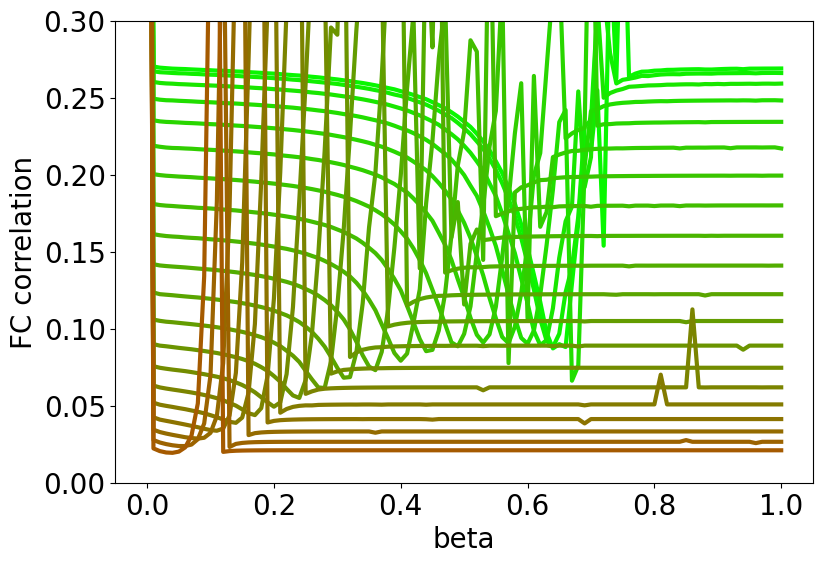

In [123]:
beta = torch.linspace(start=1e-10, end=1, steps=101, dtype=float_type, device=device)
beta_np = depytorch(beta)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
line_width = 3.0
num_thresh = threshold.numel()
for threshold_index in range(20):
    selected_threshold = threshold[threshold_index]
    cov_rmse_beta_test_at_threshold = depytorch(cov_rmse_beta_test[:,threshold_index])
    thresh_frac = (threshold_index+1)/num_thresh
    threshold_cval = [thresh_frac, 1.0-thresh_frac, 0.0]
    # fc_corr_beta_opti_at_threshold = fc_corr_beta_opti[:,threshold_index]
    axs.plot(beta_np, cov_rmse_beta_test_at_threshold, color=threshold_cval, linewidth=line_width, label=f'thresh.={selected_threshold:.3g}')# , label=f'thresh.={selected_threshold:.3g} median'
# axs.set_ylim([0.4, 1.1])
axs.set_ylim([0.0, 0.3])
# axs.set_yticks( np.arange(0.0, 1.0, 0.1) )
# axs.legend(loc='upper right')# , bbox_to_anchor=(1.46, 0.5)
axs.set_xlabel('beta')
axs.set_ylabel('FC correlation')
plt.show()

In [124]:
flip_rate_beta_test = torch.load( f=os.path.join(file_dir, 'flip_rate_J_inv_cov_thresh_num_31_min_0_max_3_test_beta_min_1e-10_max_1_sim_steps_120000_v2.pt'), weights_only=False )
print( flip_rate_beta_test.size() )

torch.Size([101, 31, 360])


In [125]:
mean_flip_rate_beta_test = flip_rate_beta_test.mean(dim=-1)

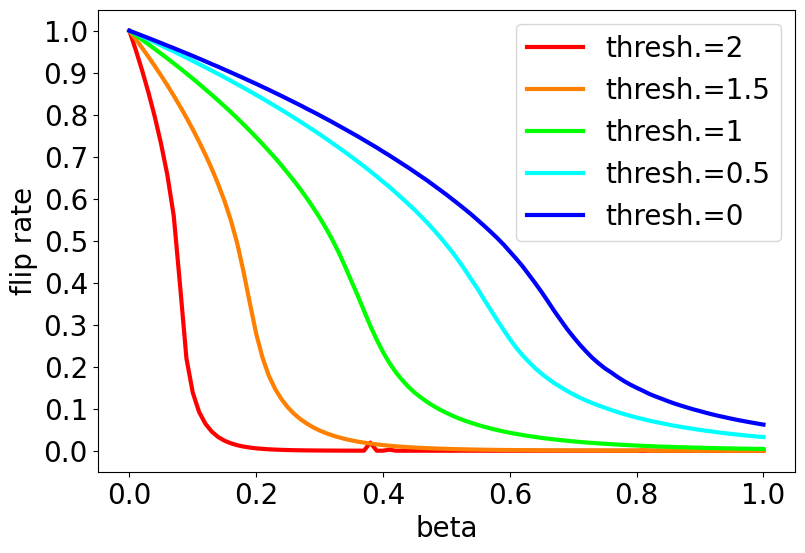

In [127]:
beta = torch.linspace(start=1e-10, end=1, steps=101, dtype=float_type, device=device)
beta_np = depytorch(beta)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
line_width = 3.0
for target_threshold, threshold_cval in zip([2.0, 1.5, 1.0, 0.5, 0.0],[red_cval, orange_cval, green_cval, cyan_cval, blue_cval]):
    threshold_index = get_closest_match(values=threshold, target=target_threshold)
    selected_threshold = threshold[threshold_index]
    mean_flip_rate_beta_test_at_threshold = depytorch(mean_flip_rate_beta_test[:,threshold_index])
    # fc_corr_beta_opti_at_threshold = fc_corr_beta_opti[:,threshold_index]
    axs.plot(beta_np, mean_flip_rate_beta_test_at_threshold, color=threshold_cval, linewidth=line_width, label=f'thresh.={selected_threshold:.3g}')# , label=f'thresh.={selected_threshold:.3g} median'
# axs.set_ylim([0.4, 1.1])
# axs.set_ylim([0.5, 1.5])
axs.set_yticks( np.arange(0.0, 1.1, 0.1) )
axs.legend(loc='upper right')# , bbox_to_anchor=(1.46, 0.5)
axs.set_xlabel('beta')
axs.set_ylabel('flip rate')
plt.show()

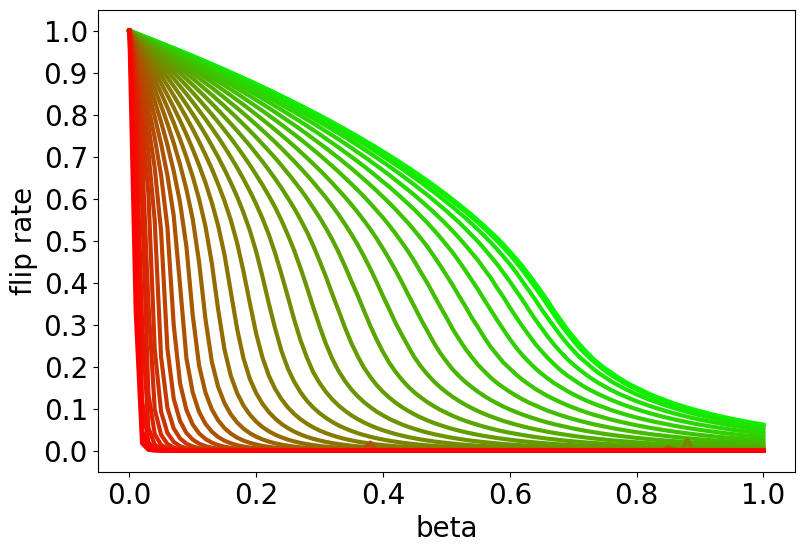

In [129]:
beta = torch.linspace(start=1e-10, end=1, steps=101, dtype=float_type, device=device)
beta_np = depytorch(beta)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
line_width = 3.0
num_thresh = threshold.numel()
for threshold_index in range(num_thresh):
    selected_threshold = threshold[threshold_index]
    mean_flip_rate_beta_test_at_threshold = depytorch(mean_flip_rate_beta_test[:,threshold_index])
    thresh_frac = (threshold_index+1)/num_thresh
    threshold_cval = [thresh_frac, 1.0-thresh_frac, 0.0]
    # fc_corr_beta_opti_at_threshold = fc_corr_beta_opti[:,threshold_index]
    axs.plot(beta_np, mean_flip_rate_beta_test_at_threshold, color=threshold_cval, linewidth=line_width, label=f'thresh.={selected_threshold:.3g}')# , label=f'thresh.={selected_threshold:.3g} median'
# axs.set_ylim([0.4, 1.1])
# axs.set_ylim([0.0, 0.3])
axs.set_yticks( np.arange(0.0, 1.1, 0.1) )
# axs.legend(loc='upper right')# , bbox_to_anchor=(1.46, 0.5)
axs.set_xlabel('beta')
axs.set_ylabel('flip rate')
plt.show()

In [133]:
min_diff_from_pt5, min_diff_from_pt5_index = torch.min( torch.abs(mean_flip_rate_beta_test-0.5), dim=0 )
min_diff_from_pt5_beta = beta[min_diff_from_pt5_index]
print('thrs', threshold)
print('beta', min_diff_from_pt5_beta)
print('diff', min_diff_from_pt5)

thrs tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000, 1.1000, 1.2000, 1.3000, 1.4000, 1.5000, 1.6000, 1.7000,
        1.8000, 1.9000, 2.0000, 2.1000, 2.2000, 2.3000, 2.4000, 2.5000, 2.6000,
        2.7000, 2.8000, 2.9000, 3.0000], device='cuda:0')
beta tensor([0.5800, 0.5800, 0.5700, 0.5500, 0.5200, 0.4900, 0.4600, 0.4300, 0.3900,
        0.3600, 0.3200, 0.2900, 0.2500, 0.2200, 0.1900, 0.1700, 0.1500, 0.1200,
        0.1000, 0.0900, 0.0700, 0.0600, 0.0500, 0.0400, 0.0300, 0.0300, 0.0200,
        0.0200, 0.0100, 0.0100, 0.0100], device='cuda:0')
diff tensor([0.0066, 0.0003, 0.0041, 0.0023, 0.0066, 0.0087, 0.0052, 0.0046, 0.0051,
        0.0092, 0.0027, 0.0116, 0.0139, 0.0144, 0.0244, 0.0056, 0.0330, 0.0344,
        0.0510, 0.0141, 0.0592, 0.0322, 0.0230, 0.0477, 0.1132, 0.1488, 0.0972,
        0.1913, 0.2269, 0.0965, 0.1683], device='cuda:0')


torch.Size([6498, 6498]) tensor(0, device='cuda:0') tensor(0, device='cuda:0')


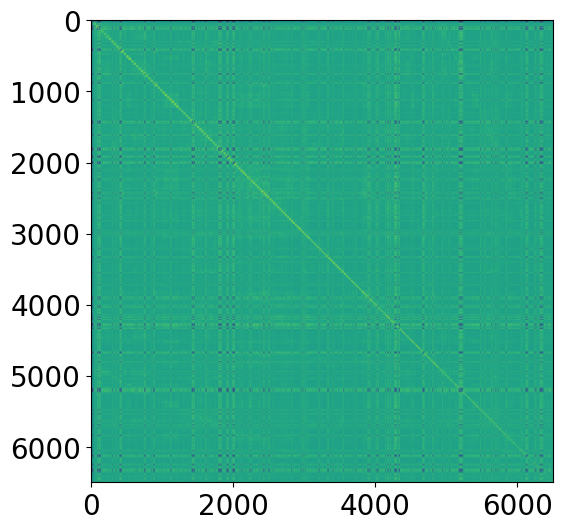

In [147]:
test_fim = torch.load( os.path.join(file_dir, 'fim_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_63000_target_10_rep_89_test_length_64980_downsample_10.pt'), weights_only=False, map_location='cuda:0' )
print(  test_fim.size(), torch.count_nonzero( torch.isnan(test_fim) ), torch.count_nonzero( torch.isinf(test_fim) )  )
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.imshow( depytorch(test_fim) )

In [151]:
print( test_fim.min().item(), test_fim.mean().item(), test_fim.max().item() )

-0.5070840716362 0.05916536599397659 0.45262977480888367


torch.Size([6606, 6498]) tensor(0, device='cuda:0') tensor(0, device='cuda:0')


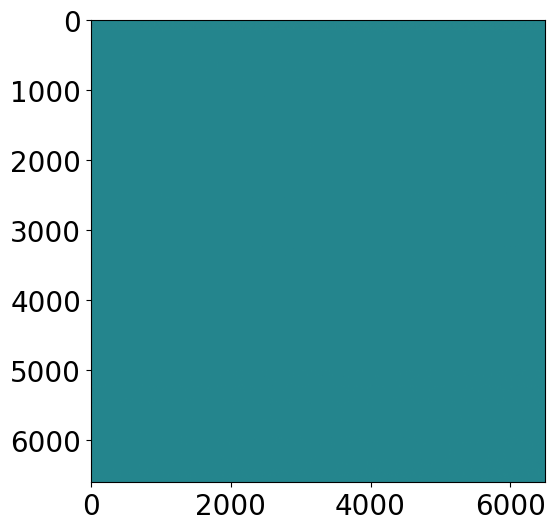

In [148]:
test_jacob = torch.load( os.path.join(file_dir, 'coeffs_lstsq_all_to_all_wo_intercept_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_63000_target_10_rep_89_test_length_64980_downsample_10.pt'), weights_only=False, map_location='cuda:0' )
print(  test_jacob.size(), torch.count_nonzero( torch.isnan(test_jacob) ), torch.count_nonzero( torch.isinf(test_jacob) )  )
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.imshow( depytorch(test_jacob) )

In [149]:
print( test_jacob.min().item(), test_jacob.mean().item(), test_jacob.max().item() )

-1.3376893997192383 1.0096586265717633e-05 1.592402696609497


torch.Size([6606, 6606]) tensor(0, device='cuda:0') tensor(0, device='cuda:0')


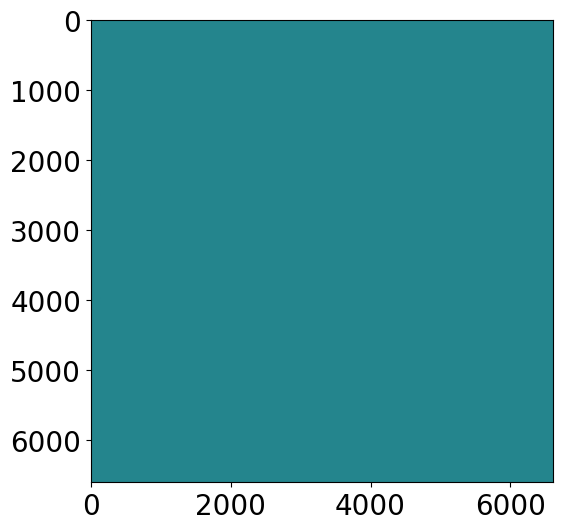

In [150]:
test_struct_fim = torch.load( os.path.join(file_dir, 'struct_fim_lstsq_all_to_all_ising_model_light_group_thresholds_31_min_0_max_3_betas_101_min_1e-10_max_0.05_steps_1200_lr_0.01_beta_updates_8_param_updates_63000_target_10_rep_89_test_length_64980_downsample_10.pt'), weights_only=False, map_location='cuda:0' )
print(  test_struct_fim.size(), torch.count_nonzero( torch.isnan(test_struct_fim) ), torch.count_nonzero( torch.isinf(test_struct_fim) )  )
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
axs.imshow( depytorch(test_struct_fim) )

In [152]:
print( test_struct_fim.min().item(), test_struct_fim.mean().item(), test_struct_fim.max().item() )

-28011.654296875 0.1961687207221985 33477.0390625
